# New York City Taxi Trip - Fare Amount, Tip Amount, Tip Paid Prediction

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint
from scipy.stats import uniform
import math
import pickle

In [3]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100

In [5]:
data = pd.read_csv("data/taxi-train.csv")

In [6]:
data.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,tip_paid
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.80,CSH,6.5,0.00,0
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.50,Cre,6.9,1.88,1
2,CMT,2010-03-03 10:10:25+00:00,2010-03-03 10:19:38+00:00,-73.974089,40.762479,-73.990669,40.745668,1.0,1,1.60,Cre,6.9,1.00,1
3,VTS,2012-04-17 11:51:00+00:00,2012-04-17 12:07:00+00:00,-73.979920,40.781045,-73.970415,40.765608,1.0,1,1.70,CRD,9.7,1.94,1
4,VTS,2012-03-30 14:26:00+00:00,2012-03-30 14:36:00+00:00,-73.972975,40.761610,-73.955615,40.764290,1.0,2,1.36,CSH,6.9,0.00,0


In [7]:
data.shape

(1071910, 14)

In [8]:
data.dtypes

vendor_id             object
pickup_datetime       object
dropoff_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
rate_code            float64
passenger_count        int64
trip_distance        float64
payment_type          object
fare_amount          float64
tip_amount           float64
tip_paid               int64
dtype: object

## EDA

In [9]:
data['fare_amount'].describe()

count    1.071910e+06
mean     8.456763e+00
std      4.017411e+00
min      2.500000e+00
25%      5.700000e+00
50%      7.500000e+00
75%      1.010000e+01
max      2.000000e+02
Name: fare_amount, dtype: float64

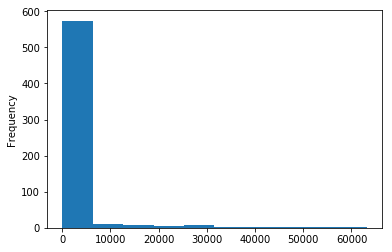

In [10]:
g = data.groupby('fare_amount').size().plot(kind='hist')

In [10]:
# log transform fare_amount for plotting and EDA
# s.transform([np.sqrt, np.exp])
# in case there 0 values, use np.log1p
data['fare_amount_log'] = data['fare_amount'].transform([np.log1p])

In [11]:
data['fare_amount_log'].describe()

count    1.071910e+06
mean     2.172460e+00
std      3.751131e-01
min      1.252763e+00
25%      1.902108e+00
50%      2.140066e+00
75%      2.406945e+00
max      5.303305e+00
Name: fare_amount_log, dtype: float64

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


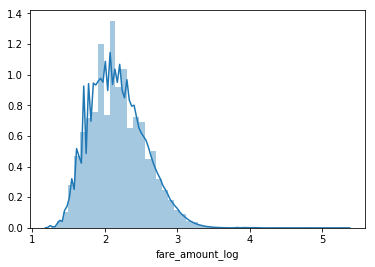

In [12]:
g = sns.distplot(data['fare_amount_log'])

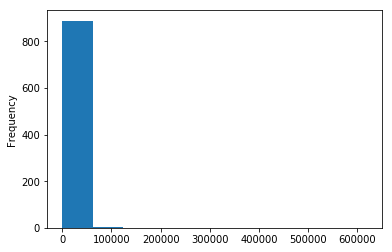

In [13]:
g = data.groupby('tip_amount').size().plot(kind='hist')

In [14]:
# log transform tip_amount for plotting and EDA
# s.transform([np.sqrt, np.exp])
# since there are 0 values, use log1p (log(1 + x))
data['tip_amount_log'] = data['tip_amount'].transform([np.log1p])

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


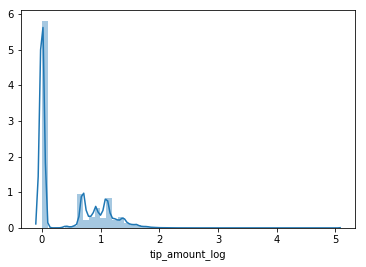

In [15]:
g = sns.distplot(data['tip_amount_log'])

In [16]:
data['vendor_id'].value_counts()

VTS    539286
CMT    520331
DDS     12293
Name: vendor_id, dtype: int64

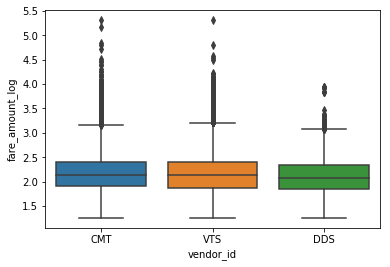

In [17]:
g = sns.boxplot(x='vendor_id', y='fare_amount_log', data=data)

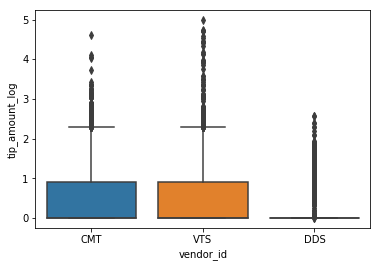

In [18]:
g = sns.boxplot(x='vendor_id', y='tip_amount_log', data=data)

In [19]:
data['rate_code'].value_counts()

1.0     896903
4.0       1154
2.0        379
0.0        116
5.0         87
3.0         49
6.0          5
99.0         1
Name: rate_code, dtype: int64

In [20]:
data[data['rate_code']==0]

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,tip_paid,fare_amount_log,tip_amount_log
26547,DDS,2010-05-06 07:23:30+00:00,2010-05-06 07:31:12+00:00,-73.989080,40.777927,-73.981985,40.767722,0.0,1,1.1,CAS,6.1,0.00,0,1.960095,0.000000
30580,CMT,2013-05-25 22:14:30+00:00,2013-05-25 22:22:58+00:00,-73.979104,40.729955,-73.988053,40.745863,0.0,4,1.6,CRD,8.0,1.00,1,2.197225,0.693147
38135,DDS,2010-04-29 17:21:55+00:00,2010-04-29 17:32:12+00:00,-73.984907,40.724082,-73.979953,40.734780,0.0,2,1.5,CAS,7.3,0.00,0,2.116256,0.000000
58805,CMT,2013-07-04 22:56:24+00:00,2013-07-04 23:01:20+00:00,-73.988271,40.716457,-73.985400,40.727587,0.0,1,0.9,CSH,5.5,0.00,0,1.871802,0.000000
71633,CMT,2012-03-23 13:57:49+00:00,2012-03-23 14:11:28+00:00,-73.982406,40.731460,-73.936686,40.794381,0.0,1,4.9,CRD,12.9,4.02,1,2.631889,1.613430
89986,DDS,2010-04-28 09:43:40+00:00,2010-04-28 09:51:19+00:00,-73.957347,40.782932,-73.982457,40.772357,0.0,2,1.6,CAS,6.5,0.00,0,2.014903,0.000000
92847,CMT,2011-12-10 23:19:43+00:00,2011-12-10 23:40:10+00:00,-73.999173,40.720020,-73.973673,40.755376,0.0,3,3.1,CSH,12.9,0.00,0,2.631889,0.000000
106390,CMT,2011-11-18 13:39:56+00:00,2011-11-18 13:52:13+00:00,-73.980858,40.774793,-73.969360,40.767673,0.0,1,0.9,CRD,7.7,1.64,1,2.163323,0.970779
120432,CMT,2011-12-10 23:19:43+00:00,2011-12-10 23:36:48+00:00,-73.954926,40.765526,-73.983760,40.725656,0.0,3,4.5,CSH,13.7,0.00,0,2.687847,0.000000
126793,CMT,2010-12-16 23:18:58+00:00,2010-12-16 23:31:42+00:00,-73.978966,40.763035,-73.982111,40.731829,0.0,1,2.8,CSH,11.1,0.00,0,2.493205,0.000000


In [21]:
data[data['rate_code']==99]

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,tip_paid,fare_amount_log,tip_amount_log
401553,CMT,2015-03-29 09:50:48+00:00,2015-03-29 09:54:23+00:00,-73.971321,40.797775,-73.970497,40.788879,99.0,3,0.8,CRD,5.0,1.16,1,1.791759,0.770108


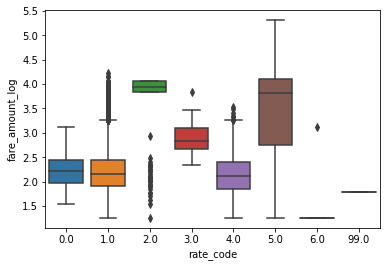

In [22]:
g = sns.boxplot(x='rate_code', y='fare_amount_log', data=data)

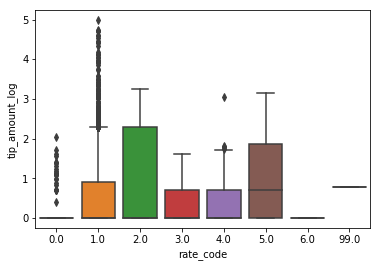

In [23]:
g = sns.boxplot(x='rate_code', y='tip_amount_log', data=data)

In [24]:
data['tip_paid'].value_counts()

0    618713
1    453197
Name: tip_paid, dtype: int64

## Feature Engineering - longtitude, latitude

In [25]:
# shape file from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
shape = gpd.read_file('Q2data/taxi_zones/taxi_zones.shp')
shape

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019, 933091.0114800561 192572.1752614765, 933088.58483..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1033439.642639145 170883.9458008111, 1033473.264747..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726, 1026495.593494505 256638.615618363, 1026567.23037..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695, 992068.6669922024 203711.5021972805, 992061.71643..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, 936046.5648079664 144173.4177987278, 936387.921896..."
5,6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,"POLYGON ((966568.7466657609 158679.854687795, 966615.255504474 158662.2924831361, 966524.8819293..."
6,7,0.107417,0.000390,Astoria,7,Queens,"POLYGON ((1010804.217962816 218919.6406951398, 1011049.164824381 218914.0828457624, 1011117.5340..."
7,8,0.027591,0.000027,Astoria Park,8,Queens,"POLYGON ((1005482.276373357 221686.4661663175, 1005304.898299307 221499.1169365644, 1004958.1865..."
8,9,0.099784,0.000338,Auburndale,9,Queens,"POLYGON ((1043803.993348822 216615.9250395149, 1043849.708385721 216473.1626471728, 1043900.7977..."
9,10,0.099839,0.000436,Baisley Park,10,Queens,"POLYGON ((1044355.071716622 190734.3208969831, 1044612.121643245 190156.8184265643, 1044849.7423..."


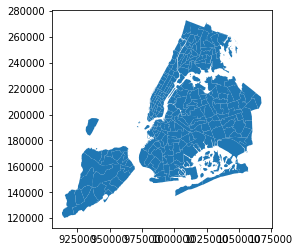

In [26]:
shape.plot();

In [27]:
# Zip the coordinates into a point object
pickup_coor = [Point(x,y) for x,y in zip(data['pickup_longitude'],data['pickup_latitude'])]

dropoff_coor = [Point(x,y) for x,y in zip(data['dropoff_longitude'],data['dropoff_latitude'])]

In [28]:
# convert data df into a geodf
data1 = gpd.GeoDataFrame(data, geometry=pickup_coor)
data1.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,tip_paid,fare_amount_log,tip_amount_log,geometry
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.80,CSH,6.5,0.00,0,2.014903,0.000000,POINT (-73.971879 40.756228)
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.50,Cre,6.9,1.88,1,2.066863,1.057790,POINT (-73.97785 40.738361)
2,CMT,2010-03-03 10:10:25+00:00,2010-03-03 10:19:38+00:00,-73.974089,40.762479,-73.990669,40.745668,1.0,1,1.60,Cre,6.9,1.00,1,2.066863,0.693147,POINT (-73.97408900000001 40.762479)
3,VTS,2012-04-17 11:51:00+00:00,2012-04-17 12:07:00+00:00,-73.979920,40.781045,-73.970415,40.765608,1.0,1,1.70,CRD,9.7,1.94,1,2.370244,1.078410,POINT (-73.97991999999998 40.781045)
4,VTS,2012-03-30 14:26:00+00:00,2012-03-30 14:36:00+00:00,-73.972975,40.761610,-73.955615,40.764290,1.0,2,1.36,CSH,6.9,0.00,0,2.066863,0.000000,POINT (-73.97297500000001 40.76161)


In [29]:
# check projection of shape file 
# projection txt file states PROJCS["NAD_1983_StatePlane_New_York_Long_Island_FIPS_3104_Feet
# NAD_1983_StatePlane_New_York_Long_Island_FIPS_3104_Feet is ESRI:102718
shape.geometry.crs

{'proj': 'lcc',
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [30]:
# re-project shape projection from ESRI:102718 to EPSG:4269 (NAD 1983; Unit: degree)
shape = shape.to_crs({'init': 'epsg:4269'})
shape

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445299999996 40.6949959999999, -74.18448899999999 40.69509499999987, -74.1844979..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((-73.82337597260663 40.63898704717672, -73.82277105438693 40.63557691408514, -73.82265..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792614099985 40.87134223399991, -73.84725144800001 40.87098705199993, -73.846992..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177410965318 40.72582128133705, -73.97179142961485 40.72581422114909, -73.971816..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17421738099989 40.56256808599989, -74.17348507999998 40.56226748999995, -74.172255..."
5,6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,"POLYGON ((-74.06367318899999 40.60219816599994, -74.06350565699998 40.60215005399992, -74.063831..."
6,7,0.107417,0.000390,Astoria,7,Queens,"POLYGON ((-73.90413637799996 40.76752031699986, -73.90325211599989 40.7675043229999, -73.9030052..."
7,8,0.027591,0.000027,Astoria Park,8,Queens,"POLYGON ((-73.92334041500001 40.77512891199993, -73.92398142899997 40.7746151119999, -73.9252324..."
8,9,0.099784,0.000338,Auburndale,9,Queens,"POLYGON ((-73.78502434699996 40.76103651599986, -73.78486059299999 40.7606443629999, -73.7846774..."
9,10,0.099839,0.000436,Baisley Park,10,Queens,"POLYGON ((-73.7832662499999 40.68999429299992, -73.78234452799988 40.68840743699996, -73.7814867..."


In [31]:
# since pickup has no projection, assign project to that of shape file
data1.crs = shape.crs
data1.crs

{'init': 'epsg:4269'}

In [32]:
# spatial join pickup with shape gdf on 'within'
data2 = gpd.sjoin(data1, shape, how='left', op='within')
data2.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,fare_amount_log,tip_amount_log,geometry,index_right,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.80,...,2.014903,0.000000,POINT (-73.971879 40.756228),161.0,162.0,0.035270,0.000048,Midtown East,162.0,Manhattan
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.50,...,2.066863,1.057790,POINT (-73.97785 40.738361),136.0,137.0,0.046108,0.000116,Kips Bay,137.0,Manhattan
2,CMT,2010-03-03 10:10:25+00:00,2010-03-03 10:19:38+00:00,-73.974089,40.762479,-73.990669,40.745668,1.0,1,1.60,...,2.066863,0.693147,POINT (-73.97408900000001 40.762479),162.0,163.0,0.034177,0.000041,Midtown North,163.0,Manhattan
3,VTS,2012-04-17 11:51:00+00:00,2012-04-17 12:07:00+00:00,-73.979920,40.781045,-73.970415,40.765608,1.0,1,1.70,...,2.370244,1.078410,POINT (-73.97991999999998 40.781045),238.0,239.0,0.063626,0.000205,Upper West Side South,239.0,Manhattan
4,VTS,2012-03-30 14:26:00+00:00,2012-03-30 14:36:00+00:00,-73.972975,40.761610,-73.955615,40.764290,1.0,2,1.36,...,2.066863,0.000000,POINT (-73.97297500000001 40.76161),160.0,161.0,0.035804,0.000072,Midtown Center,161.0,Manhattan


In [33]:
data2.dtypes

vendor_id             object
pickup_datetime       object
dropoff_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
rate_code            float64
passenger_count        int64
trip_distance        float64
payment_type          object
fare_amount          float64
tip_amount           float64
tip_paid               int64
fare_amount_log      float64
tip_amount_log       float64
geometry              object
index_right          float64
OBJECTID             float64
Shape_Leng           float64
Shape_Area           float64
zone                  object
LocationID           float64
borough               object
dtype: object

In [34]:
# count number of isnull values
data2.borough.isnull().sum()

521

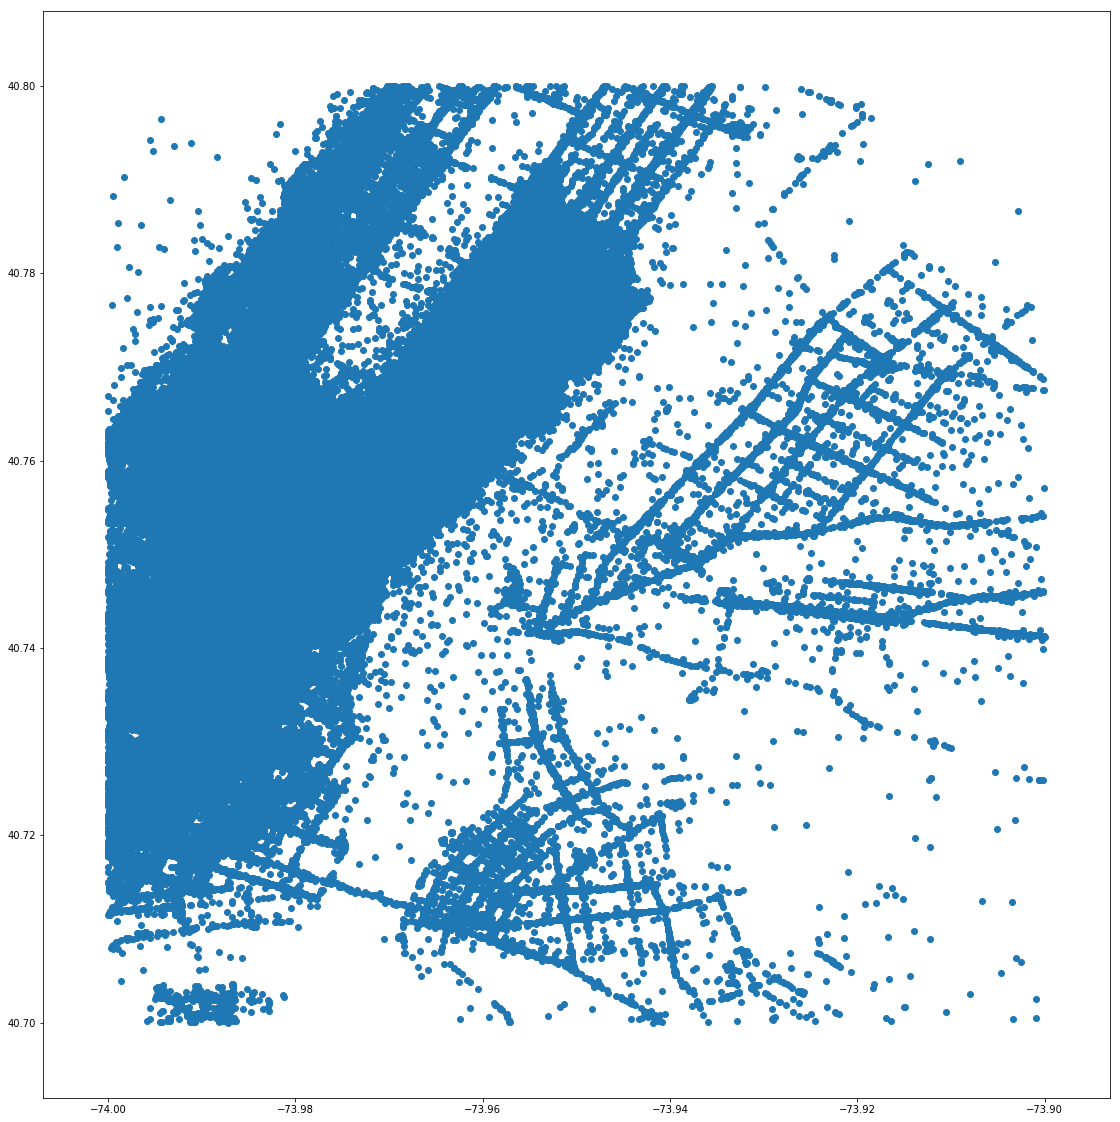

In [35]:
# pickup 
data2.plot(figsize=(30,20));

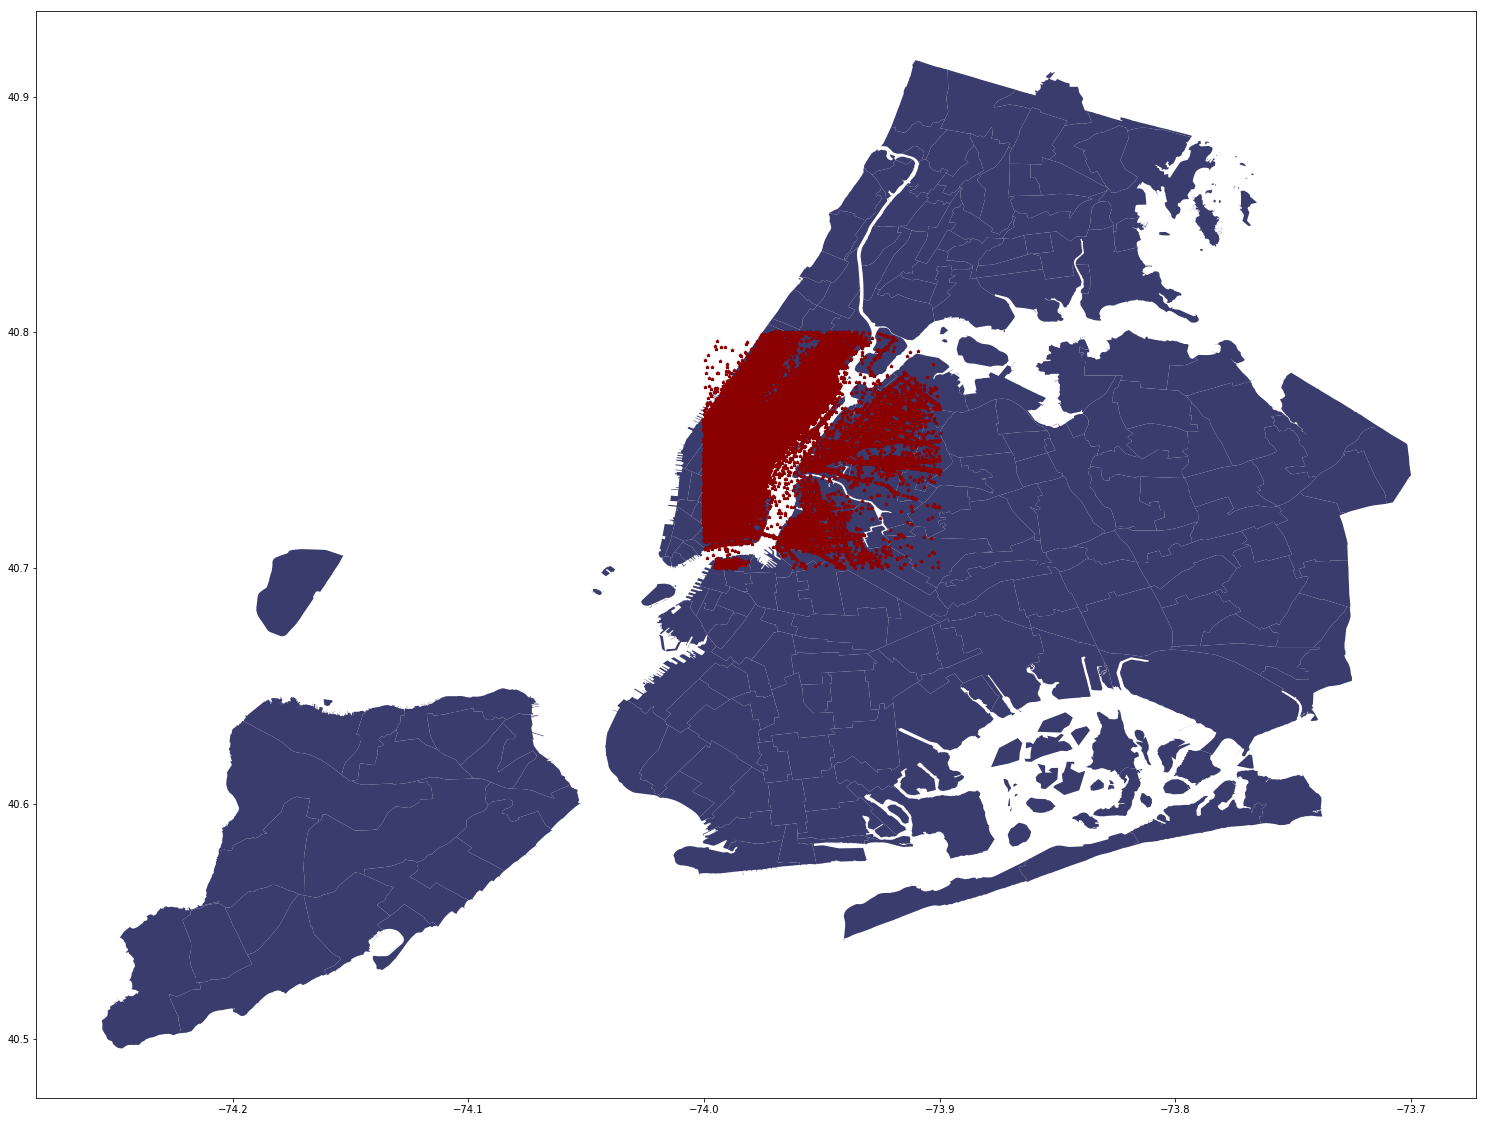

In [36]:
# base plot of taxi shape file
fig, ax = plt.subplots(1, figsize=(30,20))
base = shape.plot(ax=ax, color='#3B3C6E')

# plotting the pickup position on top with red color to stand out:
data2.plot(ax=base, color='darkred', marker="*", markersize=10);

In [37]:
data2['borough'].value_counts()

Manhattan    1051350
Queens         10710
Brooklyn        9329
Name: borough, dtype: int64

In [38]:
data2['zone'].value_counts()

Upper East Side South               55469
Upper East Side North               50175
Midtown Center                      49423
Midtown East                        46604
Murray Hill                         45868
Times Sq/Theatre District           44181
East Village                        43931
Lincoln Square East                 41847
Union Sq                            41669
Clinton East                        41484
Penn Station/Madison Sq West        40490
Gramercy                            37589
Midtown North                       36913
Lenox Hill West                     36149
Upper West Side South               33997
Midtown South                       31254
Sutton Place/Turtle Bay North       29502
Yorkville West                      24967
Lenox Hill East                     24129
Garment District                    23889
Greenwich Village North             22605
Upper West Side North               22084
Flatiron                            21018
UN/Turtle Bay South               

In [39]:
data2['LocationID'].value_counts()

237.0    55469
236.0    50175
161.0    49423
162.0    46604
170.0    45868
230.0    44181
79.0     43931
142.0    41847
234.0    41669
48.0     41484
186.0    40490
107.0    37589
163.0    36913
141.0    36149
239.0    33997
164.0    31254
229.0    29502
263.0    24967
140.0    24129
100.0    23889
113.0    22605
238.0    22084
90.0     21018
233.0    20869
43.0     19254
137.0    18697
148.0    18466
262.0    16787
143.0    15180
144.0    14394
         ...  
74.0      1888
45.0      1415
145.0     1405
80.0      1181
112.0     1077
146.0     1077
179.0     1048
223.0      780
66.0       601
260.0      584
24.0       508
193.0      426
41.0       279
37.0       276
65.0       134
202.0      127
36.0       118
33.0        99
217.0       86
194.0       71
17.0        20
8.0         17
198.0       17
157.0       15
231.0        4
83.0         3
209.0        3
207.0        3
160.0        1
34.0         1
Name: LocationID, Length: 75, dtype: int64

In [40]:
# delete unnecessary columns
data3 = data2.drop(['index_right','OBJECTID','Shape_Leng','Shape_Area'], axis=1)
data3.head(2)

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,tip_paid,fare_amount_log,tip_amount_log,geometry,zone,LocationID,borough
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.8,CSH,6.5,0.00,0,2.014903,0.00000,POINT (-73.971879 40.756228),Midtown East,162.0,Manhattan
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.5,Cre,6.9,1.88,1,2.066863,1.05779,POINT (-73.97785 40.738361),Kips Bay,137.0,Manhattan


In [41]:
# rename cols
data4 = data3.rename(columns={'geometry':'pickup_geom','zone':'pickup_zone','LocationID':'pickup_LocationID','borough':'pickup_borough'})
data4.head(2)

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,tip_paid,fare_amount_log,tip_amount_log,pickup_geom,pickup_zone,pickup_LocationID,pickup_borough
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.8,CSH,6.5,0.00,0,2.014903,0.00000,POINT (-73.971879 40.756228),Midtown East,162.0,Manhattan
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.5,Cre,6.9,1.88,1,2.066863,1.05779,POINT (-73.97785 40.738361),Kips Bay,137.0,Manhattan


In [42]:
# change from integer to string
data4['pickup_LocationID'] = data4['pickup_LocationID'].astype(str)
data4.dtypes

vendor_id             object
pickup_datetime       object
dropoff_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
rate_code            float64
passenger_count        int64
trip_distance        float64
payment_type          object
fare_amount          float64
tip_amount           float64
tip_paid               int64
fare_amount_log      float64
tip_amount_log       float64
pickup_geom           object
pickup_zone           object
pickup_LocationID     object
pickup_borough        object
dtype: object

In [43]:
# convert df into a geodf
data5 = gpd.GeoDataFrame(data4, geometry=dropoff_coor)
data5.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,fare_amount,tip_amount,tip_paid,fare_amount_log,tip_amount_log,pickup_geom,pickup_zone,pickup_LocationID,pickup_borough,geometry
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.80,...,6.5,0.00,0,2.014903,0.000000,POINT (-73.971879 40.756228),Midtown East,162.0,Manhattan,POINT (-73.971428 40.764175)
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.50,...,6.9,1.88,1,2.066863,1.057790,POINT (-73.97785 40.738361),Kips Bay,137.0,Manhattan,POINT (-73.977073 40.754229)
2,CMT,2010-03-03 10:10:25+00:00,2010-03-03 10:19:38+00:00,-73.974089,40.762479,-73.990669,40.745668,1.0,1,1.60,...,6.9,1.00,1,2.066863,0.693147,POINT (-73.97408900000001 40.762479),Midtown North,163.0,Manhattan,POINT (-73.990669 40.745668)
3,VTS,2012-04-17 11:51:00+00:00,2012-04-17 12:07:00+00:00,-73.979920,40.781045,-73.970415,40.765608,1.0,1,1.70,...,9.7,1.94,1,2.370244,1.078410,POINT (-73.97991999999998 40.781045),Upper West Side South,239.0,Manhattan,POINT (-73.970415 40.765608)
4,VTS,2012-03-30 14:26:00+00:00,2012-03-30 14:36:00+00:00,-73.972975,40.761610,-73.955615,40.764290,1.0,2,1.36,...,6.9,0.00,0,2.066863,0.000000,POINT (-73.97297500000001 40.76161),Midtown Center,161.0,Manhattan,POINT (-73.95561500000002 40.76429)


In [44]:
# since dropoff has no projection, assign project to that of shape file
data5.crs = shape.crs
data5.crs

{'init': 'epsg:4269'}

In [45]:
# spatial join dropoff with shape gdf on 'within'
data6 = gpd.sjoin(data5, shape, how='left', op='within')
data6.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,pickup_LocationID,pickup_borough,geometry,index_right,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.80,...,162.0,Manhattan,POINT (-73.971428 40.764175),236.0,237.0,0.042213,0.000096,Upper East Side South,237.0,Manhattan
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.50,...,137.0,Manhattan,POINT (-73.977073 40.754229),160.0,161.0,0.035804,0.000072,Midtown Center,161.0,Manhattan
2,CMT,2010-03-03 10:10:25+00:00,2010-03-03 10:19:38+00:00,-73.974089,40.762479,-73.990669,40.745668,1.0,1,1.60,...,163.0,Manhattan,POINT (-73.990669 40.745668),233.0,234.0,0.036072,0.000073,Union Sq,234.0,Manhattan
3,VTS,2012-04-17 11:51:00+00:00,2012-04-17 12:07:00+00:00,-73.979920,40.781045,-73.970415,40.765608,1.0,1,1.70,...,239.0,Manhattan,POINT (-73.970415 40.765608),236.0,237.0,0.042213,0.000096,Upper East Side South,237.0,Manhattan
4,VTS,2012-03-30 14:26:00+00:00,2012-03-30 14:36:00+00:00,-73.972975,40.761610,-73.955615,40.764290,1.0,2,1.36,...,161.0,Manhattan,POINT (-73.95561500000002 40.76429),139.0,140.0,0.047584,0.000114,Lenox Hill East,140.0,Manhattan


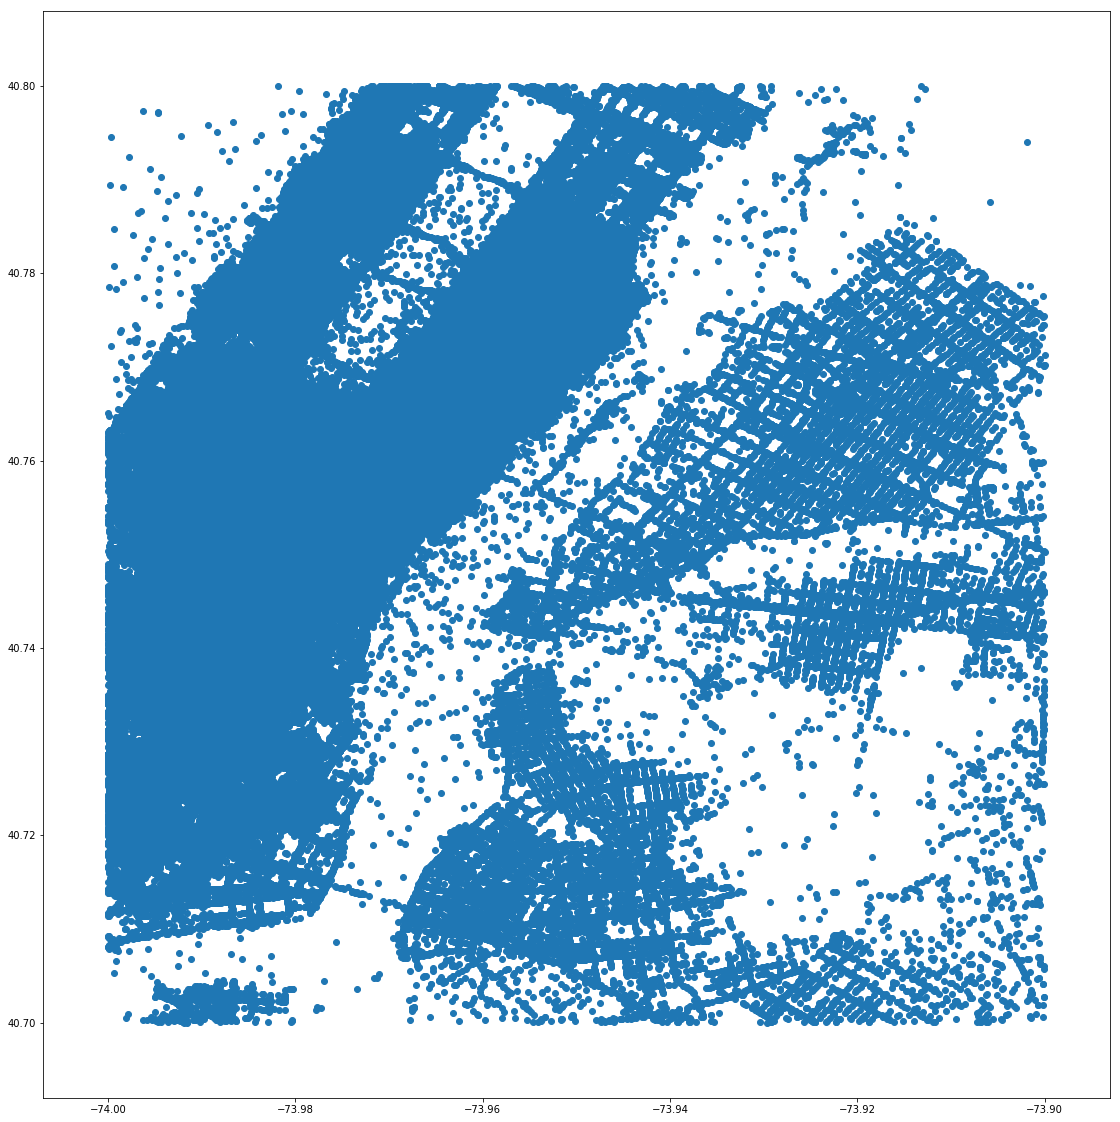

In [46]:
# dropoff
data6.plot(figsize=(30,20));

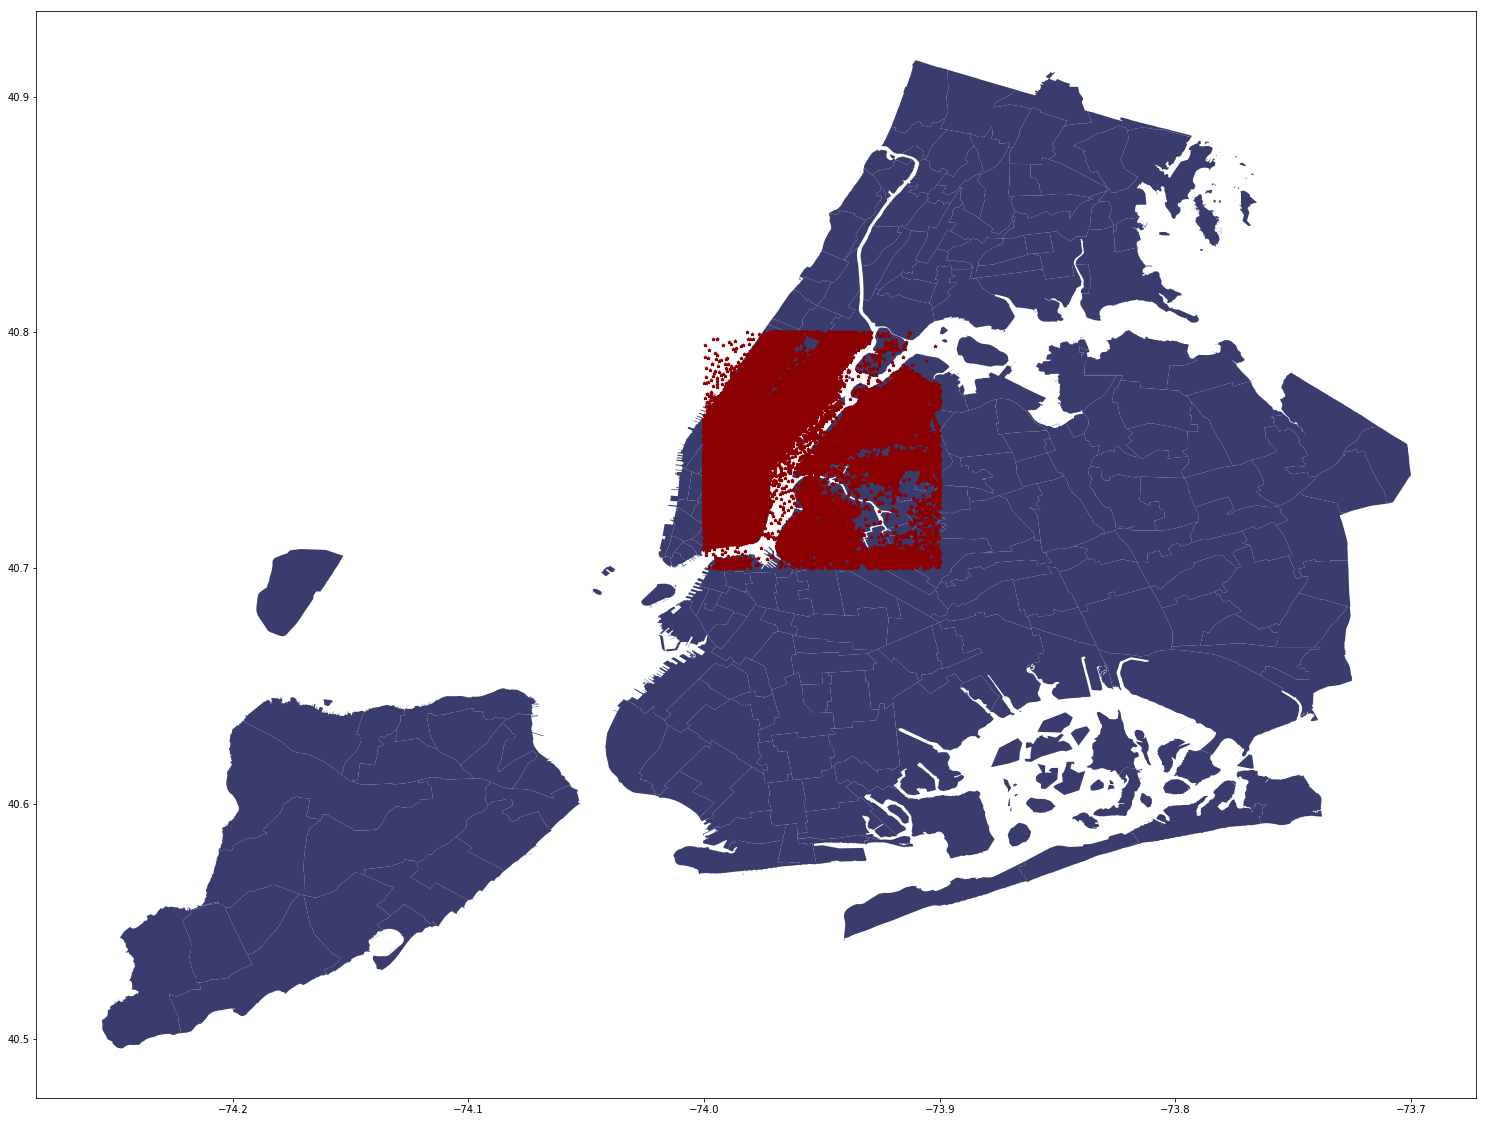

In [47]:
# base plot of taxi shape file
fig, ax = plt.subplots(1, figsize=(30,20))
base = shape.plot(ax=ax, color='#3B3C6E')

# plotting the dropoff position on top with red color to stand out:
data6.plot(ax=base, color='darkred', marker="*", markersize=10);

In [48]:
# delete unnecessary columns
data7 = data6.drop(['index_right','OBJECTID','Shape_Leng','Shape_Area'], axis=1)
data7.head(2)

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,fare_amount_log,tip_amount_log,pickup_geom,pickup_zone,pickup_LocationID,pickup_borough,geometry,zone,LocationID,borough
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.8,...,2.014903,0.00000,POINT (-73.971879 40.756228),Midtown East,162.0,Manhattan,POINT (-73.971428 40.764175),Upper East Side South,237.0,Manhattan
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.5,...,2.066863,1.05779,POINT (-73.97785 40.738361),Kips Bay,137.0,Manhattan,POINT (-73.977073 40.754229),Midtown Center,161.0,Manhattan


In [49]:
# rename cols
data8 = data7.rename(columns={'geometry':'dropoff_geom','zone':'dropoff_zone','LocationID':'dropoff_LocationID','borough':'dropoff_borough'})
data8.head(2)

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,fare_amount_log,tip_amount_log,pickup_geom,pickup_zone,pickup_LocationID,pickup_borough,dropoff_geom,dropoff_zone,dropoff_LocationID,dropoff_borough
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.8,...,2.014903,0.00000,POINT (-73.971879 40.756228),Midtown East,162.0,Manhattan,POINT (-73.971428 40.764175),Upper East Side South,237.0,Manhattan
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.5,...,2.066863,1.05779,POINT (-73.97785 40.738361),Kips Bay,137.0,Manhattan,POINT (-73.977073 40.754229),Midtown Center,161.0,Manhattan


In [50]:
# change data type
data8['dropoff_LocationID'] = data8['dropoff_LocationID'].astype(str)
data8.dtypes

vendor_id              object
pickup_datetime        object
dropoff_datetime       object
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
rate_code             float64
passenger_count         int64
trip_distance         float64
payment_type           object
fare_amount           float64
tip_amount            float64
tip_paid                int64
fare_amount_log       float64
tip_amount_log        float64
pickup_geom            object
pickup_zone            object
pickup_LocationID      object
pickup_borough         object
dropoff_geom           object
dropoff_zone           object
dropoff_LocationID     object
dropoff_borough        object
dtype: object

[Text(0,0,'Midtown East'),
 Text(0,0,'Kips Bay'),
 Text(0,0,'Midtown North'),
 Text(0,0,'Upper West Side South'),
 Text(0,0,'Midtown Center'),
 Text(0,0,'Little Italy/NoLiTa'),
 Text(0,0,'Clinton West'),
 Text(0,0,'Lincoln Square East'),
 Text(0,0,'Sutton Place/Turtle Bay North'),
 Text(0,0,'Lenox Hill West'),
 Text(0,0,'Penn Station/Madison Sq West'),
 Text(0,0,'Garment District'),
 Text(0,0,'Murray Hill'),
 Text(0,0,'Upper East Side North'),
 Text(0,0,'Gramercy'),
 Text(0,0,'Union Sq'),
 Text(0,0,'Clinton East'),
 Text(0,0,'Yorkville West'),
 Text(0,0,'Lower East Side'),
 Text(0,0,'Midtown South'),
 Text(0,0,'Lenox Hill East'),
 Text(0,0,'Times Sq/Theatre District'),
 Text(0,0,'Greenwich Village South'),
 Text(0,0,'Alphabet City'),
 Text(0,0,'Yorkville East'),
 Text(0,0,'Central Park'),
 Text(0,0,'UN/Turtle Bay South'),
 Text(0,0,'Greenwich Village North'),
 Text(0,0,'East Chelsea'),
 Text(0,0,'Manhattan Valley'),
 Text(0,0,'Two Bridges/Seward Park'),
 Text(0,0,'Upper West Side North

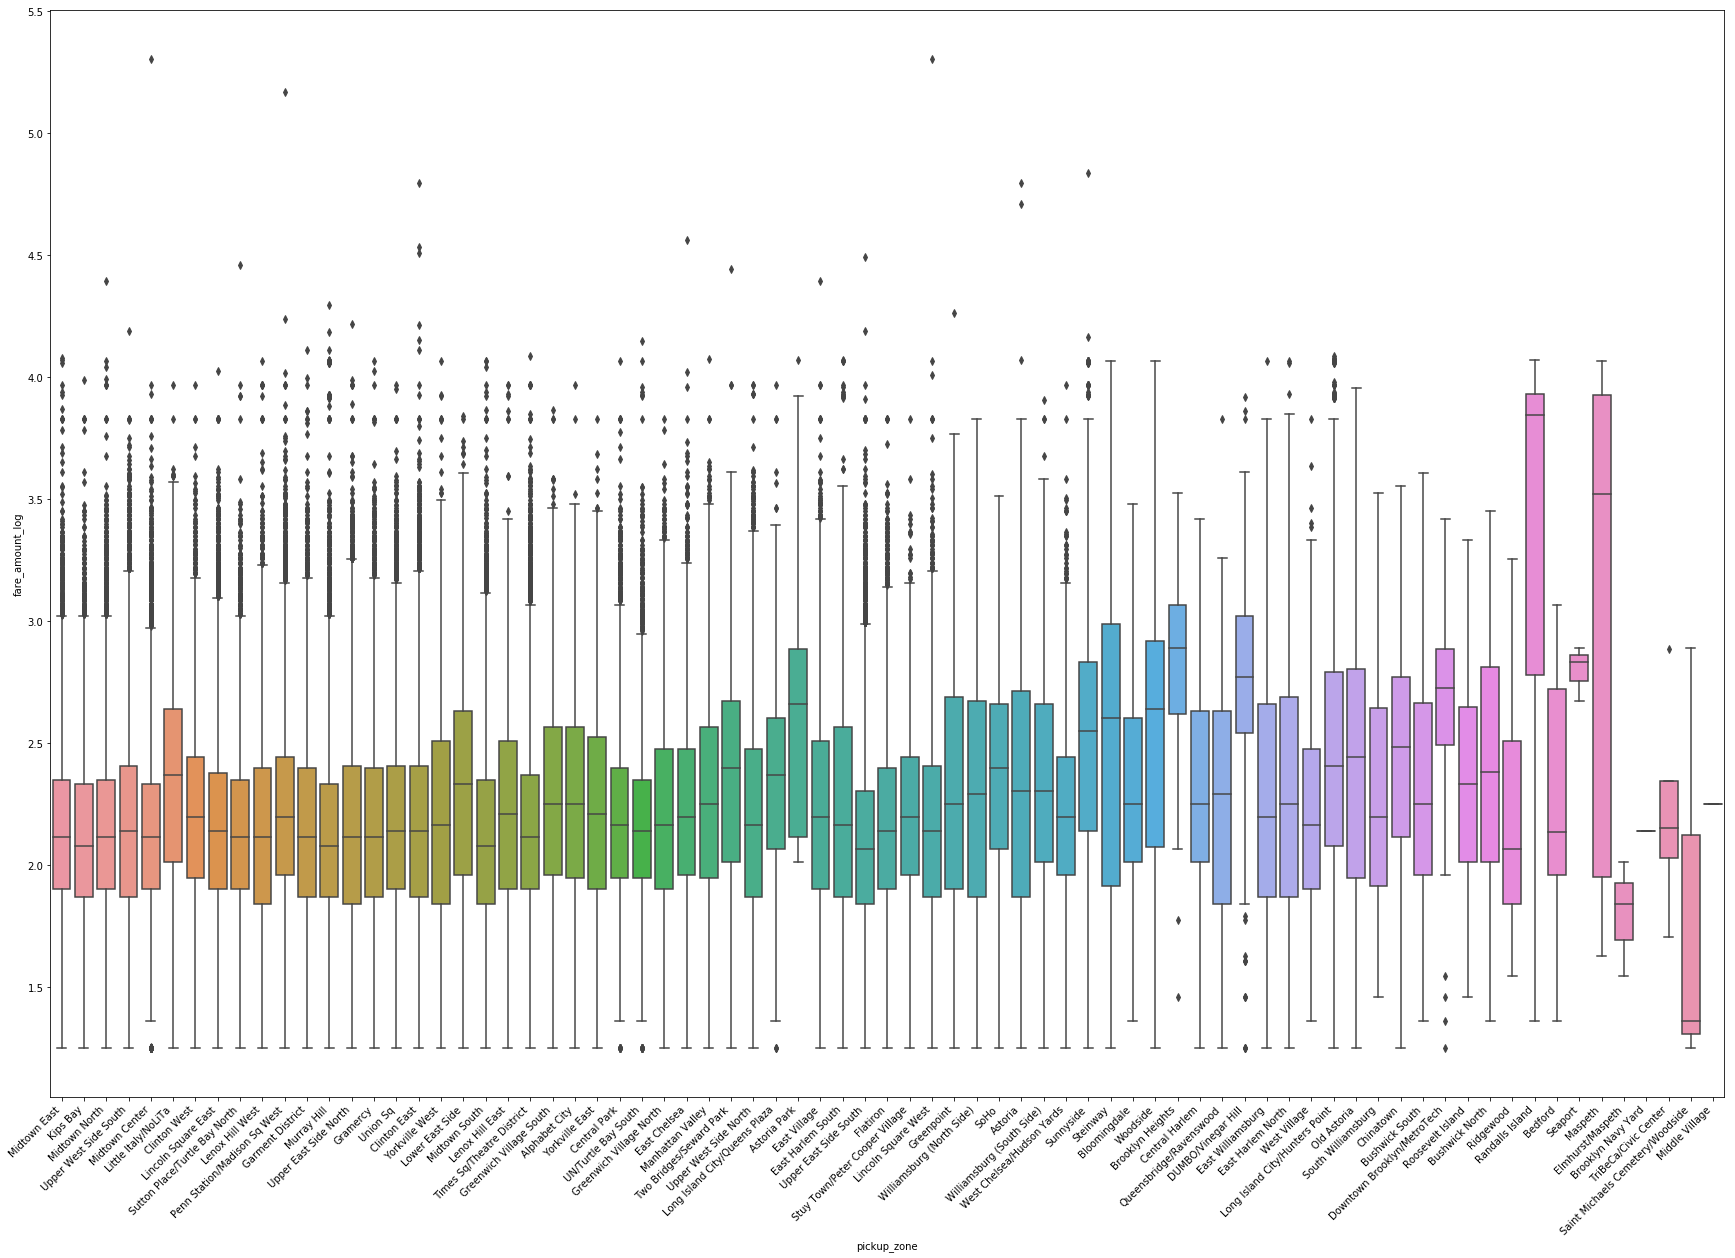

In [51]:
plt.figure(figsize=(30,20))
g = sns.boxplot(x='pickup_zone', y='fare_amount_log', data=data8)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0,0,'Midtown East'),
 Text(0,0,'Kips Bay'),
 Text(0,0,'Midtown North'),
 Text(0,0,'Upper West Side South'),
 Text(0,0,'Midtown Center'),
 Text(0,0,'Little Italy/NoLiTa'),
 Text(0,0,'Clinton West'),
 Text(0,0,'Lincoln Square East'),
 Text(0,0,'Sutton Place/Turtle Bay North'),
 Text(0,0,'Lenox Hill West'),
 Text(0,0,'Penn Station/Madison Sq West'),
 Text(0,0,'Garment District'),
 Text(0,0,'Murray Hill'),
 Text(0,0,'Upper East Side North'),
 Text(0,0,'Gramercy'),
 Text(0,0,'Union Sq'),
 Text(0,0,'Clinton East'),
 Text(0,0,'Yorkville West'),
 Text(0,0,'Lower East Side'),
 Text(0,0,'Midtown South'),
 Text(0,0,'Lenox Hill East'),
 Text(0,0,'Times Sq/Theatre District'),
 Text(0,0,'Greenwich Village South'),
 Text(0,0,'Alphabet City'),
 Text(0,0,'Yorkville East'),
 Text(0,0,'Central Park'),
 Text(0,0,'UN/Turtle Bay South'),
 Text(0,0,'Greenwich Village North'),
 Text(0,0,'East Chelsea'),
 Text(0,0,'Manhattan Valley'),
 Text(0,0,'Two Bridges/Seward Park'),
 Text(0,0,'Upper West Side North

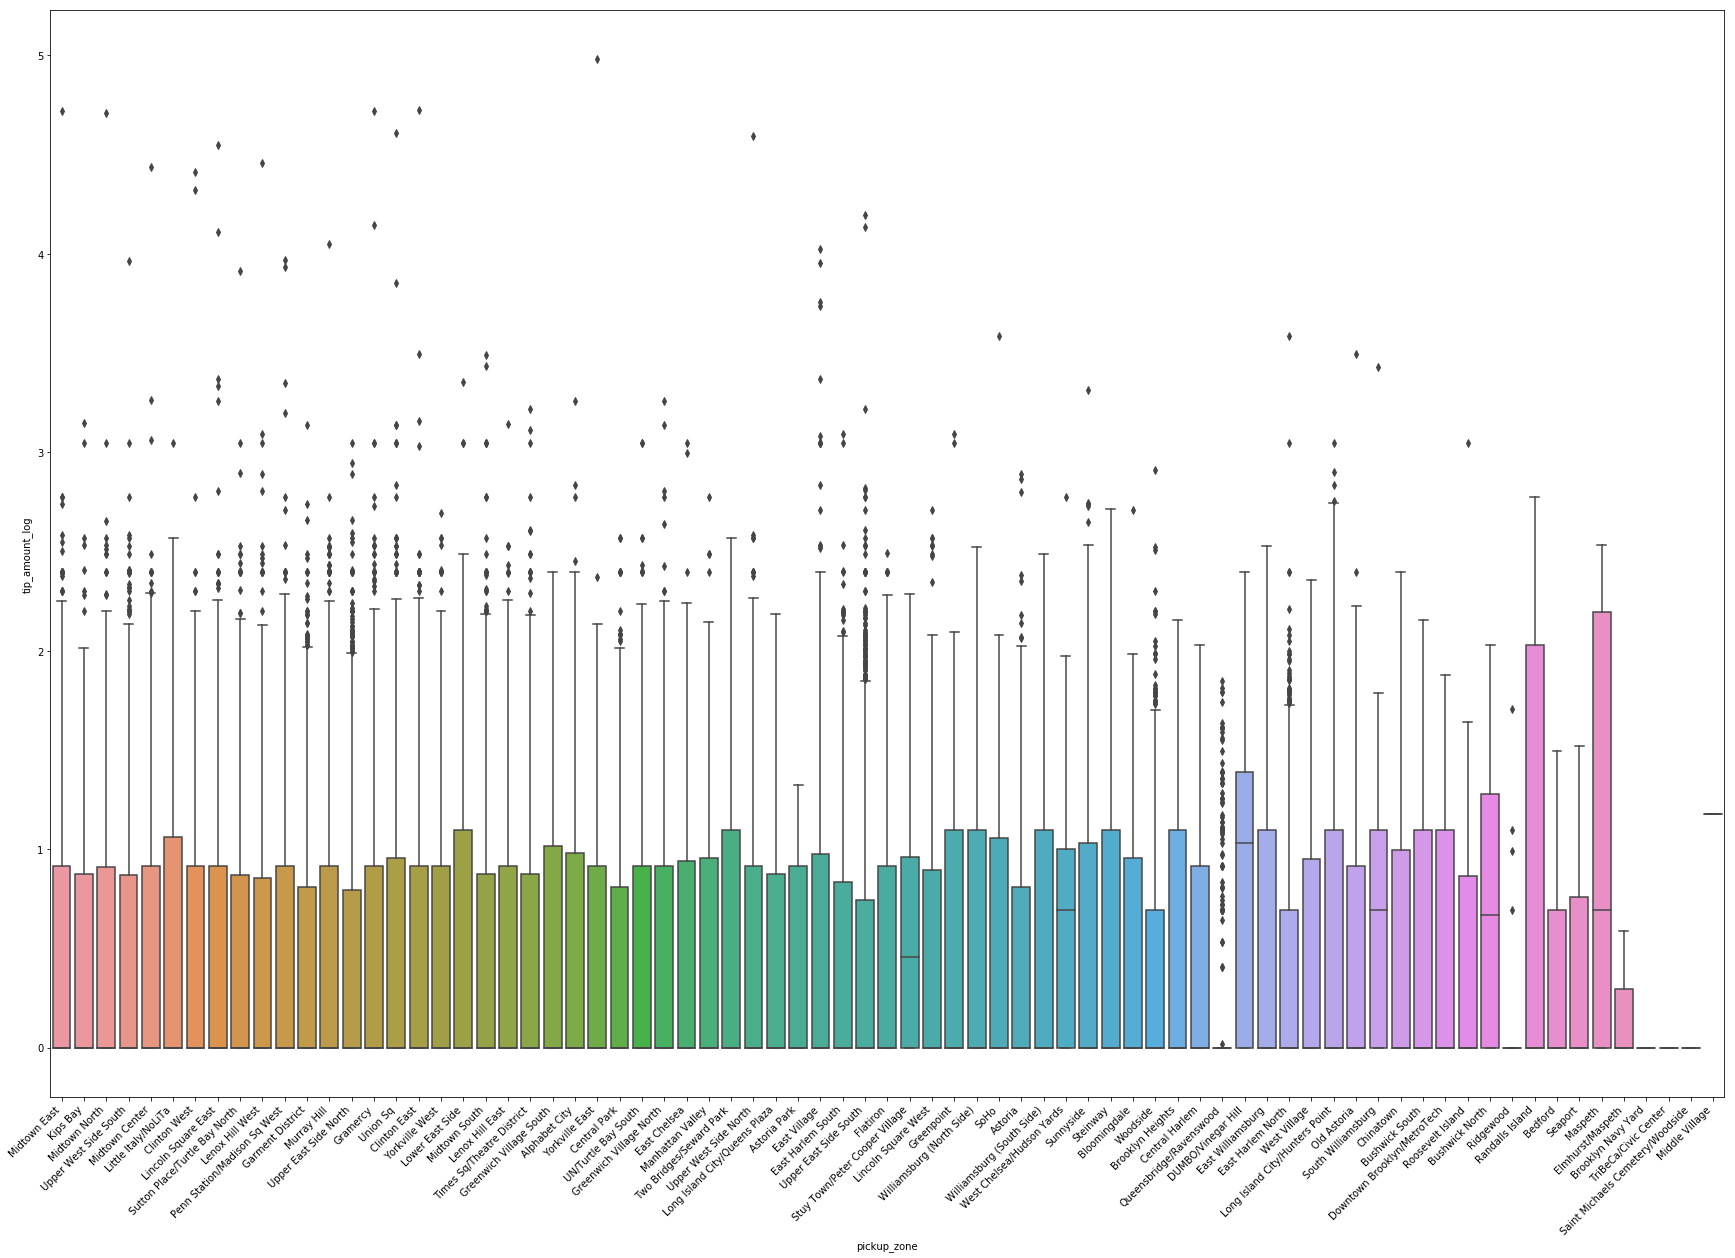

In [52]:
plt.figure(figsize=(30,20))
g = sns.boxplot(x='pickup_zone', y='tip_amount_log', data=data8)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

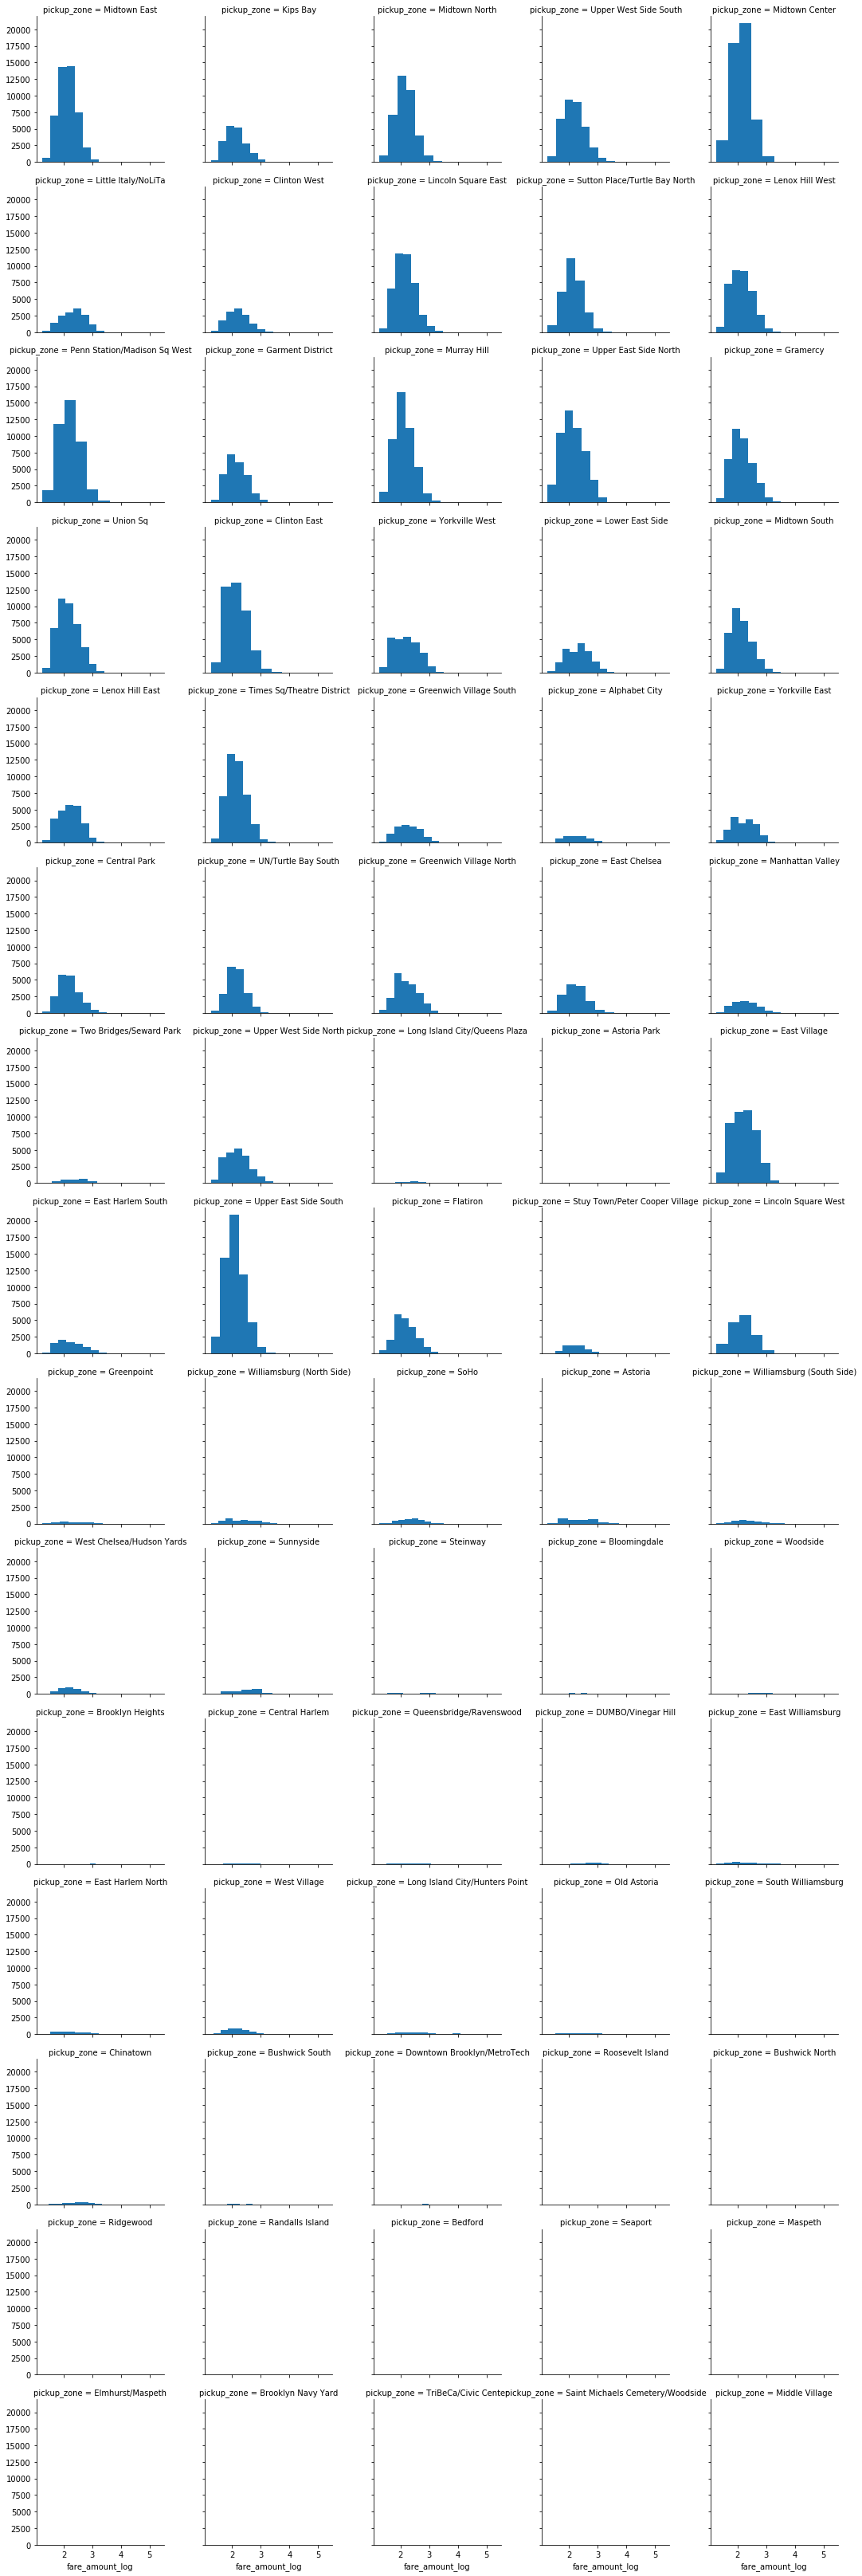

In [53]:
g = sns.FacetGrid(data8, col='pickup_zone', col_wrap=5)
g = g.map(plt.hist, 'fare_amount_log')

In [54]:
# if trip starts and ends in the same zone
data8['same_zone'] = np.where(data8['pickup_LocationID'] == data8['dropoff_LocationID'],1,0)
data8['same_zone'].value_counts()

0    1024261
1      47649
Name: same_zone, dtype: int64

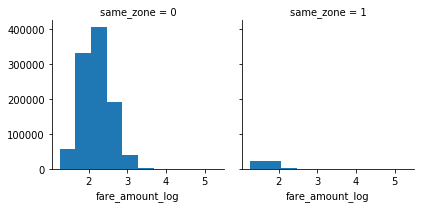

In [55]:
g = sns.FacetGrid(data8, col='same_zone')
g = g.map(plt.hist, 'fare_amount_log')

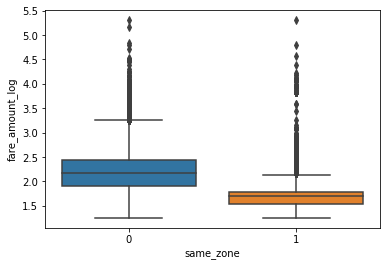

In [56]:
g = sns.boxplot(x='same_zone', y='fare_amount_log', data=data8)

In [57]:
# if trip starts and ends in the same borough
data8['same_borough'] = np.where(data8['pickup_borough'] == data8['dropoff_borough'],1,0)
data8['same_borough'].value_counts()

1    1029449
0      42461
Name: same_borough, dtype: int64

In [1]:
g = sns.boxplot(x='same_borough', y='fare_amount_log', data=data8)

NameError: name 'sns' is not defined

In [59]:
# divide pickup longitude into 5 buckets
# use cut over qcut for lat long because we need to divide the coordinates by the latlong positions
# default labels = True to know the identity of the buckets first
data8['pickup_long'] = pd.cut(data8['pickup_longitude'],5) 
data8['pickup_long'].value_counts()

(-74.0, -73.98]     530976
(-73.98, -73.96]    382100
(-73.96, -73.94]    148271
(-73.94, -73.92]      7348
(-73.92, -73.9]       3215
Name: pickup_long, dtype: int64

In [60]:
# divide pickup longitude into 5 buckets
# use cut over qcut for lat long because we need to divide the coordinates by the latlong positions
# labels = False for column name simplicity
data8['pickup_long'] = pd.cut(data8['pickup_longitude'],5,labels=False) 
data8['pickup_long'].value_counts()

0    530976
1    382100
2    148271
3      7348
4      3215
Name: pickup_long, dtype: int64

In [61]:
# divide pickup latitude into 5 buckets
# default labels = True to know the identity of the buckets first
data8['pickup_lat'] = pd.cut(data8['pickup_latitude'],5)
data8['pickup_lat'].value_counts()

(40.74, 40.76]    387234
(40.76, 40.78]    374617
(40.72, 40.74]    175923
(40.78, 40.8]     110720
(40.7, 40.72]      23416
Name: pickup_lat, dtype: int64

In [62]:
# divide pickup latitude into 5 buckets
# labels = False for column name simplicity
data8['pickup_lat'] = pd.cut(data8['pickup_latitude'],5,labels=False)
data8['pickup_lat'].value_counts()

2    387234
3    374617
1    175923
4    110720
0     23416
Name: pickup_lat, dtype: int64

In [63]:
# divide dropoff longitude into 5 buckets
# default labels = True to know the identity of the buckets first
data8['dropoff_long'] = pd.cut(data8['dropoff_longitude'],5)
data8['dropoff_long'].value_counts()

(-74.0, -73.98]     490795
(-73.98, -73.96]    392671
(-73.96, -73.94]    164721
(-73.94, -73.92]     14284
(-73.92, -73.9]       9439
Name: dropoff_long, dtype: int64

In [64]:
# divide dropoff longitude into 5 buckets
# labels = False for column name simplicity
data8['dropoff_long'] = pd.cut(data8['dropoff_longitude'],5,labels=False)
data8['dropoff_long'].value_counts()

0    490795
1    392671
2    164721
3     14284
4      9439
Name: dropoff_long, dtype: int64

In [65]:
# divide dropoff latitude into 5 buckets
# default labels = True to know the identity of the buckets first
data8['dropoff_lat'] = pd.cut(data8['dropoff_latitude'],5)
data8['dropoff_lat'].value_counts()

(40.74, 40.76]    382648
(40.76, 40.78]    368886
(40.72, 40.74]    164185
(40.78, 40.8]     124658
(40.7, 40.72]      31533
Name: dropoff_lat, dtype: int64

In [66]:
# divide dropoff latitude into 5 buckets
# labels = False for column name simplicity
data8['dropoff_lat'] = pd.cut(data8['dropoff_latitude'],5,labels=False)
data8['dropoff_lat'].value_counts()

2    382648
3    368886
1    164185
4    124658
0     31533
Name: dropoff_lat, dtype: int64

In [67]:
data8['pickup_long'].astype('str')

0          1
1          1
2          1
3          1
4          1
5          0
6          1
7          0
8          0
9          1
10         2
11         1
12         0
13         1
14         0
15         1
16         0
17         1
18         1
19         1
20         2
21         2
22         0
23         0
24         0
25         0
26         0
27         1
28         2
29         0
          ..
1071880    3
1071881    1
1071882    1
1071883    0
1071884    0
1071885    0
1071886    0
1071887    1
1071888    1
1071889    1
1071890    0
1071891    1
1071892    0
1071893    2
1071894    0
1071895    1
1071896    0
1071897    0
1071898    0
1071899    0
1071900    2
1071901    0
1071902    1
1071903    0
1071904    2
1071905    0
1071906    0
1071907    2
1071908    2
1071909    1
Name: pickup_long, Length: 1071910, dtype: object

In [68]:
data8['pickup_lat'].astype('str')

0          2
1          1
2          3
3          4
4          3
5          0
6          2
7          3
8          3
9          2
10         3
11         2
12         2
13         2
14         2
15         4
16         4
17         2
18         2
19         3
20         4
21         4
22         1
23         1
24         2
25         2
26         2
27         2
28         3
29         0
          ..
1071880    3
1071881    3
1071882    3
1071883    2
1071884    1
1071885    1
1071886    1
1071887    3
1071888    3
1071889    3
1071890    2
1071891    3
1071892    3
1071893    3
1071894    3
1071895    3
1071896    3
1071897    1
1071898    1
1071899    3
1071900    3
1071901    1
1071902    1
1071903    1
1071904    3
1071905    3
1071906    2
1071907    4
1071908    3
1071909    2
Name: pickup_lat, Length: 1071910, dtype: object

In [69]:
data8['dropoff_long'].astype('str')

0          1
1          1
2          0
3          1
4          2
5          1
6          0
7          0
8          2
9          0
10         1
11         0
12         0
13         0
14         0
15         0
16         1
17         0
18         1
19         2
20         1
21         0
22         0
23         1
24         1
25         0
26         1
27         1
28         2
29         1
          ..
1071880    2
1071881    0
1071882    0
1071883    0
1071884    0
1071885    0
1071886    0
1071887    1
1071888    3
1071889    0
1071890    1
1071891    2
1071892    1
1071893    0
1071894    0
1071895    0
1071896    2
1071897    0
1071898    0
1071899    0
1071900    1
1071901    2
1071902    2
1071903    0
1071904    0
1071905    1
1071906    0
1071907    1
1071908    2
1071909    0
Name: dropoff_long, Length: 1071910, dtype: object

In [70]:
data8['dropoff_lat'].astype('str')

0          3
1          2
2          2
3          3
4          3
5          3
6          2
7          2
8          3
9          2
10         3
11         2
12         3
13         1
14         2
15         4
16         4
17         2
18         3
19         0
20         4
21         2
22         1
23         1
24         3
25         1
26         2
27         3
28         3
29         2
          ..
1071880    2
1071881    2
1071882    2
1071883    3
1071884    2
1071885    2
1071886    2
1071887    3
1071888    4
1071889    2
1071890    2
1071891    4
1071892    3
1071893    1
1071894    2
1071895    2
1071896    4
1071897    1
1071898    1
1071899    2
1071900    4
1071901    3
1071902    2
1071903    1
1071904    2
1071905    3
1071906    3
1071907    2
1071908    3
1071909    2
Name: dropoff_lat, Length: 1071910, dtype: object

## Feature Cross

In [71]:
# constructs a 5x5 grid for pickup via cartesian product of long x lat
# list(data_set.itertuples(index=False, name=None))
data8['pickup_longxlat'] = list(data8[['pickup_long','pickup_lat']].itertuples(index=False, name=None))

In [72]:
data8[['pickup_long','pickup_lat']]

,pickup_long,pickup_lat
0,1,2
1,1,1
2,1,3
3,1,4
4,1,3
5,0,0
6,1,2
7,0,3
8,0,3
9,1,2


In [73]:
data8.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,dropoff_zone,dropoff_LocationID,dropoff_borough,same_zone,same_borough,pickup_long,pickup_lat,dropoff_long,dropoff_lat,pickup_longxlat
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.80,...,Upper East Side South,237.0,Manhattan,0,1,1,2,1,3,"(1, 2)"
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.50,...,Midtown Center,161.0,Manhattan,0,1,1,1,1,2,"(1, 1)"
2,CMT,2010-03-03 10:10:25+00:00,2010-03-03 10:19:38+00:00,-73.974089,40.762479,-73.990669,40.745668,1.0,1,1.60,...,Union Sq,234.0,Manhattan,0,1,1,3,0,2,"(1, 3)"
3,VTS,2012-04-17 11:51:00+00:00,2012-04-17 12:07:00+00:00,-73.979920,40.781045,-73.970415,40.765608,1.0,1,1.70,...,Upper East Side South,237.0,Manhattan,0,1,1,4,1,3,"(1, 4)"
4,VTS,2012-03-30 14:26:00+00:00,2012-03-30 14:36:00+00:00,-73.972975,40.761610,-73.955615,40.764290,1.0,2,1.36,...,Lenox Hill East,140.0,Manhattan,0,1,1,3,2,3,"(1, 3)"


In [74]:
data8['pickup_longxlat'].value_counts()

(0, 2)    223206
(0, 1)    161545
(1, 2)    157070
(1, 3)    153622
(0, 3)    120381
(2, 3)     96623
(1, 4)     56748
(2, 4)     42915
(0, 0)     16084
(1, 1)     12636
(0, 4)      9760
(2, 0)      4912
(3, 2)      2927
(3, 3)      2678
(2, 2)      2255
(1, 0)      2024
(4, 2)      1776
(2, 1)      1566
(4, 3)      1313
(3, 4)      1257
(3, 0)       366
(3, 1)       120
(4, 1)        56
(4, 4)        40
(4, 0)        30
Name: pickup_longxlat, dtype: int64

In [75]:
# constructs a 5x5 grid for dropoff via cartesian product of long x lat
data8['dropoff_longxlat'] = list(data8[['dropoff_long','dropoff_lat']].itertuples(index=False, name=None))

In [76]:
data8[['dropoff_long','dropoff_lat']]

,dropoff_long,dropoff_lat
0,1,3
1,1,2
2,0,2
3,1,3
4,2,3
5,1,3
6,0,2
7,0,2
8,2,3
9,0,2


In [77]:
data8['dropoff_longxlat'].value_counts()

(0, 2)    212713
(1, 2)    158098
(1, 3)    149007
(0, 1)    140534
(0, 3)    111501
(2, 3)     99314
(1, 4)     62431
(2, 4)     48982
(1, 1)     17855
(0, 0)     16454
(0, 4)      9593
(2, 0)      7611
(1, 0)      5280
(4, 3)      4658
(2, 1)      4647
(3, 3)      4406
(3, 2)      4247
(2, 2)      4167
(4, 2)      3423
(3, 4)      3294
(3, 0)      1580
(3, 1)       757
(4, 0)       608
(4, 1)       392
(4, 4)       358
Name: dropoff_longxlat, dtype: int64

In [78]:
# constructs a 25x25 grid for pickup and dropoff so that relative distance travelled across the grid can be captured
# cartesian product of pickup longlat (from) x dropoff longlat (to)
data8['pickup_x_dropoff'] = list(data8[['pickup_longxlat','dropoff_longxlat']].itertuples(index=False, name=None))

In [79]:
data8.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,dropoff_borough,same_zone,same_borough,pickup_long,pickup_lat,dropoff_long,dropoff_lat,pickup_longxlat,dropoff_longxlat,pickup_x_dropoff
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.80,...,Manhattan,0,1,1,2,1,3,"(1, 2)","(1, 3)","((1, 2), (1, 3))"
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.50,...,Manhattan,0,1,1,1,1,2,"(1, 1)","(1, 2)","((1, 1), (1, 2))"
2,CMT,2010-03-03 10:10:25+00:00,2010-03-03 10:19:38+00:00,-73.974089,40.762479,-73.990669,40.745668,1.0,1,1.60,...,Manhattan,0,1,1,3,0,2,"(1, 3)","(0, 2)","((1, 3), (0, 2))"
3,VTS,2012-04-17 11:51:00+00:00,2012-04-17 12:07:00+00:00,-73.979920,40.781045,-73.970415,40.765608,1.0,1,1.70,...,Manhattan,0,1,1,4,1,3,"(1, 4)","(1, 3)","((1, 4), (1, 3))"
4,VTS,2012-03-30 14:26:00+00:00,2012-03-30 14:36:00+00:00,-73.972975,40.761610,-73.955615,40.764290,1.0,2,1.36,...,Manhattan,0,1,1,3,2,3,"(1, 3)","(2, 3)","((1, 3), (2, 3))"


In [80]:
data8['pickup_x_dropoff'].value_counts()

((0, 2), (0, 2))    56577
((0, 1), (0, 1))    43348
((0, 2), (1, 2))    38929
((0, 1), (0, 2))    38173
((1, 2), (0, 2))    37833
((0, 2), (0, 1))    35274
((1, 3), (1, 3))    29589
((0, 2), (0, 3))    27714
((0, 3), (0, 2))    26897
((0, 2), (1, 3))    26041
((1, 2), (1, 2))    25478
((1, 3), (0, 2))    24878
((1, 3), (1, 2))    24396
((0, 1), (1, 2))    24125
((1, 2), (1, 3))    22641
((1, 2), (0, 1))    22281
((0, 3), (0, 3))    21286
((1, 3), (2, 3))    20980
((2, 3), (1, 3))    19451
((2, 3), (2, 3))    17587
((0, 3), (1, 3))    17522
((1, 3), (0, 3))    16602
((1, 2), (2, 3))    16437
((2, 3), (1, 2))    15611
((0, 3), (1, 2))    14646
((0, 3), (1, 4))    12714
((1, 2), (0, 3))    12663
((0, 2), (2, 3))    11596
((1, 4), (1, 4))    11485
((0, 1), (1, 3))    10988
                    ...  
((4, 1), (2, 0))        2
((3, 0), (0, 4))        2
((4, 4), (3, 4))        2
((1, 0), (4, 1))        2
((4, 1), (0, 3))        2
((0, 4), (4, 1))        1
((3, 1), (2, 3))        1
((4, 4), (1,

[Text(0,0,'(1, 2)'),
 Text(0,0,'(1, 1)'),
 Text(0,0,'(1, 3)'),
 Text(0,0,'(1, 4)'),
 Text(0,0,'(0, 0)'),
 Text(0,0,'(0, 3)'),
 Text(0,0,'(2, 3)'),
 Text(0,0,'(0, 2)'),
 Text(0,0,'(0, 4)'),
 Text(0,0,'(2, 4)'),
 Text(0,0,'(0, 1)'),
 Text(0,0,'(3, 2)'),
 Text(0,0,'(3, 3)'),
 Text(0,0,'(2, 1)'),
 Text(0,0,'(2, 0)'),
 Text(0,0,'(1, 0)'),
 Text(0,0,'(4, 2)'),
 Text(0,0,'(4, 4)'),
 Text(0,0,'(4, 3)'),
 Text(0,0,'(3, 4)'),
 Text(0,0,'(2, 2)'),
 Text(0,0,'(3, 1)'),
 Text(0,0,'(3, 0)'),
 Text(0,0,'(4, 0)'),
 Text(0,0,'(4, 1)')]

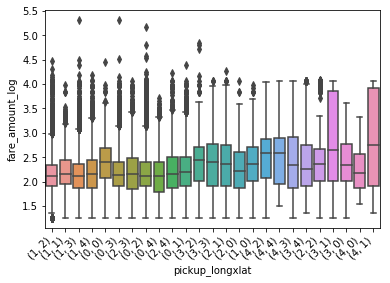

In [81]:
g = sns.boxplot(x='pickup_longxlat', y='fare_amount_log', data=data8)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0,0,'(1, 3)'),
 Text(0,0,'(1, 2)'),
 Text(0,0,'(0, 2)'),
 Text(0,0,'(2, 3)'),
 Text(0,0,'(0, 3)'),
 Text(0,0,'(0, 1)'),
 Text(0,0,'(0, 4)'),
 Text(0,0,'(1, 4)'),
 Text(0,0,'(2, 0)'),
 Text(0,0,'(1, 1)'),
 Text(0,0,'(3, 0)'),
 Text(0,0,'(2, 4)'),
 Text(0,0,'(2, 2)'),
 Text(0,0,'(3, 1)'),
 Text(0,0,'(0, 0)'),
 Text(0,0,'(2, 1)'),
 Text(0,0,'(1, 0)'),
 Text(0,0,'(3, 3)'),
 Text(0,0,'(4, 2)'),
 Text(0,0,'(3, 2)'),
 Text(0,0,'(4, 1)'),
 Text(0,0,'(3, 4)'),
 Text(0,0,'(4, 3)'),
 Text(0,0,'(4, 4)'),
 Text(0,0,'(4, 0)')]

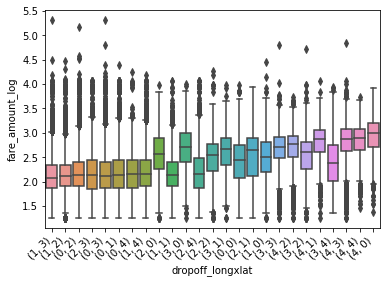

In [82]:
g = sns.boxplot(x='dropoff_longxlat', y='fare_amount_log', data=data8)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

In [83]:
# if trip starts and ends in the same pickup grid
data8['pickup=dropoff_longxlat'] = np.where(data8['pickup_longxlat'] == data8['dropoff_longxlat'],1,0)
data8['pickup=dropoff_longxlat'].value_counts()

0    857578
1    214332
Name: pickup=dropoff_longxlat, dtype: int64

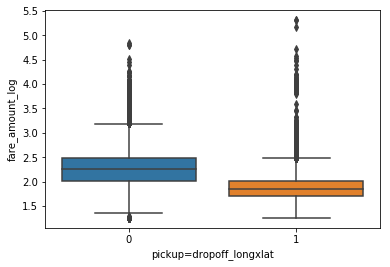

In [84]:
g = sns.boxplot(x='pickup=dropoff_longxlat', y='fare_amount_log', data=data8)

## Feature Engineering - datetime

In [85]:
# convert pickup_datetime, dropoff_datetime to datetime data type
data8['pickup_dt'] = pd.to_datetime(data8.pickup_datetime)
data8['dropoff_dt'] = pd.to_datetime(data8.dropoff_datetime)

In [86]:
data8.dtypes

vendor_id                          object
pickup_datetime                    object
dropoff_datetime                   object
pickup_longitude                  float64
pickup_latitude                   float64
dropoff_longitude                 float64
dropoff_latitude                  float64
rate_code                         float64
passenger_count                     int64
trip_distance                     float64
payment_type                       object
fare_amount                       float64
tip_amount                        float64
tip_paid                            int64
fare_amount_log                   float64
tip_amount_log                    float64
pickup_geom                        object
pickup_zone                        object
pickup_LocationID                  object
pickup_borough                     object
dropoff_geom                       object
dropoff_zone                       object
dropoff_LocationID                 object
dropoff_borough                   

In [87]:
# convert existing UTC timezone to US/Eastern timezone
# pandas.Series.dt.tz_convert
data8['pickup_dt_local'] = data8['pickup_dt'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
data8['dropoff_dt_local'] = data8['dropoff_dt'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

In [88]:
data8['pickup_dt_local'].sort_values()

939429    2008-12-31 19:02:40-05:00
1057780   2008-12-31 19:16:18-05:00
94360     2008-12-31 19:29:18-05:00
572888    2008-12-31 19:29:18-05:00
206707    2008-12-31 19:29:31-05:00
632413    2008-12-31 19:29:31-05:00
440250    2008-12-31 19:29:31-05:00
439113    2008-12-31 19:29:31-05:00
222336    2008-12-31 19:29:31-05:00
911442    2008-12-31 19:30:35-05:00
304375    2008-12-31 19:30:35-05:00
716485    2008-12-31 19:30:35-05:00
984702    2008-12-31 19:34:47-05:00
483139    2008-12-31 19:34:47-05:00
108995    2008-12-31 19:34:47-05:00
993398    2008-12-31 19:34:47-05:00
215542    2008-12-31 19:36:33-05:00
23840     2008-12-31 19:36:33-05:00
247806    2008-12-31 19:36:33-05:00
374055    2008-12-31 20:23:32-05:00
276773    2008-12-31 20:23:32-05:00
305596    2008-12-31 20:23:32-05:00
966947    2008-12-31 20:27:27-05:00
939979    2008-12-31 20:27:27-05:00
530092    2008-12-31 20:27:27-05:00
136325    2008-12-31 20:32:31-05:00
189855    2008-12-31 20:32:31-05:00
532762    2008-12-31 20:41:3

In [89]:
data8['dropoff_dt_local'].sort_values()

939429    2008-12-31 19:11:24-05:00
439113    2008-12-31 19:30:58-05:00
94360     2008-12-31 19:34:23-05:00
911442    2008-12-31 19:34:41-05:00
247806    2008-12-31 19:40:14-05:00
716485    2008-12-31 19:40:55-05:00
108995    2008-12-31 19:41:14-05:00
572888    2008-12-31 19:41:24-05:00
984702    2008-12-31 19:41:48-05:00
304375    2008-12-31 19:43:52-05:00
440250    2008-12-31 19:47:06-05:00
206707    2008-12-31 19:47:46-05:00
23840     2008-12-31 19:47:52-05:00
1057780   2008-12-31 19:47:57-05:00
632413    2008-12-31 19:48:26-05:00
483139    2008-12-31 19:52:02-05:00
215542    2008-12-31 19:52:18-05:00
222336    2008-12-31 19:53:12-05:00
993398    2008-12-31 19:55:22-05:00
305596    2008-12-31 20:29:28-05:00
530092    2008-12-31 20:32:34-05:00
276773    2008-12-31 20:36:14-05:00
374055    2008-12-31 20:36:54-05:00
966947    2008-12-31 20:38:57-05:00
939979    2008-12-31 20:41:04-05:00
136325    2008-12-31 20:42:48-05:00
532762    2008-12-31 20:45:45-05:00
457545    2008-12-31 20:47:2

In [90]:
# hour
data8['pickup_hr'] = data8['pickup_dt_local'].dt.hour
data8['pickup_hr'].value_counts()

15    66794
14    66187
17    63107
16    62414
13    62287
8     57088
18    56229
10    55289
9     54821
7     54678
4     51385
5     50751
6     49787
12    48816
11    48490
19    43521
3     42210
20    33485
2     28382
21    24436
22    17514
23    12538
1     12417
0      9284
Name: pickup_hr, dtype: int64

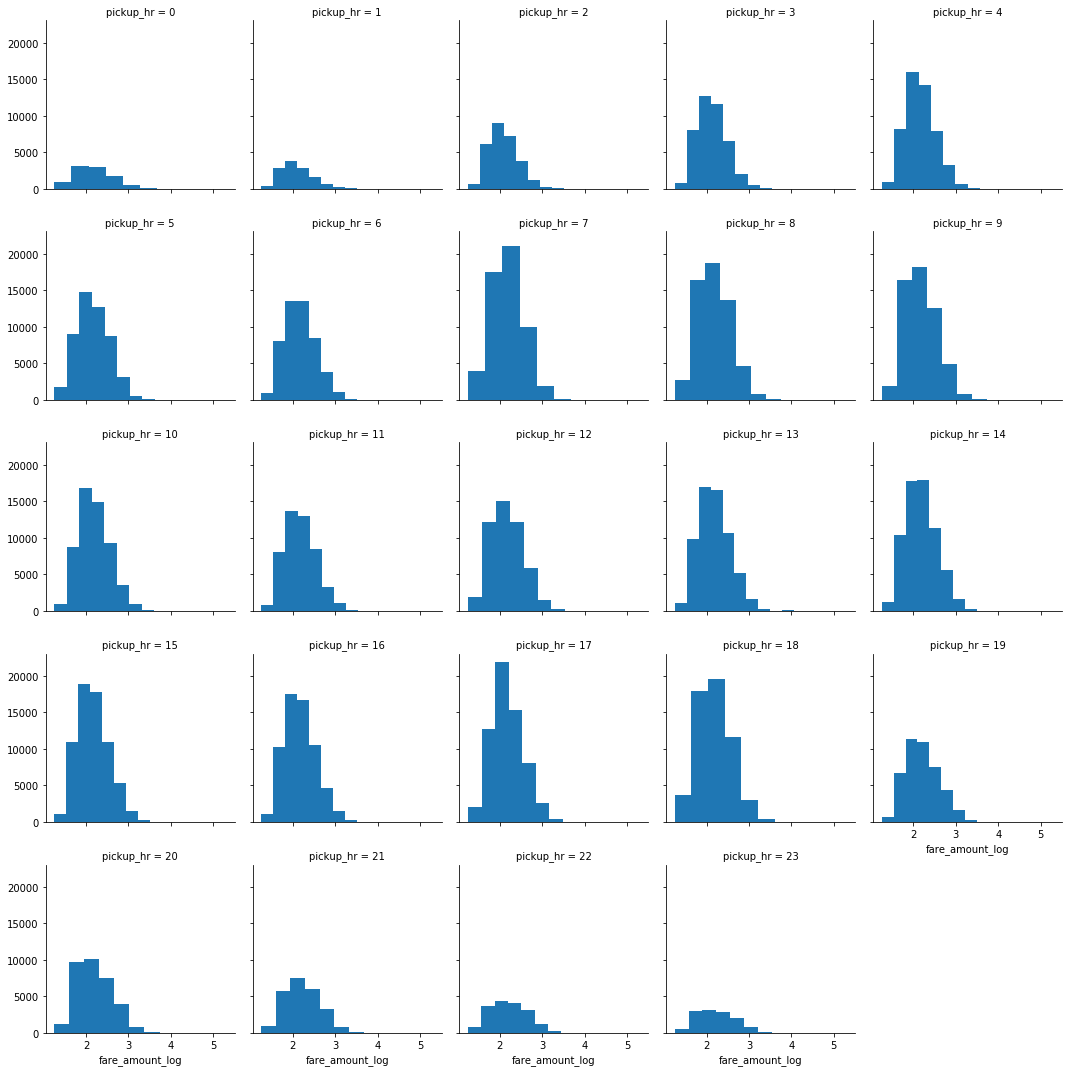

In [91]:
g = sns.FacetGrid(data8, col='pickup_hr', col_wrap=5)
g = g.map(plt.hist, 'fare_amount_log')

In [92]:
# hour
data8['dropoff_hr'] = data8['dropoff_dt_local'].dt.hour
data8['dropoff_hr'].value_counts()

15    69097
14    65027
17    63060
16    62888
13    60803
18    58089
9     55840
8     55380
10    54746
7     54503
5     51081
11    50931
6     49595
4     48654
12    47031
19    45291
3     40251
20    35326
2     25669
21    25656
22    18272
23    13517
1     11622
0      9581
Name: dropoff_hr, dtype: int64

In [93]:
# year
data8['pickup_yr'] = data8['pickup_dt_local'].dt.year
data8['pickup_yr'].value_counts()

2009    173223
2013    170794
2012    169657
2011    166210
2010    161785
2014    155018
2015     75169
2008        54
Name: pickup_yr, dtype: int64

In [94]:
# year
data8['dropoff_yr'] = data8['dropoff_dt_local'].dt.year
data8['dropoff_yr'].value_counts()

2009    173223
2013    170793
2012    169657
2011    166211
2010    161784
2014    155018
2015     75170
2008        54
Name: dropoff_yr, dtype: int64

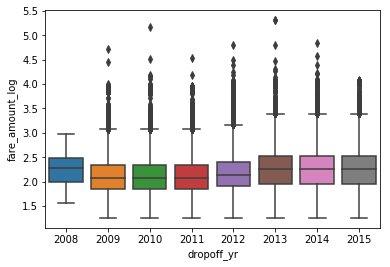

In [187]:
g = sns.boxplot(x='dropoff_yr', y='fare_amount_log', data=data8)

In [95]:
# holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start='2008-12-31', end='2015-07-01')
print(holidays)

data8['pickup_hol'] = np.where(data8['pickup_dt_local'].dt.date.astype('datetime64').isin(holidays),1,0)
data8['pickup_hol'].value_counts()

DatetimeIndex(['2009-01-01', '2009-01-19', '2009-02-16', '2009-05-25',
               '2009-07-03', '2009-09-07', '2009-10-12', '2009-11-11',
               '2009-11-26', '2009-12-25', '2010-01-01', '2010-01-18',
               '2010-02-15', '2010-05-31', '2010-07-05', '2010-09-06',
               '2010-10-11', '2010-11-11', '2010-11-25', '2010-12-24',
               '2010-12-31', '2011-01-17', '2011-02-21', '2011-05-30',
               '2011-07-04', '2011-09-05', '2011-10-10', '2011-11-11',
               '2011-11-24', '2011-12-26', '2012-01-02', '2012-01-16',
               '2012-02-20', '2012-05-28', '2012-07-04', '2012-09-03',
               '2012-10-08', '2012-11-12', '2012-11-22', '2012-12-25',
               '2013-01-01', '2013-01-21', '2013-02-18', '2013-05-27',
               '2013-07-04', '2013-09-02', '2013-10-14', '2013-11-11',
               '2013-11-28', '2013-12-25', '2014-01-01', '2014-01-20',
               '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01',
      

0    1050219
1      21691
Name: pickup_hol, dtype: int64

In [96]:
data8[data8['pickup_hol']==1]

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,pickup=dropoff_longxlat,pickup_dt,dropoff_dt,pickup_dt_local,dropoff_dt_local,pickup_hr,dropoff_hr,pickup_yr,dropoff_yr,pickup_hol
6,VTS,2013-05-27 19:43:00+00:00,2013-05-27 19:53:00+00:00,-73.969715,40.757692,-73.992960,40.754407,1.0,1,1.77,...,0,2013-05-27 19:43:00,2013-05-27 19:53:00,2013-05-27 15:43:00-04:00,2013-05-27 15:53:00-04:00,15,15,2013,2013,1
32,VTS,2014-02-17 12:51:00+00:00,2014-02-17 13:01:00+00:00,-73.959953,40.776182,-73.976197,40.765825,1.0,1,1.53,...,0,2014-02-17 12:51:00,2014-02-17 13:01:00,2014-02-17 07:51:00-05:00,2014-02-17 08:01:00-05:00,7,8,2014,2014,1
80,VTS,2012-09-03 07:43:00+00:00,2012-09-03 07:51:00+00:00,-73.974918,40.750493,-73.991628,40.749783,1.0,1,1.44,...,0,2012-09-03 07:43:00,2012-09-03 07:51:00,2012-09-03 03:43:00-04:00,2012-09-03 03:51:00-04:00,3,3,2012,2012,1
143,CMT,2012-01-16 17:38:55+00:00,2012-01-16 17:45:23+00:00,-73.979202,40.752988,-73.992635,40.734154,1.0,1,1.70,...,0,2012-01-16 17:38:55,2012-01-16 17:45:23,2012-01-16 12:38:55-05:00,2012-01-16 12:45:23-05:00,12,12,2012,2012,1
163,CMT,2014-09-01 22:39:33+00:00,2014-09-01 22:45:52+00:00,-73.981612,40.780834,-73.981714,40.770253,1.0,2,1.10,...,0,2014-09-01 22:39:33,2014-09-01 22:45:52,2014-09-01 18:39:33-04:00,2014-09-01 18:45:52-04:00,18,18,2014,2014,1
169,CMT,2010-02-15 20:12:53+00:00,2010-02-15 20:15:25+00:00,-73.980114,40.739289,-73.988202,40.734496,1.0,1,0.60,...,1,2010-02-15 20:12:53,2010-02-15 20:15:25,2010-02-15 15:12:53-05:00,2010-02-15 15:15:25-05:00,15,15,2010,2010,1
178,CMT,2009-12-25 18:23:51+00:00,2009-12-25 18:28:18+00:00,-73.981621,40.772818,-73.960627,40.773181,NaN,1,1.50,...,0,2009-12-25 18:23:51,2009-12-25 18:28:18,2009-12-25 13:23:51-05:00,2009-12-25 13:28:18-05:00,13,13,2009,2009,1
283,VTS,2014-05-26 04:24:00+00:00,2014-05-26 04:26:00+00:00,-73.957010,40.766137,-73.947425,40.775972,1.0,6,0.97,...,1,2014-05-26 04:24:00,2014-05-26 04:26:00,2014-05-26 00:24:00-04:00,2014-05-26 00:26:00-04:00,0,0,2014,2014,1
298,CMT,2010-12-31 14:52:12+00:00,2010-12-31 15:23:36+00:00,-73.977304,40.751902,-73.987989,40.720022,1.0,1,3.80,...,0,2010-12-31 14:52:12,2010-12-31 15:23:36,2010-12-31 09:52:12-05:00,2010-12-31 10:23:36-05:00,9,10,2010,2010,1
345,CMT,2014-01-01 23:43:53+00:00,2014-01-01 23:47:11+00:00,-73.970115,40.797060,-73.979942,40.784050,1.0,1,1.00,...,1,2014-01-01 23:43:53,2014-01-01 23:47:11,2014-01-01 18:43:53-05:00,2014-01-01 18:47:11-05:00,18,18,2014,2014,1


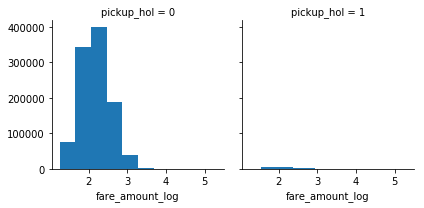

In [97]:
g = sns.FacetGrid(data8, col='pickup_hol')
g = g.map(plt.hist, 'fare_amount_log')

In [98]:
# extract day of week
# Series.dt.weekday	The day of the week with Monday=0, Sunday=6
data8['pickup_wkday'] = data8['pickup_dt_local'].dt.weekday
data8['pickup_wkday'].value_counts()

4    181465
3    163092
5    161422
2    159243
1    153920
0    142990
6    109778
Name: pickup_wkday, dtype: int64

In [99]:
# pickup_weekday
wkday = [0,1,2,3,4]
data8['pickup_weekday'] = np.where(data8['pickup_wkday'].isin(wkday),1,0)
data8['pickup_weekday'].value_counts()

1    800710
0    271200
Name: pickup_weekday, dtype: int64

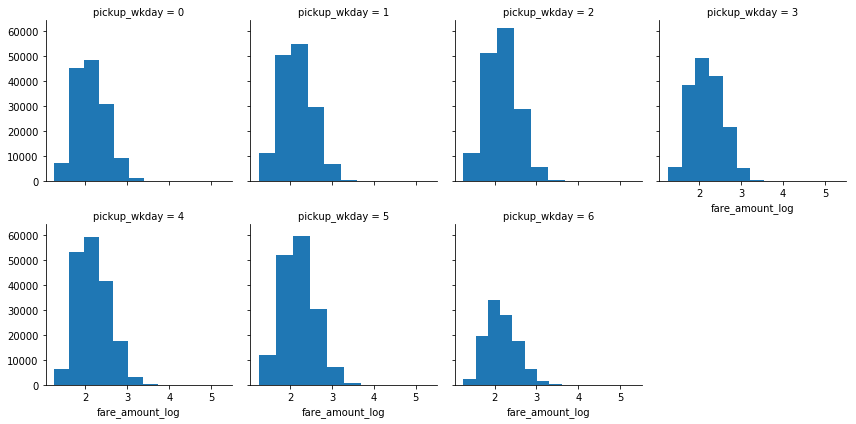

In [100]:
g = sns.FacetGrid(data8, col='pickup_wkday', col_wrap=4)
g = g.map(plt.hist, 'fare_amount_log')

In [101]:
# extract day of week
# Series.dt.weekday	The day of the week with Monday=0, Sunday=6
data8['dropoff_wkday'] = data8['dropoff_dt_local'].dt.weekday
data8['dropoff_wkday'].value_counts()

4    181095
3    163056
5    161496
2    159222
1    153934
0    142961
6    110146
Name: dropoff_wkday, dtype: int64

In [102]:
# 50 cents overnight surcharge 8pm to 6am
overnight = [20,21,22,23,0,1,2,3,4,5,6]
data8['pickup_overnight'] = np.where(data8['pickup_hr'].isin(overnight),1,0)
data8['pickup_overnight'].value_counts()

0    739721
1    332189
Name: pickup_overnight, dtype: int64

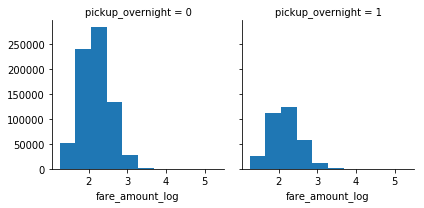

In [103]:
g = sns.FacetGrid(data8, col='pickup_overnight')
g = g.map(plt.hist, 'fare_amount_log')

In [104]:
# rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays
# Satisfy the following conditions: rush_hr = [16,17,18,19], wkday = [0,1,2,3,4], hol = [0]
# True & True & True = True; and False & False & False = False
rush_hr = [16,17,18,19]
wkday = [0,1,2,3,4]
hol = [0]
data8['pickup_rush'] = np.where(data8['pickup_hr'].isin(rush_hr) & data8['pickup_wkday'].isin(wkday) & data8['pickup_hol'].isin(hol),1,0)
data8['pickup_rush'].value_counts()

0    909270
1    162640
Name: pickup_rush, dtype: int64

In [105]:
data8[data8['pickup_rush']==1]

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,pickup_hr,dropoff_hr,pickup_yr,dropoff_yr,pickup_hol,pickup_wkday,pickup_weekday,dropoff_wkday,pickup_overnight,pickup_rush
16,CMT,2013-03-08 23:48:33+00:00,2013-03-08 23:52:25+00:00,-73.981231,40.781186,-73.974306,40.793681,1.0,1,1.00,...,18,18,2013,2013,0,4,1,4,0,1
23,VTS,2011-02-09 21:45:00+00:00,2011-02-09 21:54:00+00:00,-73.997020,40.722410,-73.974078,40.723293,1.0,5,1.76,...,16,16,2011,2011,0,2,1,2,0,1
27,CMT,2012-01-20 21:12:32+00:00,2012-01-20 21:17:21+00:00,-73.971791,40.755263,-73.962132,40.765411,1.0,1,1.10,...,16,16,2012,2012,0,4,1,4,0,1
28,VTS,2012-09-14 22:18:00+00:00,2012-09-14 22:24:00+00:00,-73.952085,40.777403,-73.952022,40.768950,1.0,1,0.78,...,18,18,2012,2012,0,4,1,4,0,1
31,CMT,2014-10-29 22:28:07+00:00,2014-10-29 22:55:31+00:00,-73.974932,40.761839,-73.939317,40.715197,1.0,1,5.70,...,18,18,2014,2014,0,2,1,2,0,1
36,VTS,2013-12-04 21:13:00+00:00,2013-12-04 21:15:00+00:00,-73.990552,40.718725,-73.983375,40.728572,1.0,4,0.88,...,16,16,2013,2013,0,2,1,2,0,1
47,VTS,2009-02-27 22:55:00+00:00,2009-02-27 23:07:00+00:00,-73.988765,40.722678,-73.997277,40.741577,NaN,1,1.92,...,17,18,2009,2009,0,4,1,4,0,1
51,CMT,2010-03-10 21:35:05+00:00,2010-03-10 21:44:18+00:00,-73.994847,40.727828,-73.977756,40.751992,1.0,1,2.10,...,16,16,2010,2010,0,2,1,2,0,1
57,DDS,2009-04-16 23:36:39+00:00,2009-04-16 23:44:27+00:00,-73.957471,40.774505,-73.963228,40.795278,NaN,1,2.00,...,19,19,2009,2009,0,3,1,3,0,1
67,CMT,2010-12-16 21:02:36+00:00,2010-12-16 21:25:23+00:00,-73.981392,40.778583,-73.994827,40.755175,1.0,2,2.70,...,16,16,2010,2010,0,3,1,3,0,1


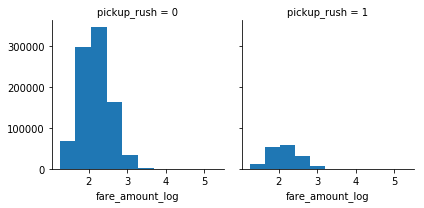

In [106]:
g = sns.FacetGrid(data8, col='pickup_rush')
g = g.map(plt.hist, 'fare_amount_log')

In [107]:
# morning
am = [7,8,9,10,11]
data8['pickup_7-11'] = np.where(data8['pickup_hr'].isin(am),1,0)
data8['pickup_7-11'].value_counts()

0    801544
1    270366
Name: pickup_7-11, dtype: int64

In [108]:
# afternoon
pm = [12,13,14,15]
data8['pickup_12-15'] = np.where(data8['pickup_hr'].isin(pm),1,0)
data8['pickup_12-15'].value_counts()

0    827826
1    244084
Name: pickup_12-15, dtype: int64

## Feature Engineering - trip_duration

In [109]:
# trip duration (dropoff minus pickup yields a timedelta64 data type)
data8['trip_duration'] = data8['dropoff_dt_local'] - data8['pickup_dt_local']

In [110]:
data8.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,dropoff_yr,pickup_hol,pickup_wkday,pickup_weekday,dropoff_wkday,pickup_overnight,pickup_rush,pickup_7-11,pickup_12-15,trip_duration
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.80,...,2013,0,6,0,6,0,0,0,1,00:07:25
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.50,...,2010,0,2,1,2,0,0,0,1,00:10:10
2,CMT,2010-03-03 10:10:25+00:00,2010-03-03 10:19:38+00:00,-73.974089,40.762479,-73.990669,40.745668,1.0,1,1.60,...,2010,0,2,1,2,1,0,0,0,00:09:13
3,VTS,2012-04-17 11:51:00+00:00,2012-04-17 12:07:00+00:00,-73.979920,40.781045,-73.970415,40.765608,1.0,1,1.70,...,2012,0,1,1,1,0,0,1,0,00:16:00
4,VTS,2012-03-30 14:26:00+00:00,2012-03-30 14:36:00+00:00,-73.972975,40.761610,-73.955615,40.764290,1.0,2,1.36,...,2012,0,4,1,4,0,0,1,0,00:10:00


In [111]:
# convert timedelta to hours so that speed can be computed
data8['trip_duration_h'] = (data8['trip_duration'].dt.total_seconds()) / 3600

## Feature Engineering - speed

* Standard metered fare includes 2.50 dollars initial charge, Plus 50 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped.
* Hence, fare_amount is most likely to be influenced by distance travelled and the speed of travel. 
* This calculated field reflects the average speed for the overall journey.

In [112]:
# overall speed miles/hr
data8['speed_mph'] = data8['trip_distance'] / data8['trip_duration_h']

In [113]:
data8.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,pickup_wkday,pickup_weekday,dropoff_wkday,pickup_overnight,pickup_rush,pickup_7-11,pickup_12-15,trip_duration,trip_duration_h,speed_mph
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.80,...,6,0,6,0,0,0,1,00:07:25,0.123611,6.471910
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.50,...,2,1,2,0,0,0,1,00:10:10,0.169444,8.852459
2,CMT,2010-03-03 10:10:25+00:00,2010-03-03 10:19:38+00:00,-73.974089,40.762479,-73.990669,40.745668,1.0,1,1.60,...,2,1,2,1,0,0,0,00:09:13,0.153611,10.415913
3,VTS,2012-04-17 11:51:00+00:00,2012-04-17 12:07:00+00:00,-73.979920,40.781045,-73.970415,40.765608,1.0,1,1.70,...,1,1,1,0,0,1,0,00:16:00,0.266667,6.375000
4,VTS,2012-03-30 14:26:00+00:00,2012-03-30 14:36:00+00:00,-73.972975,40.761610,-73.955615,40.764290,1.0,2,1.36,...,4,1,4,0,0,1,0,00:10:00,0.166667,8.160000


In [114]:
data8['speed_mph'].describe()

count    1.071910e+06
mean              inf
std               NaN
min     -1.476000e+02
25%      8.008095e+00
50%      1.066667e+01
75%      1.391916e+01
max               inf
Name: speed_mph, dtype: float64

Some issues here with presence of inf values when trip_duration = 0.

In [115]:
data8[data8['trip_duration_h']==0]

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,pickup_wkday,pickup_weekday,dropoff_wkday,pickup_overnight,pickup_rush,pickup_7-11,pickup_12-15,trip_duration,trip_duration_h,speed_mph
12123,VTS,2009-03-14 02:39:00+00:00,2009-03-14 02:39:00+00:00,-73.977722,40.752267,-73.992643,40.752315,NaN,2,1.16,...,4,1,4,1,0,0,0,0 days,0.0,inf
15430,CMT,2013-05-30 21:59:20+00:00,2013-05-30 21:59:20+00:00,-73.989126,40.720620,-73.967326,40.756862,1.0,1,2.90,...,3,1,3,0,1,0,0,0 days,0.0,inf
19293,VTS,2012-03-13 12:13:00+00:00,2012-03-13 12:13:00+00:00,-73.983460,40.752888,-73.983328,40.752835,1.0,1,0.02,...,1,1,1,0,0,1,0,0 days,0.0,inf
19632,CMT,2013-11-03 01:55:58+00:00,2013-11-03 01:55:58+00:00,-73.992946,40.768297,-73.966012,40.760539,1.0,3,1.80,...,5,0,5,1,0,0,0,0 days,0.0,inf
20056,VTS,2009-05-15 19:11:00+00:00,2009-05-15 19:11:00+00:00,-73.992215,40.744097,-73.994158,40.744768,NaN,1,0.16,...,4,1,4,0,0,0,1,0 days,0.0,inf
25882,VTS,2009-08-22 06:52:00+00:00,2009-08-22 06:52:00+00:00,-73.989793,40.762232,-73.990018,40.761923,NaN,1,0.03,...,5,0,5,1,0,0,0,0 days,0.0,inf
26236,VTS,2009-09-04 02:19:00+00:00,2009-09-04 02:19:00+00:00,-73.993998,40.746323,-73.994040,40.746258,NaN,2,0.01,...,3,1,3,1,0,0,0,0 days,0.0,inf
26324,VTS,2011-11-08 23:01:00+00:00,2011-11-08 23:01:00+00:00,-73.952452,40.777142,-73.955855,40.772337,1.0,1,0.38,...,1,1,1,0,1,0,0,0 days,0.0,inf
27175,VTS,2013-03-21 03:17:00+00:00,2013-03-21 03:17:00+00:00,-73.993442,40.715435,-73.994495,40.714802,1.0,4,0.17,...,2,1,2,1,0,0,0,0 days,0.0,inf
27999,VTS,2011-10-07 23:17:00+00:00,2011-10-07 23:17:00+00:00,-73.959960,40.762303,-73.959117,40.764207,1.0,5,0.15,...,4,1,4,0,1,0,0,0 days,0.0,inf


In [116]:
len(data8[data8['trip_duration_h']==0])

450

## Drop - Rows where 'dropoff_dt_local' < 'pickup_dt_local'

In [117]:
# examine rows whereby trip_duration is <0 because dropoff datetime < pickup datetime
data8[data8['trip_duration_h']<0]

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,pickup_wkday,pickup_weekday,dropoff_wkday,pickup_overnight,pickup_rush,pickup_7-11,pickup_12-15,trip_duration,trip_duration_h,speed_mph
295,VTS,2009-01-14 21:38:00+00:00,2009-01-14 21:37:00+00:00,-73.982482,40.745197,-73.972328,40.756428,NaN,5,1.12,...,2,1,2,0,1,0,0,-1 days +23:59:00,-0.016667,-67.200000
2303,VTS,2009-03-05 17:59:00+00:00,2009-03-05 17:52:00+00:00,-73.973455,40.755675,-73.979173,40.746787,NaN,3,0.72,...,3,1,3,0,0,0,1,-1 days +23:53:00,-0.116667,-6.171429
3907,VTS,2009-01-03 17:49:00+00:00,2009-01-03 17:45:00+00:00,-73.981908,40.776542,-73.981110,40.769160,NaN,1,0.74,...,5,0,5,0,0,0,1,-1 days +23:56:00,-0.066667,-11.100000
5202,VTS,2009-02-10 14:52:00+00:00,2009-02-10 14:50:00+00:00,-73.979768,40.749245,-73.973103,40.753268,NaN,5,0.64,...,1,1,1,0,0,1,0,-1 days +23:58:00,-0.033333,-19.200000
11737,VTS,2009-01-09 08:54:00+00:00,2009-01-09 08:50:00+00:00,-73.995867,40.748873,-73.978888,40.773292,NaN,1,1.95,...,4,1,4,1,0,0,0,-1 days +23:56:00,-0.066667,-29.250000
14778,VTS,2009-01-05 21:20:00+00:00,2009-01-05 21:19:00+00:00,-73.973038,40.755670,-73.949592,40.784828,NaN,2,2.34,...,0,1,0,0,1,0,0,-1 days +23:59:00,-0.016667,-140.400000
18838,VTS,2009-01-03 17:49:00+00:00,2009-01-03 17:43:00+00:00,-73.963667,40.776995,-73.980935,40.786087,NaN,1,1.40,...,5,0,5,0,0,0,1,-1 days +23:54:00,-0.100000,-14.000000
20013,VTS,2009-01-12 22:03:00+00:00,2009-01-12 21:58:00+00:00,-73.972453,40.786188,-73.980998,40.780890,NaN,1,0.77,...,0,1,0,0,1,0,0,-1 days +23:55:00,-0.083333,-9.240000
20664,VTS,2009-01-01 14:28:00+00:00,2009-01-01 14:27:00+00:00,-73.956923,40.766385,-73.960460,40.760667,NaN,2,0.69,...,3,1,3,0,0,1,0,-1 days +23:59:00,-0.016667,-41.400000
20931,VTS,2009-02-26 17:26:00+00:00,2009-02-26 17:17:00+00:00,-73.948733,40.773717,-73.954442,40.767090,NaN,3,0.59,...,3,1,3,0,0,0,1,-1 days +23:51:00,-0.150000,-3.933333


In [118]:
# no. of rows whereby trip_duration is <0 because dropoff datetime < pickup datetime
len(data8[data8['trip_duration_h']<0])

235

In [119]:
data8.shape

(1071910, 53)

In [120]:
# drop rows whereby trip_duration is <0 because dropoff datetime < pickup datetime
# df = df.drop(df[df.score < 50].index)
data9 = data8.drop(data8[data8['trip_duration_h']<0].index)

In [121]:
data9.shape

(1071675, 53)

In [122]:
data9.dtypes

vendor_id                                      object
pickup_datetime                                object
dropoff_datetime                               object
pickup_longitude                              float64
pickup_latitude                               float64
dropoff_longitude                             float64
dropoff_latitude                              float64
rate_code                                     float64
passenger_count                                 int64
trip_distance                                 float64
payment_type                                   object
fare_amount                                   float64
tip_amount                                    float64
tip_paid                                        int64
fare_amount_log                               float64
tip_amount_log                                float64
pickup_geom                                    object
pickup_zone                                    object
pickup_LocationID           

In [123]:
# check results
data9[data9['dropoff_dt_local']<data9['pickup_dt_local']]

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,pickup_wkday,pickup_weekday,dropoff_wkday,pickup_overnight,pickup_rush,pickup_7-11,pickup_12-15,trip_duration,trip_duration_h,speed_mph


## Drop - Rows where 'dropoff_dt_local' == 'pickup_dt_local'

In [124]:
# examine rows whereby trip_duration is == 0 because dropoff datetime == pickup datetime
data9[data9['trip_duration_h']==0]

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,pickup_wkday,pickup_weekday,dropoff_wkday,pickup_overnight,pickup_rush,pickup_7-11,pickup_12-15,trip_duration,trip_duration_h,speed_mph
12123,VTS,2009-03-14 02:39:00+00:00,2009-03-14 02:39:00+00:00,-73.977722,40.752267,-73.992643,40.752315,NaN,2,1.16,...,4,1,4,1,0,0,0,0 days,0.0,inf
15430,CMT,2013-05-30 21:59:20+00:00,2013-05-30 21:59:20+00:00,-73.989126,40.720620,-73.967326,40.756862,1.0,1,2.90,...,3,1,3,0,1,0,0,0 days,0.0,inf
19293,VTS,2012-03-13 12:13:00+00:00,2012-03-13 12:13:00+00:00,-73.983460,40.752888,-73.983328,40.752835,1.0,1,0.02,...,1,1,1,0,0,1,0,0 days,0.0,inf
19632,CMT,2013-11-03 01:55:58+00:00,2013-11-03 01:55:58+00:00,-73.992946,40.768297,-73.966012,40.760539,1.0,3,1.80,...,5,0,5,1,0,0,0,0 days,0.0,inf
20056,VTS,2009-05-15 19:11:00+00:00,2009-05-15 19:11:00+00:00,-73.992215,40.744097,-73.994158,40.744768,NaN,1,0.16,...,4,1,4,0,0,0,1,0 days,0.0,inf
25882,VTS,2009-08-22 06:52:00+00:00,2009-08-22 06:52:00+00:00,-73.989793,40.762232,-73.990018,40.761923,NaN,1,0.03,...,5,0,5,1,0,0,0,0 days,0.0,inf
26236,VTS,2009-09-04 02:19:00+00:00,2009-09-04 02:19:00+00:00,-73.993998,40.746323,-73.994040,40.746258,NaN,2,0.01,...,3,1,3,1,0,0,0,0 days,0.0,inf
26324,VTS,2011-11-08 23:01:00+00:00,2011-11-08 23:01:00+00:00,-73.952452,40.777142,-73.955855,40.772337,1.0,1,0.38,...,1,1,1,0,1,0,0,0 days,0.0,inf
27175,VTS,2013-03-21 03:17:00+00:00,2013-03-21 03:17:00+00:00,-73.993442,40.715435,-73.994495,40.714802,1.0,4,0.17,...,2,1,2,1,0,0,0,0 days,0.0,inf
27999,VTS,2011-10-07 23:17:00+00:00,2011-10-07 23:17:00+00:00,-73.959960,40.762303,-73.959117,40.764207,1.0,5,0.15,...,4,1,4,0,1,0,0,0 days,0.0,inf


In [125]:
len(data9[data9['trip_duration_h']==0])

450

Since there are only 450 rows affected, these can be dropped so that duration and speed can be incorporated into the model.

In [126]:
# drop rows whereby trip_duration is == 0 because dropoff datetime == pickup datetime
# df = df.drop(df[df.score < 50].index)
data10 = data9.drop(data9[data9['trip_duration_h']==0].index)

In [127]:
data10.shape

(1071225, 53)

## Drop - Rows where 'pickup_zone' and 'dropoff_zone' are null

* Examining both pickup and dropoff coordinates against their shape files, there are several coordinates in the rivers and outside of the shape file geometry.
* These correspond to the 521 pickup_zone and 577 dropoff_zone with null values.
* These points are perhaps reflective of GPS errors.
* Since this is a small percentage out of the entire dataset, these rows will be dropped.

In [128]:
data10.isnull().sum()

vendor_id                       0
pickup_datetime                 0
dropoff_datetime                0
pickup_longitude                0
pickup_latitude                 0
dropoff_longitude               0
dropoff_latitude                0
rate_code                  172813
passenger_count                 0
trip_distance                   0
payment_type                    0
fare_amount                     0
tip_amount                      0
tip_paid                        0
fare_amount_log                 0
tip_amount_log                  0
pickup_geom                     0
pickup_zone                   520
pickup_LocationID               0
pickup_borough                520
dropoff_geom                    0
dropoff_zone                  576
dropoff_LocationID              0
dropoff_borough               576
same_zone                       0
same_borough                    0
pickup_long                     0
pickup_lat                      0
dropoff_long                    0
dropoff_lat   

In [129]:
data10[data10['pickup_zone'].isna()]

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,pickup_wkday,pickup_weekday,dropoff_wkday,pickup_overnight,pickup_rush,pickup_7-11,pickup_12-15,trip_duration,trip_duration_h,speed_mph
1524,CMT,2010-05-30 15:35:55+00:00,2010-05-30 15:40:43+00:00,-73.955277,40.753723,-73.960507,40.755578,1.0,1,0.50,...,6,0,6,0,0,1,0,00:04:48,0.080000,6.250000
2291,VTS,2009-05-22 14:48:00+00:00,2009-05-22 14:56:00+00:00,-73.967077,40.741692,-73.974855,40.744258,NaN,2,0.57,...,4,1,4,0,0,1,0,00:08:00,0.133333,4.275000
2497,VTS,2011-07-15 21:21:00+00:00,2011-07-15 21:27:00+00:00,-73.998012,40.777303,-73.985820,40.778948,1.0,1,0.76,...,4,1,4,0,1,0,0,00:06:00,0.100000,7.600000
3753,CMT,2010-12-13 16:59:19+00:00,2010-12-13 17:11:23+00:00,-73.946749,40.736996,-73.961707,40.767680,1.0,2,2.60,...,0,1,0,0,0,1,0,00:12:04,0.201111,12.928177
4521,VTS,2011-01-29 20:03:00+00:00,2011-01-29 20:11:00+00:00,-73.994323,40.776527,-73.990252,40.767012,1.0,1,1.32,...,5,0,5,0,0,0,1,00:08:00,0.133333,9.900000
7553,CMT,2012-02-09 19:39:32+00:00,2012-02-09 19:51:10+00:00,-73.968004,40.747532,-73.965053,40.709098,1.0,1,2.70,...,3,1,3,0,0,0,1,00:11:38,0.193889,13.925501
12312,VTS,2009-10-21 20:37:00+00:00,2009-10-21 20:49:00+00:00,-73.953527,40.753035,-73.955082,40.775735,NaN,2,2.22,...,2,1,2,0,1,0,0,00:12:00,0.200000,11.100000
12420,VTS,2010-12-29 15:28:00+00:00,2010-12-29 15:58:00+00:00,-73.968932,40.746063,-73.982055,40.780870,1.0,1,3.46,...,2,1,2,0,0,1,0,00:30:00,0.500000,6.920000
13147,VTS,2009-02-22 00:27:00+00:00,2009-02-22 00:32:00+00:00,-73.964675,40.726315,-73.969918,40.741133,NaN,1,1.17,...,5,0,5,0,0,0,0,00:05:00,0.083333,14.040000
13513,VTS,2012-11-11 02:16:00+00:00,2012-11-11 02:29:00+00:00,-73.970105,40.712980,-73.976682,40.747670,1.0,5,2.51,...,5,0,5,1,0,0,0,00:13:00,0.216667,11.584615


In [130]:
len(data10[data10['pickup_zone'].isna()])

520

In [131]:
data10[data10['dropoff_zone'].isna()]

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,pickup_wkday,pickup_weekday,dropoff_wkday,pickup_overnight,pickup_rush,pickup_7-11,pickup_12-15,trip_duration,trip_duration_h,speed_mph
132,VTS,2010-09-18 02:21:00+00:00,2010-09-18 02:33:00+00:00,-73.978990,40.733045,-73.964380,40.732647,1.0,2,2.47,...,4,1,4,1,0,0,0,00:12:00,0.200000,12.350000
1120,VTS,2011-11-17 11:34:00+00:00,2011-11-17 11:51:00+00:00,-73.960997,40.781160,-73.964270,40.752103,1.0,4,3.03,...,3,1,3,1,0,0,0,00:17:00,0.283333,10.694118
1524,CMT,2010-05-30 15:35:55+00:00,2010-05-30 15:40:43+00:00,-73.955277,40.753723,-73.960507,40.755578,1.0,1,0.50,...,6,0,6,0,0,1,0,00:04:48,0.080000,6.250000
5199,VTS,2012-10-19 03:35:00+00:00,2012-10-19 03:39:00+00:00,-73.993685,40.712477,-73.974827,40.714265,1.0,4,1.78,...,3,1,3,1,0,0,0,00:04:00,0.066667,26.700000
12029,CMT,2009-10-07 16:59:13+00:00,2009-10-07 17:04:39+00:00,-73.975205,40.738877,-73.969685,40.729609,NaN,2,1.10,...,2,1,2,0,0,0,1,00:05:26,0.090556,12.147239
12886,CMT,2013-01-07 15:00:41+00:00,2013-01-07 15:18:40+00:00,-73.960083,40.773982,-73.972464,40.738161,1.0,1,3.60,...,0,1,0,0,0,1,0,00:17:59,0.299722,12.011121
13147,VTS,2009-02-22 00:27:00+00:00,2009-02-22 00:32:00+00:00,-73.964675,40.726315,-73.969918,40.741133,NaN,1,1.17,...,5,0,5,0,0,0,0,00:05:00,0.083333,14.040000
16356,CMT,2009-10-19 07:44:32+00:00,2009-10-19 07:49:24+00:00,-73.949774,40.766150,-73.942050,40.768688,NaN,1,0.60,...,0,1,0,1,0,0,0,00:04:52,0.081111,7.397260
17235,VTS,2009-10-16 17:08:00+00:00,2009-10-16 17:23:00+00:00,-73.976703,40.748393,-73.952723,40.761542,NaN,5,2.01,...,4,1,4,0,0,0,1,00:15:00,0.250000,8.040000
21274,CMT,2011-05-05 00:16:50+00:00,2011-05-05 00:25:28+00:00,-73.987199,40.719606,-73.973232,40.713745,1.0,1,2.40,...,2,1,2,1,0,0,0,00:08:38,0.143889,16.679537


In [132]:
len(data10[data10['dropoff_zone'].isna()])

576

In [133]:
# drop rows corresponding to 521 pickup_zone with null values
data11 = data10.drop(data10[data10['pickup_zone'].isna()].index)

In [134]:
data11.shape

(1070705, 53)

In [135]:
data11.isnull().sum()

vendor_id                       0
pickup_datetime                 0
dropoff_datetime                0
pickup_longitude                0
pickup_latitude                 0
dropoff_longitude               0
dropoff_latitude                0
rate_code                  172675
passenger_count                 0
trip_distance                   0
payment_type                    0
fare_amount                     0
tip_amount                      0
tip_paid                        0
fare_amount_log                 0
tip_amount_log                  0
pickup_geom                     0
pickup_zone                     0
pickup_LocationID               0
pickup_borough                  0
dropoff_geom                    0
dropoff_zone                  519
dropoff_LocationID              0
dropoff_borough               519
same_zone                       0
same_borough                    0
pickup_long                     0
pickup_lat                      0
dropoff_long                    0
dropoff_lat   

In [136]:
# drop rows corresponding to dropoff_zone with null values
data12 = data11.drop(data11[data11['dropoff_zone'].isna()].index)

In [137]:
data12.shape

(1070186, 53)

In [138]:
data12.isnull().sum()

vendor_id                       0
pickup_datetime                 0
dropoff_datetime                0
pickup_longitude                0
pickup_latitude                 0
dropoff_longitude               0
dropoff_latitude                0
rate_code                  172537
passenger_count                 0
trip_distance                   0
payment_type                    0
fare_amount                     0
tip_amount                      0
tip_paid                        0
fare_amount_log                 0
tip_amount_log                  0
pickup_geom                     0
pickup_zone                     0
pickup_LocationID               0
pickup_borough                  0
dropoff_geom                    0
dropoff_zone                    0
dropoff_LocationID              0
dropoff_borough                 0
same_zone                       0
same_borough                    0
pickup_long                     0
pickup_lat                      0
dropoff_long                    0
dropoff_lat   

## Drop - payment_type

In [139]:
data8['payment_type'].value_counts()

CSH    545180
CRD    434636
CAS     33097
Cas     27046
Cre     26436
CRE      2856
NOC      1142
UNK      1035
DIS       300
No        131
Dis        28
NA         23
Name: payment_type, dtype: int64

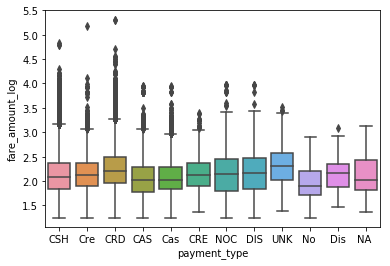

In [140]:
g = sns.boxplot(x='payment_type', y='fare_amount_log', data=data8)

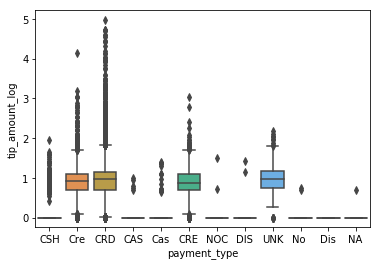

In [141]:
g = sns.boxplot(x='payment_type', y='tip_amount_log', data=data8)

In [142]:
# filter df to trips paid with cash
cash = ['CSH','CAS','Cas']
pay_cash = data8[data8['payment_type'].isin(cash)]

In [143]:
pay_cash['tip_amount'].describe()

count    605323.000000
mean          0.000466
std           0.030998
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.120000
Name: tip_amount, dtype: float64

In [144]:
# no. of trips with payment type = cash and tip amount = 0
len(pay_cash[pay_cash['tip_amount']==0])

605156

In [145]:
# no. of trips with payment type = cash and tip amount !=0
len(pay_cash[pay_cash['tip_amount']!=0])

167

* According to data dictionary, tip_amount is a field automatically populated for credit card tips. Cash tips are not included.
* According to EDA above, 167 trips paid in cash had tips whereas 605156 trips paid in cash had no tips. 
* Hence, it is pointless to fit a machine learning model to predict 'tip_paid' and 'tip_amount' using 'payment_type'.

## passenger_count

In [146]:
data['passenger_count'].value_counts()

1    746126
2    156234
5     77069
3     46868
6     23178
4     22435
Name: passenger_count, dtype: int64

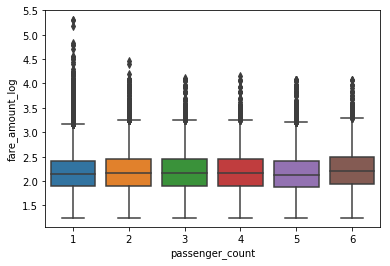

In [147]:
g = sns.boxplot(x='passenger_count', y='fare_amount_log', data=data)

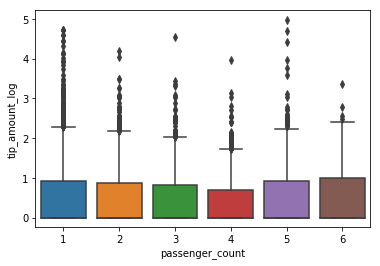

In [148]:
g = sns.boxplot(x='passenger_count', y='tip_amount_log', data=data)

* There are slight visible differences in the number of passengers and the fare / tip amount.

## Drop - rate_code

* Drop 'rate_code' because majority of this dataset are rate_code = 1, ie. standard rate. 
* According to the New York City yellow taxi trip records data dictionary, rate_code = 2 is JFK, which according to the mapped shape file, this dataset's pickup and dropoff coordinates do not cover 'JFK Airport'. 
* Similarly, rate_code = 3 is Newark but this dataset's pickup and dropoff coordinates do not cover 'Newark Airport'.
* Similarly, rate_code = 4 is Nassau/Westchester, again, not covered by this dataset.
* It is unclear why the dataset's rate_code still include rate_code = 2, 3, and 4 when the destinations do not exist.
* Only rate_code = 5 (negotiated fare), rate_code = 6 (group ride) may be applicable to this dataset, but the number of corresponding rows are too little.
* This dataset has additional rate_code = 0 and rate_code = 99, and these are likely to be missing values.
* 172813 isnull values.

In [149]:
data8['pickup_zone'].unique()

array(['Midtown East', 'Kips Bay', 'Midtown North',
       'Upper West Side South', 'Midtown Center', 'Little Italy/NoLiTa',
       'Clinton West', 'Lincoln Square East',
       'Sutton Place/Turtle Bay North', 'Lenox Hill West',
       'Penn Station/Madison Sq West', 'Garment District', 'Murray Hill',
       'Upper East Side North', 'Gramercy', 'Union Sq', 'Clinton East',
       'Yorkville West', 'Lower East Side', 'Midtown South',
       'Lenox Hill East', 'Times Sq/Theatre District',
       'Greenwich Village South', 'Alphabet City', 'Yorkville East',
       'Central Park', 'UN/Turtle Bay South', 'Greenwich Village North',
       'East Chelsea', 'Manhattan Valley', 'Two Bridges/Seward Park',
       'Upper West Side North', 'Long Island City/Queens Plaza',
       'Astoria Park', 'East Village', 'East Harlem South',
       'Upper East Side South', 'Flatiron',
       'Stuy Town/Peter Cooper Village', 'Lincoln Square West',
       'Greenpoint', 'Williamsburg (North Side)', 'SoHo', 'Asto

In [150]:
shape['zone'].unique()

array(['Newark Airport', 'Jamaica Bay', 'Allerton/Pelham Gardens',
       'Alphabet City', 'Arden Heights', 'Arrochar/Fort Wadsworth',
       'Astoria', 'Astoria Park', 'Auburndale', 'Baisley Park',
       'Bath Beach', 'Battery Park', 'Battery Park City', 'Bay Ridge',
       'Bay Terrace/Fort Totten', 'Bayside', 'Bedford', 'Bedford Park',
       'Bellerose', 'Belmont', 'Bensonhurst East', 'Bensonhurst West',
       'Bloomfield/Emerson Hill', 'Bloomingdale', 'Boerum Hill',
       'Borough Park', 'Breezy Point/Fort Tilden/Riis Beach',
       'Briarwood/Jamaica Hills', 'Brighton Beach', 'Broad Channel',
       'Bronx Park', 'Bronxdale', 'Brooklyn Heights',
       'Brooklyn Navy Yard', 'Brownsville', 'Bushwick North',
       'Bushwick South', 'Cambria Heights', 'Canarsie', 'Carroll Gardens',
       'Central Harlem', 'Central Harlem North', 'Central Park',
       'Charleston/Tottenville', 'Chinatown', 'City Island',
       'Claremont/Bathgate', 'Clinton East', 'Clinton Hill',
       'Clint

## Build model

In [151]:
data12.dtypes

vendor_id                                      object
pickup_datetime                                object
dropoff_datetime                               object
pickup_longitude                              float64
pickup_latitude                               float64
dropoff_longitude                             float64
dropoff_latitude                              float64
rate_code                                     float64
passenger_count                                 int64
trip_distance                                 float64
payment_type                                   object
fare_amount                                   float64
tip_amount                                    float64
tip_paid                                        int64
fare_amount_log                               float64
tip_amount_log                                float64
pickup_geom                                    object
pickup_zone                                    object
pickup_LocationID           

In [152]:
# select variables for building the model
train1 = data12.loc[:,['fare_amount',
                       'tip_amount',
                       'tip_paid',
                       'vendor_id',
                       'pickup_zone', 
                       'pickup_borough', 
                       'dropoff_zone', 
                       'dropoff_borough',
                       'same_zone',
                       'same_borough',
                       'trip_distance', 
                       'pickup_7-11', 
                       'pickup_12-15', 
                       'pickup_weekday', 
                       'pickup_rush', 
                       'pickup_overnight',
                       'pickup_hol', 
                       'dropoff_yr',
                       'passenger_count',
                       'trip_duration_h', 
                       'speed_mph']]

In [153]:
train1.dtypes

fare_amount         float64
tip_amount          float64
tip_paid              int64
vendor_id            object
pickup_zone          object
pickup_borough       object
dropoff_zone         object
dropoff_borough      object
same_zone             int32
same_borough          int32
trip_distance       float64
pickup_7-11           int32
pickup_12-15          int32
pickup_weekday        int32
pickup_rush           int32
pickup_overnight      int32
pickup_hol            int32
dropoff_yr            int64
passenger_count       int64
trip_duration_h     float64
speed_mph           float64
dtype: object

In [154]:
# one hot encode categorical variables
# pandas.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)
train11 = pd.get_dummies(train1)

In [155]:
# this set of variables will be referred to as "train11"
train11.dtypes

fare_amount                                      float64
tip_amount                                       float64
tip_paid                                           int64
same_zone                                          int32
same_borough                                       int32
trip_distance                                    float64
pickup_7-11                                        int32
pickup_12-15                                       int32
pickup_weekday                                     int32
pickup_rush                                        int32
pickup_overnight                                   int32
pickup_hol                                         int32
dropoff_yr                                         int64
passenger_count                                    int64
trip_duration_h                                  float64
speed_mph                                        float64
vendor_id_CMT                                      uint8
vendor_id_DDS                  

In [156]:
train11.head()

,fare_amount,tip_amount,tip_paid,same_zone,same_borough,trip_distance,pickup_7-11,pickup_12-15,pickup_weekday,pickup_rush,...,dropoff_zone_West Village,dropoff_zone_Williamsburg (North Side),dropoff_zone_Williamsburg (South Side),dropoff_zone_Woodside,dropoff_zone_Yorkville East,dropoff_zone_Yorkville West,dropoff_borough_Bronx,dropoff_borough_Brooklyn,dropoff_borough_Manhattan,dropoff_borough_Queens
0,6.5,0.00,0,0,1,0.80,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,6.9,1.88,1,0,1,1.50,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
2,6.9,1.00,1,0,1,1.60,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,9.7,1.94,1,0,1,1.70,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,6.9,0.00,0,0,1,1.36,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [157]:
train11.shape

(1070186, 176)

In [158]:
# select variables for building the model
train2 = data12.loc[:,['fare_amount',
                       'tip_amount',
                       'tip_paid',
                       'vendor_id',
                       'trip_distance', 
                       'pickup_7-11', 
                       'pickup_12-15', 
                       'pickup_weekday',
                       'pickup_rush', 
                       'pickup_overnight',
                       'pickup_hol', 
                       'dropoff_yr',
                       'passenger_count',
                       'trip_duration_h', 
                       'speed_mph', 
                       'pickup_longxlat', 
                       'dropoff_longxlat',
                       'pickup=dropoff_longxlat']]

In [159]:
train2.dtypes

fare_amount                float64
tip_amount                 float64
tip_paid                     int64
vendor_id                   object
trip_distance              float64
pickup_7-11                  int32
pickup_12-15                 int32
pickup_weekday               int32
pickup_rush                  int32
pickup_overnight             int32
pickup_hol                   int32
dropoff_yr                   int64
passenger_count              int64
trip_duration_h            float64
speed_mph                  float64
pickup_longxlat             object
dropoff_longxlat            object
pickup=dropoff_longxlat      int32
dtype: object

In [160]:
# one hot encode categorical variables
train21 = pd.get_dummies(train2)

In [161]:
train21.shape

(1070186, 68)

In [162]:
# this set of variables will be referred to as "train21"
train21.dtypes

fare_amount                float64
tip_amount                 float64
tip_paid                     int64
trip_distance              float64
pickup_7-11                  int32
pickup_12-15                 int32
pickup_weekday               int32
pickup_rush                  int32
pickup_overnight             int32
pickup_hol                   int32
dropoff_yr                   int64
passenger_count              int64
trip_duration_h            float64
speed_mph                  float64
pickup=dropoff_longxlat      int32
vendor_id_CMT                uint8
vendor_id_DDS                uint8
vendor_id_VTS                uint8
pickup_longxlat_(0, 0)       uint8
pickup_longxlat_(0, 1)       uint8
pickup_longxlat_(0, 2)       uint8
pickup_longxlat_(0, 3)       uint8
pickup_longxlat_(0, 4)       uint8
pickup_longxlat_(1, 0)       uint8
pickup_longxlat_(1, 1)       uint8
pickup_longxlat_(1, 2)       uint8
pickup_longxlat_(1, 3)       uint8
pickup_longxlat_(1, 4)       uint8
pickup_longxlat_(2, 

In [163]:
# select variables for building the model
train3 = data12.loc[:,['fare_amount',
                       'tip_amount',
                       'tip_paid',
                       'vendor_id',
                       'trip_distance', 
                       'pickup_7-11', 
                       'pickup_12-15', 
                       'pickup_weekday', 
                       'pickup_rush', 
                       'pickup_overnight',
                       'pickup_hol', 
                       'dropoff_yr',
                       'passenger_count',
                       'trip_duration_h', 
                       'speed_mph', 
                       'pickup_longxlat', 
                       'dropoff_longxlat', 
                       'pickup_x_dropoff']]

In [164]:
train3.dtypes

fare_amount         float64
tip_amount          float64
tip_paid              int64
vendor_id            object
trip_distance       float64
pickup_7-11           int32
pickup_12-15          int32
pickup_weekday        int32
pickup_rush           int32
pickup_overnight      int32
pickup_hol            int32
dropoff_yr            int64
passenger_count       int64
trip_duration_h     float64
speed_mph           float64
pickup_longxlat      object
dropoff_longxlat     object
pickup_x_dropoff     object
dtype: object

In [165]:
# one hot encode categorical variables
train31 = pd.get_dummies(train3)

In [166]:
train31.shape

(1070186, 641)

In [167]:
# this set of variables will be referred to as "train31"
train31.dtypes

fare_amount                          float64
tip_amount                           float64
tip_paid                               int64
trip_distance                        float64
pickup_7-11                            int32
pickup_12-15                           int32
pickup_weekday                         int32
pickup_rush                            int32
pickup_overnight                       int32
pickup_hol                             int32
dropoff_yr                             int64
passenger_count                        int64
trip_duration_h                      float64
speed_mph                            float64
vendor_id_CMT                          uint8
vendor_id_DDS                          uint8
vendor_id_VTS                          uint8
pickup_longxlat_(0, 0)                 uint8
pickup_longxlat_(0, 1)                 uint8
pickup_longxlat_(0, 2)                 uint8
pickup_longxlat_(0, 3)                 uint8
pickup_longxlat_(0, 4)                 uint8
pickup_lon

## Train/Valid/Test Split

In [168]:
train11.iloc[0:2:,3:176]

,same_zone,same_borough,trip_distance,pickup_7-11,pickup_12-15,pickup_weekday,pickup_rush,pickup_overnight,pickup_hol,dropoff_yr,...,dropoff_zone_West Village,dropoff_zone_Williamsburg (North Side),dropoff_zone_Williamsburg (South Side),dropoff_zone_Woodside,dropoff_zone_Yorkville East,dropoff_zone_Yorkville West,dropoff_borough_Bronx,dropoff_borough_Brooklyn,dropoff_borough_Manhattan,dropoff_borough_Queens
0,0,1,0.8,0,1,0,0,0,0,2013,...,0,0,0,0,0,0,0,0,1,0
1,0,1,1.5,0,1,1,0,0,0,2010,...,0,0,0,0,0,0,0,0,1,0


In [169]:
train1.iloc[0:2:,0:3]

,fare_amount,tip_amount,tip_paid
0,6.5,0.00,0
1,6.9,1.88,1


In [170]:
# train, valid, test dataset split based on "train11" set of variables
x_train1, x_test1, y_train1, y_test1 = train_test_split(train11.iloc[:,3:176], 
                                                    train11.iloc[:,0:3], 
                                                    test_size = 0.1, 
                                                    random_state = 2019)

In [171]:
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train1, y_train1, test_size = 0.1, random_state = 2019)

In [172]:
train21.dtypes

fare_amount                float64
tip_amount                 float64
tip_paid                     int64
trip_distance              float64
pickup_7-11                  int32
pickup_12-15                 int32
pickup_weekday               int32
pickup_rush                  int32
pickup_overnight             int32
pickup_hol                   int32
dropoff_yr                   int64
passenger_count              int64
trip_duration_h            float64
speed_mph                  float64
pickup=dropoff_longxlat      int32
vendor_id_CMT                uint8
vendor_id_DDS                uint8
vendor_id_VTS                uint8
pickup_longxlat_(0, 0)       uint8
pickup_longxlat_(0, 1)       uint8
pickup_longxlat_(0, 2)       uint8
pickup_longxlat_(0, 3)       uint8
pickup_longxlat_(0, 4)       uint8
pickup_longxlat_(1, 0)       uint8
pickup_longxlat_(1, 1)       uint8
pickup_longxlat_(1, 2)       uint8
pickup_longxlat_(1, 3)       uint8
pickup_longxlat_(1, 4)       uint8
pickup_longxlat_(2, 

In [173]:
train21.iloc[0:2:,3:68]

,trip_distance,pickup_7-11,pickup_12-15,pickup_weekday,pickup_rush,pickup_overnight,pickup_hol,dropoff_yr,passenger_count,trip_duration_h,...,"dropoff_longxlat_(3, 0)","dropoff_longxlat_(3, 1)","dropoff_longxlat_(3, 2)","dropoff_longxlat_(3, 3)","dropoff_longxlat_(3, 4)","dropoff_longxlat_(4, 0)","dropoff_longxlat_(4, 1)","dropoff_longxlat_(4, 2)","dropoff_longxlat_(4, 3)","dropoff_longxlat_(4, 4)"
0,0.8,0,1,0,0,0,0,2013,1,0.123611,...,0,0,0,0,0,0,0,0,0,0
1,1.5,0,1,1,0,0,0,2010,1,0.169444,...,0,0,0,0,0,0,0,0,0,0


In [174]:
# train, valid, test dataset split based on "train21" set of variables
# y target: fare_amount, tip_amount, tip_paid
x_train2, x_test2, y_train2, y_test2 = train_test_split(train21.iloc[:,3:68], 
                                                    train21.iloc[:,0:3], 
                                                    test_size = 0.1, 
                                                    random_state = 2019)

In [175]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train2, y_train2, test_size = 0.1, random_state = 2019)

In [176]:
x_test2.head(2)

,trip_distance,pickup_7-11,pickup_12-15,pickup_weekday,pickup_rush,pickup_overnight,pickup_hol,dropoff_yr,passenger_count,trip_duration_h,...,"dropoff_longxlat_(3, 0)","dropoff_longxlat_(3, 1)","dropoff_longxlat_(3, 2)","dropoff_longxlat_(3, 3)","dropoff_longxlat_(3, 4)","dropoff_longxlat_(4, 0)","dropoff_longxlat_(4, 1)","dropoff_longxlat_(4, 2)","dropoff_longxlat_(4, 3)","dropoff_longxlat_(4, 4)"
869995,1.18,0,0,1,1,0,0,2011,1,0.066667,...,0,0,0,0,0,0,0,0,0,0
167116,8.30,0,1,0,0,0,0,2015,3,0.511944,...,0,0,0,0,0,0,0,0,0,0


In [177]:
train31.dtypes

fare_amount                          float64
tip_amount                           float64
tip_paid                               int64
trip_distance                        float64
pickup_7-11                            int32
pickup_12-15                           int32
pickup_weekday                         int32
pickup_rush                            int32
pickup_overnight                       int32
pickup_hol                             int32
dropoff_yr                             int64
passenger_count                        int64
trip_duration_h                      float64
speed_mph                            float64
vendor_id_CMT                          uint8
vendor_id_DDS                          uint8
vendor_id_VTS                          uint8
pickup_longxlat_(0, 0)                 uint8
pickup_longxlat_(0, 1)                 uint8
pickup_longxlat_(0, 2)                 uint8
pickup_longxlat_(0, 3)                 uint8
pickup_longxlat_(0, 4)                 uint8
pickup_lon

In [178]:
train31.iloc[0:2:,3:641]

,trip_distance,pickup_7-11,pickup_12-15,pickup_weekday,pickup_rush,pickup_overnight,pickup_hol,dropoff_yr,passenger_count,trip_duration_h,...,"pickup_x_dropoff_((4, 4), (1, 3))","pickup_x_dropoff_((4, 4), (1, 4))","pickup_x_dropoff_((4, 4), (2, 2))","pickup_x_dropoff_((4, 4), (2, 3))","pickup_x_dropoff_((4, 4), (2, 4))","pickup_x_dropoff_((4, 4), (3, 2))","pickup_x_dropoff_((4, 4), (3, 3))","pickup_x_dropoff_((4, 4), (3, 4))","pickup_x_dropoff_((4, 4), (4, 2))","pickup_x_dropoff_((4, 4), (4, 3))"
0,0.8,0,1,0,0,0,0,2013,1,0.123611,...,0,0,0,0,0,0,0,0,0,0
1,1.5,0,1,1,0,0,0,2010,1,0.169444,...,0,0,0,0,0,0,0,0,0,0


In [179]:
# train, valid, test dataset split based on "train31" set of variables
x_train3, x_test3, y_train3, y_test3 = train_test_split(train31.iloc[:,3:641], 
                                                    train31.iloc[:,0:3], 
                                                    test_size = 0.1, 
                                                    random_state = 2019)

In [180]:
x_train3, x_val3, y_train3, y_val3 = train_test_split(x_train3, y_train3, test_size = 0.1, random_state = 2019)

## Target: fare_amount

### Baseline Model (fare_amount)

In [186]:
# fit linear regression model with dependent variables as 'trip_distance'
regr1 = LinearRegression()
regr1.fit(x_train1[['trip_distance']], y_train1['fare_amount'])

# predict using linear regression model
y_predict1 = regr1.predict(x_test1[['trip_distance']])

# mse
mse = mean_squared_error(y_test1['fare_amount'], y_predict1)
print('MSE:', mse)

# RMSE
print('RMSE:', math.sqrt(mse))

MSE: 4.545206031411104
RMSE: 2.1319488810501777


### Decision Tree (fare_amount)

In [187]:
# train on "train11" variables
tree_reg_fare1 = DecisionTreeRegressor(random_state=2019)
tree_reg_fare1.fit(x_train1, y_train1['fare_amount'])

# predict on validation set
y_predict_val1_fare = tree_reg_fare1.predict(x_val1)

# validation mse
mse = mean_squared_error(y_val1['fare_amount'], y_predict_val1_fare)
print('MSE: ', mse)

MSE:  2.9157763561988026


In [188]:
# train on "train21" variables
tree_reg_fare2 = DecisionTreeRegressor(random_state=2019)
tree_reg_fare2.fit(x_train2, y_train2['fare_amount'])

# predict on validation set
y_predict_val2_fare = tree_reg_fare2.predict(x_val2)

# validation MSE
mse = mean_squared_error(y_val2['fare_amount'], y_predict_val2_fare)
print('MSE: ', mse)

MSE:  2.397119563120852
RMSE:  1.548263402370815


In [231]:
# predict on test set
y_predict_test2_fare = tree_reg_fare2.predict(x_test2)

# test MSE
mse = mean_squared_error(y_test2['fare_amount'], y_predict_test2_fare)
print('Test MSE: ', mse)

# test RMSE
print('Test RMSE: ', math.sqrt(mse))

Test MSE:  2.4708721989657088
Test RMSE:  1.5719008235145462


In [189]:
# train on "train31" variables
tree_reg_fare3 = DecisionTreeRegressor(random_state=2019)
tree_reg_fare3.fit(x_train3, y_train3['fare_amount'])

y_predict_val3_fare = tree_reg_fare3.predict(x_val3)

# validation mse
mse = mean_squared_error(y_val3['fare_amount'], y_predict_val3_fare)
print('MSE: ', mse)

MSE:  2.0553514325958377


### Variable selection for subsequent model building

The 2nd model trained on "train21" variables will be used for hyperparameter tuning and ensemble learning because it has the least number of variables and performed 2nd best out of the 3 models.

### Overfitting

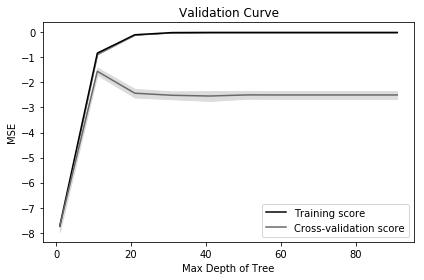

In [236]:
# Validation Curve
# Create range of values for parameter
param_range = np.arange(1, 100, 10)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(DecisionTreeRegressor(random_state=2019), 
                                             x_train2, 
                                             y_train2['fare_amount'], 
                                             param_name='max_depth', 
                                             param_range=param_range,
                                             cv=5, 
                                             scoring='neg_mean_squared_error', 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve")
plt.xlabel("Max Depth of Tree")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(loc="best")
plt.show();

### Hyperparameter Tuning (fare_amount)

To avoid overfitting the training data, the decision tree's freedom has to be restricted via regularization.
Increasing min_ or reducing max_ hyperparameters will regularize the model.

The following are the possible parameters that can be tuned:
* criterion: Regressor default='mse'; Classifier default='Gini', else='Entropy'
* max_depth: max. depth of the tree; Default=None;    
* max_leaf_nodes: max no. of leaf nodes; Default=None; 
* max_features: max no. of features to consider when looking for the best split; Default=None; 
* min_samples_split: min no. of samples required to split an internal node; Default=2; 
* min_samples_leaf: min no. of samples required to be at a leaf node; Default=1; 
* min_weight_fraction_leaf: fraction of total no. of weighted instances; Default=0.0

In [190]:
%%time
dtr = DecisionTreeRegressor(random_state=2019)

param_dist = {"max_depth": randint(1,50), # default=None
              "max_leaf_nodes": randint(2,100), # default=None
              "min_samples_split": randint(2,50), # default=2
              "min_samples_leaf": randint(2,100)} # default=1

# use RandomizedSearchCV for faster and effective performance
rs_dtr_f = RandomizedSearchCV(dtr, 
                              param_distributions=param_dist, 
                              n_iter=10,
                              scoring='neg_mean_squared_error',
                              cv=5)

rs_dtr_f.fit(x_train2, y_train2['fare_amount'])

# best params
print('Best Parameters: \n', rs_dtr_f.best_params_)

# MSE
print('MSE: ', abs(rs_dtr_f.best_score_))

# RMSE
print('RMSE: ', math.sqrt(abs(rs_dtr_f.best_score_)))

Best Parameters: 
 {'max_depth': 14, 'max_leaf_nodes': 74, 'min_samples_leaf': 53, 'min_samples_split': 13}
MSE:  1.55244986226109
RMSE:  1.2459734596937007
Wall time: 3min 57s


In [191]:
# save model to current directory
save_model = open("rs_dtr_f.pickle","wb") #binary write
pickle.dump(rs_dtr_f, save_model)
save_model.close()

In [192]:
# extract feature importances
feature_importances = pd.DataFrame(rs_dtr_f.best_estimator_.feature_importances_,
                                   index = x_train2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
trip_duration_h,0.768503
trip_distance,0.197153
dropoff_yr,0.033792
speed_mph,0.000552
"pickup_longxlat_(4, 1)",0.000000


In [221]:
# best model from hyperparameter tuning
best_dtr_f = rs_dtr_f.best_estimator_

# predict on validation set
y_pred_val_best_dtr_f = best_dtr_f.predict(x_val2)

# validation MSE
mse = mean_squared_error(y_val2['fare_amount'], y_pred_val_best_dtr_f)
print('Validation MSE: ', mse)

# predict on test set
y_pred_test_best_dtr_f = best_dtr_f.predict(x_test2)

# test mse
mse = mean_squared_error(y_test2['fare_amount'], y_pred_test_best_dtr_f)
print('Test MSE: ', mse)

Validation MSE:  1.711248248152386
Test MSE:  1.7353731836846904


### Default setting vs Hyperparameter tuning (fare_amount)
Large improvement in training and test MSE in the hyperparameter-tuned model: 
Training MSE 1.552 (tuned) vs 2.397 (default)
Test MSE 1.735 (tuned) vs 2.471 (default)

### Random Forest (fare_amount)

In [212]:
%%time
rfr = RandomForestRegressor(random_state=2019)

# narrow tree parameters based on best params of single-tree hyperparameter tuning

param_dist = {"n_estimators": randint(10,20),
              "max_depth": randint(5,30),
              "max_leaf_nodes": randint(80,100),
              "min_samples_split": randint(20,40),
              "min_samples_leaf": randint(80,100)}

# use RandomizedSearchCV for faster and effective performance
rs_rfr_f = RandomizedSearchCV(rfr, 
                              param_distributions=param_dist, 
                              n_iter=10,
                              scoring='neg_mean_squared_error',
                              cv=5,
                              n_jobs=-1)

rs_rfr_f.fit(x_train2, y_train2['fare_amount'])

# best params
print('Best Parameters: \n', rs_rfr_f.best_params_)

# MSE
print('MSE: ', abs(rs_rfr_f.best_score_))

# RMSE
print('RMSE: ', math.sqrt(abs(rs_rfr_f.best_score_)))

Best Parameters: 
 {'max_depth': 27, 'max_leaf_nodes': 95, 'min_samples_leaf': 84, 'min_samples_split': 28, 'n_estimators': 17}
MSE:  1.3948613988346046
RMSE:  1.1810425050922615
Wall time: 20min 14s


In [214]:
# extract feature importances
feature_importances = pd.DataFrame(rs_rfr_f.best_estimator_.feature_importances_,
                                   index = x_train2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
trip_duration_h,0.772212
trip_distance,0.194122
dropoff_yr,0.033220
speed_mph,0.000446
"pickup_longxlat_(4, 1)",0.000000


In [215]:
# save model to current directory
save_model = open("rs_rfr_f.pickle","wb") #binary write
pickle.dump(rs_rfr_f, save_model)
save_model.close()

In [222]:
# best model from ensemble learning
best_rfr_f = rs_rfr_f.best_estimator_

# predict on test set
y_pred_test_best_rfr_f = best_rfr_f.predict(x_test2)

# test mse
mse = mean_squared_error(y_test2['fare_amount'], y_pred_test_best_rfr_f)
print('Test MSE: ', mse)

Test MSE:  1.5836477560991855


### AdaBoost (fare_amount)

In [219]:
%%time

# The number of weak learners is controlled by the parameter n_estimators. 
# The main parameters to tune to obtain good results are n_estimators and the 
# complexity of the base estimators (e.g., its depth max_depth or 
# minimum required number of samples to consider a split min_samples_split).

abr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), 
                        random_state=2019)

param_dist = {"n_estimators": randint(50,55),
              "base_estimator__max_depth": randint(20,30),
              "base_estimator__max_leaf_nodes": randint(80,100),
              "base_estimator__min_samples_split": randint(20,40),
              "base_estimator__min_samples_leaf": randint(80,100)}

# use RandomizedSearchCV for faster and effective performance
rs_abr_f = RandomizedSearchCV(abr, 
                              param_distributions=param_dist, 
                              n_iter=5,
                              scoring='neg_mean_squared_error',
                              cv=5,
                              n_jobs=-1)

rs_abr_f.fit(x_train2, y_train2['fare_amount'])

# best params
print('Best Parameters: \n', rs_abr_f.best_params_)

# MSE
print('MSE: ', abs(rs_abr_f.best_score_))

# RMSE
print('RMSE: ', math.sqrt(abs(rs_abr_f.best_score_)))

# save model to current directory
save_model = open("rs_abr_f.pickle","wb") #binary write
pickle.dump(rs_abr_f, save_model)
save_model.close()

Best Parameters: 
 {'base_estimator__max_depth': 22, 'base_estimator__max_leaf_nodes': 96, 'base_estimator__min_samples_leaf': 87, 'base_estimator__min_samples_split': 39, 'n_estimators': 54}
MSE:  15.28048361731349
RMSE:  3.909025916684806
Wall time: 1h 29min 14s


In [223]:
# extract feature importances
feature_importances = pd.DataFrame(rs_abr_f.best_estimator_.feature_importances_,
                                   index = x_train2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
trip_duration_h,0.190195
trip_distance,0.184687
speed_mph,0.169500
dropoff_yr,0.096517
"pickup_longxlat_(0, 1)",0.049639


In [224]:
# best model from ensemble learning
best_abr_f = rs_abr_f.best_estimator_

# predict on test set
y_pred_test_best_abr_f = best_abr_f.predict(x_test2)

# test mse
mse = mean_squared_error(y_test2['fare_amount'], y_pred_test_best_abr_f)
print('Test MSE: ', mse)

Test MSE:  21.441893030022086


In [277]:
%%time
abr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), 
                        random_state=2019)

param_dist = {"n_estimators": randint(10,20),
              "learning_rate": uniform(0.01,0.1), # default=0.1; previous adaboost's mse is too high at 15.28; lower this
              "base_estimator__max_depth": randint(10,30),
              "base_estimator__min_samples_split": randint(20,40),
              "base_estimator__min_samples_leaf": randint(70,100)}

# use RandomizedSearchCV for faster and effective performance
rs_abr_f = RandomizedSearchCV(abr, 
                              param_distributions=param_dist, 
                              n_iter=5,
                              scoring='neg_mean_squared_error',
                              cv=5,
                              n_jobs=-1)

rs_abr_f.fit(x_train2, y_train2['fare_amount'])

# best params
print('Best Parameters: \n', rs_abr_f.best_params_)

# MSE
print('MSE: ', abs(rs_abr_f.best_score_))

# RMSE
print('RMSE: ', math.sqrt(abs(rs_abr_f.best_score_)))

# save model to current directory
save_model = open("rs_abr_f.pickle","wb") #binary write
pickle.dump(rs_abr_f, save_model)
save_model.close()

Best Parameters: 
 {'base_estimator__max_depth': 14, 'base_estimator__min_samples_leaf': 79, 'base_estimator__min_samples_split': 24, 'learning_rate': 0.02972058971295776, 'n_estimators': 11}
MSE:  1.249383277211313
RMSE:  1.1177581479064749
Wall time: 29min 20s


In [278]:
# extract feature importances
feature_importances = pd.DataFrame(rs_abr_f.best_estimator_.feature_importances_,
                                   index = x_train2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
trip_duration_h,0.761975
trip_distance,0.199095
dropoff_yr,0.036017
speed_mph,0.001682
pickup_overnight,0.000182


In [279]:
# best model from ensemble learning
best_abr_f = rs_abr_f.best_estimator_

# predict on test set
y_pred_test_best_abr_f = best_abr_f.predict(x_test2)

# test mse
mse = mean_squared_error(y_test2['fare_amount'], y_pred_test_best_abr_f)
print('Test MSE: ', mse)

Test MSE:  1.418674402553381


### Gradient Boosting (fare_amount)

In [279]:
%%time
gbr = GradientBoostingRegressor(random_state=2019)

param_dist= {"n_estimators": randint(100,110), # int. default=100
             "max_depth": randint(5,10),
             "min_leaf_nodes": randint(80,100),
             "min_samples_split": randint(20,40),
             "min_samples_leaf": randint(80,100)}

# use RandomizedSearchCV for faster and effective performance
rs_gbr_f = RandomizedSearchCV(gbr, 
                              param_distributions=param_dist, 
                              n_iter=10,
                              scoring='neg_mean_squared_error',
                              cv=5,
                              n_jobs=-1)

rs_gbr_f.fit(x_train2, y_train2['fare_amount'])

# best params
print('Best Parameters: \n', rs_gbr_f.best_params_)

# MSE
print('MSE: ', abs(rs_gbr_f.best_score_))

# RMSE
print('RMSE: ', math.sqrt(abs(rs_gbr_f.best_score_)))

# save model to current directory
save_model = open("rs_gbr_f.pickle","wb") #binary write
pickle.dump(rs_gbr_f, save_model)
save_model.close()

Best Parameters: 
 {'max_depth': 9, 'max_leaf_nodes': 88, 'min_samples_leaf': 95, 'min_samples_split': 28, 'n_estimators': 107}
MSE:  1.6862645346698588
RMSE:  1.2985624877801833
Wall time: 6h 34min 2s


In [184]:
%%time

# repeat gradient boosting 

gbr = GradientBoostingRegressor(random_state=2019)

param_dist= {"n_estimators": randint(10,20), # int. default=100
             # "learning_rate": uniform(0.01,0.1), too slow with gradient boosting
             "max_depth": randint(10,30),
             "min_samples_split": randint(20,40),
             "min_samples_leaf": randint(80,100)}

# use RandomizedSearchCV for faster and effective performance
rs_gbr_f = RandomizedSearchCV(gbr, 
                              param_distributions=param_dist, 
                              n_iter=4,
                              scoring='neg_mean_squared_error',
                              cv=4,
                              n_jobs=-1,
                              verbose=50,
                              random_state=2019)

rs_gbr_f.fit(x_train2, y_train2['fare_amount'])

# best params
print('Best Parameters: \n', rs_gbr_f.best_params_)

# MSE
print('MSE: ', abs(rs_gbr_f.best_score_))

# RMSE
print('RMSE: ', math.sqrt(abs(rs_gbr_f.best_score_)))

# save model to current directory
save_model = open("rs_gbr_f.pickle","wb") #binary write
pickle.dump(rs_gbr_f, save_model)
save_model.close()

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 215.8min
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed: 217.2min remaining: 1520.6min
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed: 252.0min remaining: 1092.0min
[Parallel(n_jobs=-1)]: Done   4 out of  16 | elapsed: 252.4min remaining: 757.1min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed: 352.3min remaining: 775.1min
[Parallel(n_jobs=-1)]: Done   6 out of  16 | elapsed: 352.8min remaining: 588.0min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed: 407.5min remaining: 524.0min
[Parallel(n_jobs=-1)]: Done   8 out of  16 | elapsed: 408.9min remaining: 408.9min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed: 520.0min remaining: 404.4min
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed: 522.0min remaining: 313.2min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed: 560.4min remaining: 254.7min
[Parallel(n_jobs=-1)]: Done  12 out of  16 | 

In [185]:
# extract feature importances
feature_importances = pd.DataFrame(rs_gbr_f.best_estimator_.feature_importances_,
                                   index = x_train2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
trip_duration_h,0.765692
trip_distance,0.188932
dropoff_yr,0.035800
speed_mph,0.003224
"pickup_longxlat_(2, 2)",0.001715


In [186]:
# best model from ensemble learning
best_gbr_f = rs_gbr_f.best_estimator_

# predict on test set
y_pred_test_best_gbr_f = best_gbr_f.predict(x_test2)

# test mse
mse = mean_squared_error(y_test2['fare_amount'], y_pred_test_best_gbr_f)
print('Test MSE: ', mse)

Test MSE:  1.732717155736228


## Target: tip_amount

### Baseline Model (tip_amount)

In [204]:
# fit linear regression model with dependent variables as 'trip_distance'
regr2 = LinearRegression()
regr2.fit(x_train1[['trip_distance']], y_train1['tip_amount'])

# predict using linear regression model
y_predict2 = regr2.predict(x_test1[['trip_distance']])

# get mse
mse = mean_squared_error(y_test1['tip_amount'], y_predict2)
print('MSE: ', mse)

# RMSE
print('RMSE: ', math.sqrt(mse))

MSE:  1.3054443598958274
RMSE:  1.1425604403688356


### Decision Tree (tip_amount)

In [195]:
# train on train11 variables
tree_reg_tip1 = DecisionTreeRegressor(random_state=2019)
tree_reg_tip1.fit(x_train1, y_train1['tip_amount'])

# predict on validation set
y_predict_val1_tip = tree_reg_tip1.predict(x_val1)

# validation mse
mse = mean_squared_error(y_val1['tip_amount'], y_predict_val1_tip)
print('MSE: ', mse)

MSE:  2.3221368565662233


In [196]:
# train on train21 variables
tree_reg_tip2 = DecisionTreeRegressor(random_state=2019)
tree_reg_tip2.fit(x_train2, y_train2['tip_amount'])

# predict on validation set
y_predict_val2_tip = tree_reg_tip2.predict(x_val2)

# validation mse
mse = mean_squared_error(y_val2['tip_amount'], y_predict_val2_tip)
print('MSE: ', mse)

# RMSE
print('RMSE: ', math.sqrt(mse))

MSE:  2.3487025625812565
RMSE:  1.5325477358246484


In [230]:
# predict on test set
y_predict_test2_tip = tree_reg_tip2.predict(x_test2)

# test mse
mse = mean_squared_error(y_test2['tip_amount'], y_predict_test2_tip)
print('Test MSE: ', mse)

# test RMSE
print('Test RMSE: ', math.sqrt(mse))

Test MSE:  2.271508799657589
Test RMSE:  1.507152546910096


In [198]:
# train on train31 variables
tree_reg_tip3 = DecisionTreeRegressor(random_state=2019)
tree_reg_tip3.fit(x_train3, y_train3['tip_amount'])

y_predict_val3_tip = tree_reg_tip3.predict(x_val3)

# validation mse
mse = mean_squared_error(y_val3['tip_amount'], y_predict_val3_tip)
print('MSE: ', mse)

MSE:  2.369219197906104


### Overfitting

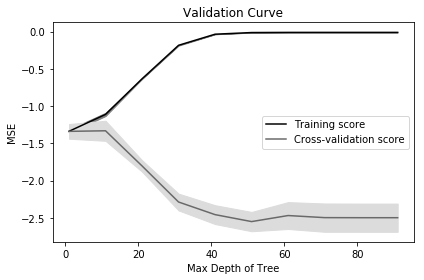

In [237]:
# Validation Curve
# Create range of values for parameter
param_range = np.arange(1, 100, 10)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(DecisionTreeRegressor(random_state=2019), 
                                             x_train2, 
                                             y_train2['tip_amount'], 
                                             param_name='max_depth', 
                                             param_range=param_range,
                                             cv=5, 
                                             scoring='neg_mean_squared_error', 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve")
plt.xlabel("Max Depth of Tree")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(loc="best")
plt.show();

### Variable selection for subsequent model building
The 2nd model trained on "train21" variables will be used for hyperparameter tuning and ensemble learning because it has the least number of variables and performed 2nd best out of the 3 models.

### Hyperparameter Tuning (tip_amount)

In [204]:
%%time

dtr = DecisionTreeRegressor(random_state=2019)

param_dist = {"max_depth": randint(1,50), # default=None
              "max_leaf_nodes": randint(2,100), # default=None
              "min_samples_split": randint(2,50), # default=2
              "min_samples_leaf": randint(2,100)} # default=1

# use RandomizedSearchCV for faster and effective performance
rs_dtr_t = RandomizedSearchCV(dtr, 
                              param_distributions=param_dist, 
                              n_iter=10,
                              scoring='neg_mean_squared_error',
                              cv=5)

rs_dtr_t.fit(x_train2, y_train2['tip_amount'])

# best params
print('Best Parameters: \n', rs_dtr_t.best_params_)

# MSE
print('MSE: ', abs(rs_dtr_t.best_score_))

# RMSE
print('RMSE: ', math.sqrt(abs(rs_dtr_t.best_score_)))

Best Parameters: 
 {'max_depth': 13, 'max_leaf_nodes': 88, 'min_samples_leaf': 7, 'min_samples_split': 43}
MSE:  1.2144587957784914
RMSE:  1.1020248616880162
Wall time: 4min 10s


In [205]:
# save model to current directory
save_model = open("rs_dtr_t.pickle","wb") #binary write
pickle.dump(rs_dtr_t, save_model)
save_model.close()

In [206]:
# extract feature importances
feature_importances = pd.DataFrame(rs_dtr_t.best_estimator_.feature_importances_,
                                   index = x_train2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
trip_distance,0.486440
dropoff_yr,0.344621
trip_duration_h,0.156939
"dropoff_longxlat_(2, 3)",0.003840
speed_mph,0.003103


In [207]:
# best model from hyperparameter tuning
best_dtr_t = rs_dtr_t.best_estimator_

# predict on validation set
y_pred_val_best_dtr_t = best_dtr_t.predict(x_val2)

# validation MSE
mse = mean_squared_error(y_val2['tip_amount'], y_pred_val_best_dtr_t)
print('Validation MSE: ', mse)

# predict on test set
y_pred_test_best_dtr_t = best_dtr_t.predict(x_test2)

# test mse
mse = mean_squared_error(y_test2['tip_amount'], y_pred_test_best_dtr_t)
print('Test MSE: ', mse)

Validation MSE:  1.2424426658242997
Test MSE:  1.2224831992679448


### Default setting vs Hyperparameter tuning (tip_amount)
Large improvement in training and test MSE in the hyperparameter-tuned model: 
Training MSE 1.214 (tuned) vs 2.349 (default)
Test MSE 1.222 (tuned) vs 2.272 (default) 

### Random Forest (tip_amount)

In [213]:
%%time
rfr = RandomForestRegressor(random_state=2019)

param_dist = {"n_estimators": randint(10,20),
              "max_depth": randint(5,30),
              "max_leaf_nodes": randint(80,100),
              "min_samples_split": randint(20,40),
              "min_samples_leaf": randint(80,100)}

# use RandomizedSearchCV for faster and effective performance
rs_rfr_t = RandomizedSearchCV(rfr, 
                              param_distributions=param_dist, 
                              n_iter=10,
                              scoring='neg_mean_squared_error',
                              cv=5,
                              n_jobs=-1)

rs_rfr_t.fit(x_train2, y_train2['tip_amount'])

# best params
print('Best Parameters: \n', rs_rfr_t.best_params_)

# MSE
print('MSE: ', abs(rs_rfr_t.best_score_))

# RMSE
print('RMSE: ', math.sqrt(abs(rs_rfr_t.best_score_)))

# save model to current directory
save_model = open("rs_rfr_t.pickle","wb") #binary write
pickle.dump(rs_rfr_t, save_model)
save_model.close()

Best Parameters: 
 {'max_depth': 29, 'max_leaf_nodes': 98, 'min_samples_leaf': 80, 'min_samples_split': 37, 'n_estimators': 18}
MSE:  1.2063085723260565
RMSE:  1.0983207966373287
Wall time: 19min 19s


In [220]:
# extract feature importances
feature_importances = pd.DataFrame(rs_rfr_t.best_estimator_.feature_importances_,
                                   index = x_train2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
trip_distance,0.401236
dropoff_yr,0.334921
trip_duration_h,0.249737
speed_mph,0.004130
passenger_count,0.001853


In [218]:
# predict on test set using best model from ensemble learning
y_pred_test_best_rfr_t = rs_rfr_t.best_estimator_.predict(x_test2)

# test mse
mse = mean_squared_error(y_test2['tip_amount'], y_pred_test_best_rfr_t)
print('Test MSE: ', mse)

Test MSE:  1.2146892227010757


### AdaBoost (tip_amount)

In [226]:
%%time
abr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), 
                        random_state=2019)

param_dist = {"n_estimators": randint(10,20),
              "learning_rate": uniform(0.01,0.1), # default=0.1
              "base_estimator__max_depth": randint(10,30),
              "base_estimator__min_samples_split": randint(20,40),
              "base_estimator__min_samples_leaf": randint(70,100)}

# use RandomizedSearchCV for faster and effective performance
rs_abr_t = RandomizedSearchCV(abr, 
                              param_distributions=param_dist, 
                              n_iter=5,
                              scoring='neg_mean_squared_error',
                              cv=5,
                              n_jobs=-1,
                              random_state=2019)

rs_abr_t.fit(x_train2, y_train2['tip_amount'])

# best params
print('Best Parameters: \n', rs_abr_t.best_params_)

# MSE
print('MSE: ', abs(rs_abr_t.best_score_))

# RMSE
print('RMSE: ', math.sqrt(abs(rs_abr_t.best_score_)))

# save model to current directory
save_model = open("rs_abr_t.pickle","wb") #binary write
pickle.dump(rs_abr_t, save_model)
save_model.close()

Best Parameters: 
 {'base_estimator__max_depth': 15, 'base_estimator__min_samples_leaf': 89, 'base_estimator__min_samples_split': 32, 'learning_rate': 0.012132295409177698, 'n_estimators': 15}
MSE:  1.2044378475580504
RMSE:  1.0974688367138496
Wall time: 38min 41s


In [227]:
# extract feature importances
feature_importances = pd.DataFrame(rs_abr_t.best_estimator_.feature_importances_,
                                   index = x_train2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
trip_distance,0.330527
dropoff_yr,0.266078
trip_duration_h,0.258583
speed_mph,0.055811
passenger_count,0.014437


In [228]:
# predict on test set using best model from ensemble learning
y_pred_test_best_abr_t = rs_abr_t.best_estimator_.predict(x_test2)

# test mse
mse = mean_squared_error(y_test2['tip_amount'], y_pred_test_best_abr_t)
print('Test MSE: ', mse)

Test MSE:  1.2100936140899368


### Gradient Boosting (tip_amount)

In [280]:
%%time
gbr = GradientBoostingRegressor(random_state=2019)

param_dist= {"n_estimators": randint(10,20), # int. default=100
             "learning_rate": uniform(0.01,0.1),
             "max_depth": randint(10,30),
             "min_samples_split": randint(20,40),
             "min_samples_leaf": randint(80,100)}

# use RandomizedSearchCV for faster and effective performance
rs_gbr_t = RandomizedSearchCV(gbr, 
                              param_distributions=param_dist, 
                              n_iter=5,
                              scoring='neg_mean_squared_error',
                              cv=5,
                              n_jobs=-1, 
                              random_state=2019)

rs_gbr_t.fit(x_train2, y_train2['tip_amount'])

# best params
print('Best Parameters: \n', rs_gbr_t.best_params_)

# MSE
print('MSE: ', abs(rs_gbr_t.best_score_))

# RMSE
print('RMSE: ', math.sqrt(abs(rs_gbr_t.best_score_)))

# save model to current directory
save_model = open("rs_gbr_t.pickle","wb") #binary write
pickle.dump(rs_gbr_t, save_model)
save_model.close()

Best Parameters: 
 {'learning_rate': 0.10034822144192744, 'max_depth': 15, 'min_samples_leaf': 95, 'min_samples_split': 32, 'n_estimators': 10}
MSE:  1.2259319891006673
RMSE:  1.1072181307676763
Wall time: 13h 9min 4s


In [418]:
# Load pickled model
pickled_model = open("rs_gbr_t.pickle", "rb") #binary read
rs_gbr_t = pickle.load(pickled_model)
pickled_model.close()

In [419]:
# extract feature importances
feature_importances = pd.DataFrame(rs_gbr_t.best_estimator_.feature_importances_,
                                   index = x_train2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
trip_distance,0.405368
dropoff_yr,0.270690
trip_duration_h,0.163616
speed_mph,0.055610
passenger_count,0.016449


In [420]:
# predict on test set using best model from ensemble learning
y_pred_test_best_gbr_t = rs_gbr_t.best_estimator_.predict(x_test2)

# test mse
mse = mean_squared_error(y_test2['tip_amount'], y_pred_test_best_gbr_t)
print('Test MSE: ', mse)

Test MSE:  1.234623955913578


## Target: tip_paid

### Baseline Model (tip_paid)

In [626]:
# fit logistic regression model with dependent variables as 'trip_distance'
regr3 = LogisticRegression()
regr3.fit(x_train1[['trip_distance']], y_train1['tip_paid'])

# predict using linear regression model
y_predict3 = regr3.predict(x_test1[['trip_distance']])

# accuracy score
accuracy = accuracy_score(y_test1['tip_paid'], y_predict3)
print('Accuracy: ', accuracy)

# roc auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1['tip_paid'], y_predict3)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('ROC AUC Score: ', roc_auc)

# ROC AUC score
roc_auc = roc_auc_score(y_test1['tip_paid'], y_predict3)
print('ROC AUC Score: ', roc_auc)

Accuracy: 0.5787009783309506
ROC AUC Score: 0.5152663826675392


### Decision Tree (tip_paid)

In [200]:
# train on train11 variables
tree_clf_tipp1 = DecisionTreeClassifier(random_state=2019)
tree_clf_tipp1.fit(x_train1, y_train1['tip_paid'])

# predict on validation set
y_predict_val1_tipp = tree_clf_tipp1.predict(x_val1)

# accuracy score
accuracy = accuracy_score(y_val1['tip_paid'], y_predict_val1_tipp)
print('Accuracy: ', accuracy)

# precision
precision = precision_score(y_val1['tip_paid'], y_predict_val1_tipp)
print('Precision: ', precision)

# recall
recall = recall_score(y_val1['tip_paid'], y_predict_val1_tipp)
print('Recall: ', recall)

# ROC AUC score
roc_auc = roc_auc_score(y_val1['tip_paid'], y_predict_val1_tipp)
print('ROC AUC Score: ', roc_auc)

Accuracy:  0.5564230613495021
Precision:  0.47529971315795927
Recall:  0.47623375666314577
ROC AUC Score:  0.5456805382366225


In [201]:
# train on train21 variables
tree_clf_tipp2 = DecisionTreeClassifier(random_state=2019)
tree_clf_tipp2.fit(x_train2, y_train2['tip_paid'])

# predict on validation set
y_predict_val2_tipp = tree_clf_tipp2.predict(x_val2)

# accuracy score
accuracy = accuracy_score(y_val2['tip_paid'], y_predict_val2_tipp)
print('Accuracy: ', accuracy)

# precision
precision = precision_score(y_val2['tip_paid'], y_predict_val2_tipp)
print('Precision: ', precision)

# recall
recall = recall_score(y_val2['tip_paid'], y_predict_val2_tipp)
print('Recall: ', recall)

# ROC AUC score
roc_auc = roc_auc_score(y_val2['tip_paid'], y_predict_val2_tipp)
print('ROC AUC Score: ', roc_auc)

Accuracy:  0.5527061681738427
Precision:  0.47090984872630987
Recall:  0.471812129995824
ROC AUC Score:  0.5418692357647081


In [232]:
# predict on test set
y_predict_test2_tipp = tree_clf_tipp2.predict(x_test2)

# ROC AUC score
roc_auc = roc_auc_score(y_test2['tip_paid'], y_predict_test2_tipp)
print('Test ROC AUC Score: ', roc_auc)

Test ROC AUC Score:  0.5394778464551471


In [202]:
# train on train31 variables
tree_clf_tipp3 = DecisionTreeClassifier(random_state=2019)
tree_clf_tipp3.fit(x_train3, y_train3['tip_paid'])

# predict on validation set
y_predict_val3_tipp = tree_clf_tipp3.predict(x_val3)

# accuracy score
accuracy = accuracy_score(y_val3['tip_paid'], y_predict_val3_tipp)
print('Accuracy: ', accuracy)

# precision
precision = precision_score(y_val3['tip_paid'], y_predict_val3_tipp)
print('Precision: ', precision)

# recall
recall = recall_score(y_val3['tip_paid'], y_predict_val3_tipp)
print('Recall: ', recall)

# ROC AUC score
roc_auc = roc_auc_score(y_val3['tip_paid'], y_predict_val3_tipp)
print('ROC AUC Score: ', roc_auc)

Accuracy:  0.5525089028935702
Precision:  0.47032699846176745
Recall:  0.4656709818467661
ROC AUC Score:  0.5408757009651036


### Overfitting

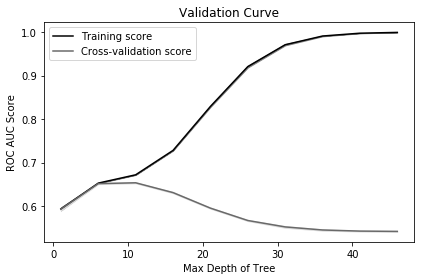

In [238]:
# Validation Curve
# Create range of values for parameter
param_range = np.arange(1, 50, 5)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(DecisionTreeRegressor(random_state=2019), 
                                             x_train2, 
                                             y_train2['tip_paid'], 
                                             param_name='max_depth', 
                                             param_range=param_range,
                                             cv=5, 
                                             scoring='roc_auc', 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve")
plt.xlabel("Max Depth of Tree")
plt.ylabel("ROC AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show();

### Variable selection for subsequent model building
The 2nd model trained on "train21" variables will be used for hyperparameter tuning and ensemble learning because it has the least number of variables and performed 2nd best out of the 3 models.

### Hyperparameter Tuning (tip_paid)

In [208]:
%%time
dtc = DecisionTreeClassifier(random_state=2019)

param_dist = {"max_depth": randint(1,50), # default=None
              "max_leaf_nodes": randint(2,100), # default=None
              "min_samples_split": randint(2,50), # default=2
              "min_samples_leaf": randint(2,100)} # default=1

rs_dtc = RandomizedSearchCV(dtc, 
                            param_distributions=param_dist, 
                            n_iter=10,
                            scoring='roc_auc',
                            cv=5)

rs_dtc.fit(x_train2, y_train2['tip_paid'])

# best score
print('Best Score: ', rs_dtc.best_score_)

# best params
print('Best Parameters: \n', rs_dtc.best_params_)

Best Score:  0.6552788384856583
Best Parameters: 
 {'max_depth': 26, 'max_leaf_nodes': 97, 'min_samples_leaf': 61, 'min_samples_split': 9}
Wall time: 3min 58s


In [209]:
# save model to current directory
save_model = open("rs_dtc.pickle","wb") #binary write
pickle.dump(rs_dtc, save_model)
save_model.close()

In [210]:
# extract feature importances
feature_importances = pd.DataFrame(rs_dtc.best_estimator_.feature_importances_,
                                   index = x_train2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
dropoff_yr,0.701798
trip_distance,0.193911
passenger_count,0.021774
"pickup_longxlat_(0, 1)",0.017282
pickup_weekday,0.016969


In [211]:
# best model from hyperparameter tuning
best_dtc = rs_dtc.best_estimator_

# predict on validation set
y_pred_val_best_dtc = best_dtc.predict(x_val2)

# ROC AUC score
roc_auc = roc_auc_score(y_val2['tip_paid'], y_pred_val_best_dtc)
print('ROC AUC Score (Val): ', roc_auc)

# predict on test set
y_pred_test_best_dtc = best_dtc.predict(x_test2)

# ROC AUC score
roc_auc = roc_auc_score(y_test2['tip_paid'], y_pred_test_best_dtc)
print('ROC AUC Score (Test): ', roc_auc)

ROC AUC Score (Val):  0.5963728028944759
ROC AUC Score (Test):  0.5985538698603449


### Default setting vs Hyperparameter tuning (tip_paid)
* Some improvement in training ROC AUC score in the hyperparameter-tuned model: 
* Training ROC AUC score 0.655 (tuned) vs 0.542 (default)
* No improvement in test ROC AUC score in the hyperparameter-tuned model: 
* Test ROC AUC score 0.599 (tuned) vs 0.539 (default)
* Without presence of "payment_type" variable, it seems like the variables in the model can at best provide a random guess.

### Random Forest (tip_paid)

In [217]:
%%time
rfc = RandomForestClassifier(random_state=2019)

param_dist = {"n_estimators": randint(10,20),
              "max_depth": randint(5,30),
              "max_leaf_nodes": randint(80,100),
              "min_samples_split": randint(20,40),
              "min_samples_leaf": randint(80,100)}

# use RandomizedSearchCV for faster and effective performance
rs_rfc = RandomizedSearchCV(rfc, 
                            param_distributions=param_dist, 
                            n_iter=10,
                            scoring='roc_auc',
                            cv=5,
                            n_jobs=-1)

rs_rfc.fit(x_train2, y_train2['tip_paid'])

# best params
print('Best Parameters: \n', rs_rfc.best_params_)

# ROC AUC score
print('ROC AUC Score: ', rs_rfc.best_score_)

# save model to current directory
save_model = open("rs_rfc.pickle","wb") #binary write
pickle.dump(rs_rfc, save_model)
save_model.close()

Best Parameters: 
 {'max_depth': 28, 'max_leaf_nodes': 84, 'min_samples_leaf': 84, 'min_samples_split': 24, 'n_estimators': 18}
ROC AUC Score:  0.655926610861196
Wall time: 4min 40s


In [225]:
# extract feature importances
feature_importances = pd.DataFrame(rs_rfc.best_estimator_.feature_importances_,
                                   index = x_train2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
dropoff_yr,0.590252
trip_distance,0.134035
trip_duration_h,0.097632
passenger_count,0.031561
"dropoff_longxlat_(0, 1)",0.021171


In [32]:
# Load pickled model
pickled_model = open("rs_rfc.pickle", "rb") #binary read
rs_rfc = pickle.load(pickled_model)
pickled_model.close()

In [263]:
# predict on test set using best model from ensemble learning
y_pred_test_best_rfc = rs_rfc.best_estimator_.predict(x_test2)

# test mse (eval metric should not be mse)
#mse = mean_squared_error(y_test2['tip_paid'], y_pred_test_best_rfc)
#print('Test MSE: ', mse)

Test MSE:  0.38037170969640904


In [ ]:
# predict on validation set
y_pred_val_best_dtc = best_dtc.predict(x_val2)

# ROC AUC score
roc_auc = roc_auc_score(y_val2['tip_paid'], y_pred_val_best_dtc)
print('ROC AUC Score (Val): ', roc_auc)

# predict on test set
y_pred_test_best_dtc = best_dtc.predict(x_test2)

# ROC AUC score
roc_auc = roc_auc_score(y_test2['tip_paid'], y_pred_test_best_dtc)
print('ROC AUC Score (Test): ', roc_auc)

### AdaBoost (tip_paid)

In [241]:
%%time
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), 
                        random_state=2019)

param_dist = {"n_estimators": randint(10,20),
              "learning_rate": uniform(0.01,0.1), # default=0.1
              "base_estimator__max_depth": randint(10,30),
              "base_estimator__min_samples_split": randint(20,40),
              "base_estimator__min_samples_leaf": randint(70,100)}

# use RandomizedSearchCV for faster and effective performance
rs_abc = RandomizedSearchCV(abc, 
                            param_distributions=param_dist, 
                            n_iter=5,
                            scoring='roc_auc',
                            cv=5,
                            n_jobs=-1,
                            random_state=2019)

rs_abc.fit(x_train2, y_train2['tip_paid'])

# best params
print('Best Parameters: \n', rs_abc.best_params_)

# ROC AUC score
print('ROC AUC Score: ', rs_abc.best_score_)

# save model to current directory
save_model = open("rs_abc.pickle","wb") #binary write
pickle.dump(rs_abc, save_model)
save_model.close()

Best Parameters: 
 {'base_estimator__max_depth': 18, 'base_estimator__min_samples_leaf': 88, 'base_estimator__min_samples_split': 25, 'learning_rate': 0.07239699612977533, 'n_estimators': 16}
ROC AUC Score:  0.6576005799960809
Wall time: 39min 31s


In [242]:
# extract feature importances
feature_importances = pd.DataFrame(rs_abc.best_estimator_.feature_importances_,
                                   index = x_train2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
dropoff_yr,0.366899
trip_distance,0.180801
speed_mph,0.143338
trip_duration_h,0.092271
passenger_count,0.030886


In [243]:
# predict on test set using best model from ensemble learning
y_pred_test_best_abc = rs_abc.best_estimator_.predict(x_test2)

# test mse (eval metric should not be mse)
#mse = mean_squared_error(y_test2['tip_paid'], y_pred_test_best_abc)
#print('Test MSE: ', mse)

Test MSE:  0.3745222810902737


### Gradient Boosting (tip_paid)

In [181]:
%%time
gbc = GradientBoostingClassifier(random_state=2019)

param_dist= {"n_estimators": randint(10,20), # int. default=100
             # "learning_rate": uniform(0.01,0.1), too slow with gradient boosting
             "max_depth": randint(10,30),
             "min_samples_split": randint(20,40),
             "min_samples_leaf": randint(80,100)}

# use RandomizedSearchCV for faster and effective performance
rs_gbc = RandomizedSearchCV(gbc, 
                            param_distributions=param_dist, 
                            n_iter=4,
                            scoring='roc_auc',
                            cv=4,
                            n_jobs=-1,
                            verbose=2,
                            random_state=2019)

rs_gbc.fit(x_train2, y_train2['tip_paid'])

# best params
print('Best Parameters: \n', rs_gbc.best_params_)

# ROC AUC score
print('ROC AUC Score: ', rs_gbc.best_score_)

# save model to current directory
save_model = open("rs_gbc.pickle","wb") #binary write
pickle.dump(rs_gbc, save_model)
save_model.close()

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed: 422.8min remaining: 253.7min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 446.1min finished


Best Parameters: 
 {'max_depth': 18, 'min_samples_leaf': 98, 'min_samples_split': 25, 'n_estimators': 18}
ROC AUC Score:  0.6587775533875533
Wall time: 8h 36min 19s


In [182]:
# extract feature importances
feature_importances = pd.DataFrame(rs_gbc.best_estimator_.feature_importances_,
                                   index = x_train2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
dropoff_yr,0.320547
trip_distance,0.172853
speed_mph,0.171003
trip_duration_h,0.105697
passenger_count,0.030713


In [183]:
# predict on test set using best model from ensemble learning
y_pred_test_best_gbc = rs_gbc.best_estimator_.predict(x_test2)

# test mse (eval metric should not be mse)
#mse = mean_squared_error(y_test2['tip_paid'], y_pred_test_best_gbc)
#print('Test MSE: ', mse)

Test MSE:  0.37492407890187723


## Transformation of taxi-test.csv & Best Guesses for taxi-test.csv

In [189]:
test = pd.read_csv("Q2data/taxi-test.csv")

In [190]:
test.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type
0,VTS,2009-03-19 15:13:00+00:00,2009-03-19 15:23:00+00:00,-73.988103,40.759927,-73.974167,40.753982,NaN,1,0.83,CRD
1,CMT,2009-10-26 08:38:03+00:00,2009-10-26 08:45:14+00:00,-73.975350,40.757593,-73.974171,40.764106,NaN,1,0.90,CSH
2,CMT,2015-06-12 07:15:51+00:00,2015-06-12 07:25:29+00:00,-73.957085,40.777405,-73.987869,40.764839,1.0,1,2.70,CSH
3,CMT,2012-06-08 22:01:46+00:00,2012-06-08 22:08:41+00:00,-73.976360,40.764031,-73.963705,40.774263,1.0,2,1.20,CSH
4,CMT,2009-08-10 20:10:37+00:00,2009-08-10 20:13:50+00:00,-73.988565,40.748896,-73.990490,40.756525,NaN,2,0.70,CSH


In [191]:
# divide pickup longitude into 5 buckets
test['pickup_long'] = pd.cut(test['pickup_longitude'],5,labels=False) 

In [192]:
# divide pickup latitude into 5 buckets
test['pickup_lat'] = pd.cut(test['pickup_latitude'],5,labels=False)

In [193]:
# divide dropoff longitude into 5 buckets
test['dropoff_long'] = pd.cut(test['dropoff_longitude'],5,labels=False)

In [194]:
# divide dropoff latitude into 5 buckets
test['dropoff_lat'] = pd.cut(test['dropoff_latitude'],5,labels=False)

In [195]:
# constructs a 5x5 grid for pickup via cartesian product of long x lat
test['pickup_longxlat'] = list(test[['pickup_long','pickup_lat']].itertuples(index=False, name=None))

In [196]:
# constructs a 5x5 grid for dropoff via cartesian product of long x lat
test['dropoff_longxlat'] = list(test[['dropoff_long','dropoff_lat']].itertuples(index=False, name=None))

In [197]:
# if trip starts and ends in the same pickup grid
test['pickup=dropoff_longxlat'] = np.where(test['pickup_longxlat'] == test['dropoff_longxlat'],1,0)

In [198]:
# convert pickup_datetime, dropoff_datetime to datetime data type
test['pickup_dt'] = pd.to_datetime(test.pickup_datetime)
test['dropoff_dt'] = pd.to_datetime(test.dropoff_datetime)

In [199]:
# convert existing UTC timezone to US/Eastern timezone
test['pickup_dt_local'] = test['pickup_dt'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
test['dropoff_dt_local'] = test['dropoff_dt'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

In [200]:
# hour
test['pickup_hr'] = test['pickup_dt_local'].dt.hour

In [201]:
# identify start and end date of the test dataset
test['pickup_dt_local'].sort_values()

4549    2009-01-01 08:52:28-05:00
6458    2009-01-01 08:52:28-05:00
6694    2009-01-01 09:28:00-05:00
5646    2009-01-01 11:58:00-05:00
1675    2009-01-01 17:22:52-05:00
586     2009-01-02 06:05:00-05:00
4378    2009-01-02 14:47:35-05:00
4103    2009-01-03 05:10:00-05:00
8386    2009-01-03 05:10:00-05:00
707     2009-01-03 05:10:00-05:00
5906    2009-01-03 08:28:52-05:00
6382    2009-01-03 12:49:00-05:00
5826    2009-01-03 12:49:00-05:00
9111    2009-01-03 12:49:00-05:00
5963    2009-01-04 08:28:20-05:00
851     2009-01-04 09:36:40-05:00
173     2009-01-04 23:54:00-05:00
6642    2009-01-05 06:47:48-05:00
6035    2009-01-05 16:20:00-05:00
1981    2009-01-05 16:20:00-05:00
3662    2009-01-05 17:01:47-05:00
2343    2009-01-05 18:37:49-05:00
5887    2009-01-06 02:34:56-05:00
10481   2009-01-06 02:48:00-05:00
3795    2009-01-06 02:48:00-05:00
5971    2009-01-06 02:48:00-05:00
1450    2009-01-06 06:02:19-05:00
975     2009-01-06 14:08:38-05:00
4109    2009-01-06 17:16:00-05:00
1698    2009-0

In [202]:
# holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start='2009-01-01', end='2015-06-30')

test['pickup_hol'] = np.where(test['pickup_dt_local'].dt.date.astype('datetime64').isin(holidays),1,0)

In [203]:
# extract day of week
# Series.dt.weekday	The day of the week with Monday=0, Sunday=6
test['pickup_wkday'] = test['pickup_dt_local'].dt.weekday

In [204]:
# pickup_weekday
wkday = [0,1,2,3,4]
test['pickup_weekday'] = np.where(test['pickup_wkday'].isin(wkday),1,0)

In [205]:
# overnight surcharge 8pm to 6am
overnight = [20,21,22,23,0,1,2,3,4,5,6]
test['pickup_overnight'] = np.where(test['pickup_hr'].isin(overnight),1,0)

In [206]:
# rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays
# Satisfy the following conditions: rush_hr = [16,17,18,19], wkday = [0,1,2,3,4], hol = [0]
# True & True & True = True; and False & False & False = False
rush_hr = [16,17,18,19]
wkday = [0,1,2,3,4]
hol = [0]
test['pickup_rush'] = np.where(test['pickup_hr'].isin(rush_hr) & test['pickup_wkday'].isin(wkday) & test['pickup_hol'].isin(hol),1,0)

In [207]:
# morning
am = [7,8,9,10,11]
test['pickup_7-11'] = np.where(test['pickup_hr'].isin(am),1,0)

In [208]:
# afternoon
pm = [12,13,14,15]
test['pickup_12-15'] = np.where(test['pickup_hr'].isin(pm),1,0)

In [209]:
# year
test['dropoff_yr'] = test['dropoff_dt_local'].dt.year

In [210]:
# trip duration (dropoff minus pickup yields a timedelta64 data type)
test['trip_duration'] = test['dropoff_dt_local'] - test['pickup_dt_local']

In [211]:
# convert timedelta to hours so that speed can be computed
test['trip_duration_h'] = (test['trip_duration'].dt.total_seconds()) / 3600

In [212]:
# check if any trip duration is <=0 because speed will be infinity
len(test[test['trip_duration_h']<=0])

3

In [213]:
test[test['trip_duration_h']<=0]

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,pickup_hol,pickup_wkday,pickup_weekday,pickup_overnight,pickup_rush,pickup_7-11,pickup_12-15,dropoff_yr,trip_duration,trip_duration_h
151,VTS,2009-01-14 21:38:00+00:00,2009-01-14 21:35:00+00:00,-73.980647,40.751233,-73.970413,40.754730,NaN,2,1.06,...,0,2,1,0,1,0,0,2009,-1 days +23:57:00,-0.050000
290,VTS,2009-01-21 15:18:00+00:00,2009-01-21 15:13:00+00:00,-73.968700,40.791192,-73.974182,40.795712,NaN,3,0.56,...,0,2,1,0,0,1,0,2009,-1 days +23:55:00,-0.083333
7017,VTS,2010-08-04 14:53:00+00:00,2010-08-04 14:53:00+00:00,-73.971763,40.794490,-73.969753,40.797255,1.0,1,0.22,...,0,2,1,0,0,1,0,2010,00:00:00,0.000000


In [214]:
test['trip_duration_h'].mean()

0.17096201206747835

In [215]:
test.loc[(test['trip_duration_h']<=0),'trip_duration_h']

151    -0.050000
290    -0.083333
7017    0.000000
Name: trip_duration_h, dtype: float64

In [216]:
# replace trip duration is <=0 with mean values
test.loc[(test['trip_duration_h']<=0),'trip_duration_h'] = test['trip_duration_h'].mean()

In [217]:
test['trip_duration_h'].describe()

count    10828.000000
mean         0.171022
std          0.106526
min          0.010556
25%          0.098333
50%          0.150000
75%          0.216667
max          1.100000
Name: trip_duration_h, dtype: float64

In [218]:
# overall speed miles/hr
test['speed_mph'] = test['trip_distance'] / test['trip_duration_h']

In [219]:
# double check for infinity values
test['speed_mph'].describe()

count    10828.000000
mean        11.397005
std          4.929836
min          1.038961
25%          8.023774
50%         10.640000
75%         13.886096
max         74.100000
Name: speed_mph, dtype: float64

In [220]:
test.dtypes

vendor_id                                      object
pickup_datetime                                object
dropoff_datetime                               object
pickup_longitude                              float64
pickup_latitude                               float64
dropoff_longitude                             float64
dropoff_latitude                              float64
rate_code                                     float64
passenger_count                                 int64
trip_distance                                 float64
payment_type                                   object
pickup_long                                     int64
pickup_lat                                      int64
dropoff_long                                    int64
dropoff_lat                                     int64
pickup_longxlat                                object
dropoff_longxlat                               object
pickup=dropoff_longxlat                         int32
pickup_dt                   

In [221]:
# select variables
test2 = test.loc[:,['vendor_id',
                    'trip_distance', 
                    'pickup_7-11', 
                    'pickup_12-15', 
                    'pickup_weekday',
                    'pickup_rush', 
                    'pickup_overnight',
                    'pickup_hol', 
                    'dropoff_yr',
                    'passenger_count',
                    'trip_duration_h', 
                    'speed_mph', 
                    'pickup_longxlat', 
                    'dropoff_longxlat',
                    'pickup=dropoff_longxlat']]

In [222]:
test2.dtypes

vendor_id                   object
trip_distance              float64
pickup_7-11                  int32
pickup_12-15                 int32
pickup_weekday               int32
pickup_rush                  int32
pickup_overnight             int32
pickup_hol                   int32
dropoff_yr                   int64
passenger_count              int64
trip_duration_h            float64
speed_mph                  float64
pickup_longxlat             object
dropoff_longxlat            object
pickup=dropoff_longxlat      int32
dtype: object

In [223]:
# one hot encode categorical variables
test3 = pd.get_dummies(test2)

In [224]:
test3.columns

Index(['trip_distance', 'pickup_7-11', 'pickup_12-15', 'pickup_weekday',
       'pickup_rush', 'pickup_overnight', 'pickup_hol', 'dropoff_yr',
       'passenger_count', 'trip_duration_h', 'speed_mph',
       'pickup=dropoff_longxlat', 'vendor_id_CMT', 'vendor_id_DDS',
       'vendor_id_VTS', 'pickup_longxlat_(0, 0)', 'pickup_longxlat_(0, 1)',
       'pickup_longxlat_(0, 2)', 'pickup_longxlat_(0, 3)',
       'pickup_longxlat_(0, 4)', 'pickup_longxlat_(1, 0)',
       'pickup_longxlat_(1, 1)', 'pickup_longxlat_(1, 2)',
       'pickup_longxlat_(1, 3)', 'pickup_longxlat_(1, 4)',
       'pickup_longxlat_(2, 0)', 'pickup_longxlat_(2, 1)',
       'pickup_longxlat_(2, 2)', 'pickup_longxlat_(2, 3)',
       'pickup_longxlat_(2, 4)', 'pickup_longxlat_(3, 0)',
       'pickup_longxlat_(3, 1)', 'pickup_longxlat_(3, 2)',
       'pickup_longxlat_(3, 3)', 'pickup_longxlat_(3, 4)',
       'pickup_longxlat_(4, 0)', 'pickup_longxlat_(4, 2)',
       'pickup_longxlat_(4, 3)', 'dropoff_longxlat_(0, 0)',
     

In [225]:
x_test2.columns

Index(['trip_distance', 'pickup_7-11', 'pickup_12-15', 'pickup_weekday',
       'pickup_rush', 'pickup_overnight', 'pickup_hol', 'dropoff_yr',
       'passenger_count', 'trip_duration_h', 'speed_mph',
       'pickup=dropoff_longxlat', 'vendor_id_CMT', 'vendor_id_DDS',
       'vendor_id_VTS', 'pickup_longxlat_(0, 0)', 'pickup_longxlat_(0, 1)',
       'pickup_longxlat_(0, 2)', 'pickup_longxlat_(0, 3)',
       'pickup_longxlat_(0, 4)', 'pickup_longxlat_(1, 0)',
       'pickup_longxlat_(1, 1)', 'pickup_longxlat_(1, 2)',
       'pickup_longxlat_(1, 3)', 'pickup_longxlat_(1, 4)',
       'pickup_longxlat_(2, 0)', 'pickup_longxlat_(2, 1)',
       'pickup_longxlat_(2, 2)', 'pickup_longxlat_(2, 3)',
       'pickup_longxlat_(2, 4)', 'pickup_longxlat_(3, 0)',
       'pickup_longxlat_(3, 1)', 'pickup_longxlat_(3, 2)',
       'pickup_longxlat_(3, 3)', 'pickup_longxlat_(3, 4)',
       'pickup_longxlat_(4, 0)', 'pickup_longxlat_(4, 1)',
       'pickup_longxlat_(4, 2)', 'pickup_longxlat_(4, 3)',
      

In [226]:
# comparing test3 with x_test2 dataframe columns, 2 cols are missing in the test dataset:
# 'pickup_longxlat_(4, 1)'
# 'pickup_longxlat_(4, 4)'
# add both cols with 0 values to test3
test3['pickup_longxlat_(4, 1)'] = 0
test3['pickup_longxlat_(4, 4)'] = 0

In [227]:
test3.columns

Index(['trip_distance', 'pickup_7-11', 'pickup_12-15', 'pickup_weekday',
       'pickup_rush', 'pickup_overnight', 'pickup_hol', 'dropoff_yr',
       'passenger_count', 'trip_duration_h', 'speed_mph',
       'pickup=dropoff_longxlat', 'vendor_id_CMT', 'vendor_id_DDS',
       'vendor_id_VTS', 'pickup_longxlat_(0, 0)', 'pickup_longxlat_(0, 1)',
       'pickup_longxlat_(0, 2)', 'pickup_longxlat_(0, 3)',
       'pickup_longxlat_(0, 4)', 'pickup_longxlat_(1, 0)',
       'pickup_longxlat_(1, 1)', 'pickup_longxlat_(1, 2)',
       'pickup_longxlat_(1, 3)', 'pickup_longxlat_(1, 4)',
       'pickup_longxlat_(2, 0)', 'pickup_longxlat_(2, 1)',
       'pickup_longxlat_(2, 2)', 'pickup_longxlat_(2, 3)',
       'pickup_longxlat_(2, 4)', 'pickup_longxlat_(3, 0)',
       'pickup_longxlat_(3, 1)', 'pickup_longxlat_(3, 2)',
       'pickup_longxlat_(3, 3)', 'pickup_longxlat_(3, 4)',
       'pickup_longxlat_(4, 0)', 'pickup_longxlat_(4, 2)',
       'pickup_longxlat_(4, 3)', 'dropoff_longxlat_(0, 0)',
     

In [228]:
# re-order the test3 columns to match training set
test3 = test3[x_test2.columns]
test3.columns

Index(['trip_distance', 'pickup_7-11', 'pickup_12-15', 'pickup_weekday',
       'pickup_rush', 'pickup_overnight', 'pickup_hol', 'dropoff_yr',
       'passenger_count', 'trip_duration_h', 'speed_mph',
       'pickup=dropoff_longxlat', 'vendor_id_CMT', 'vendor_id_DDS',
       'vendor_id_VTS', 'pickup_longxlat_(0, 0)', 'pickup_longxlat_(0, 1)',
       'pickup_longxlat_(0, 2)', 'pickup_longxlat_(0, 3)',
       'pickup_longxlat_(0, 4)', 'pickup_longxlat_(1, 0)',
       'pickup_longxlat_(1, 1)', 'pickup_longxlat_(1, 2)',
       'pickup_longxlat_(1, 3)', 'pickup_longxlat_(1, 4)',
       'pickup_longxlat_(2, 0)', 'pickup_longxlat_(2, 1)',
       'pickup_longxlat_(2, 2)', 'pickup_longxlat_(2, 3)',
       'pickup_longxlat_(2, 4)', 'pickup_longxlat_(3, 0)',
       'pickup_longxlat_(3, 1)', 'pickup_longxlat_(3, 2)',
       'pickup_longxlat_(3, 3)', 'pickup_longxlat_(3, 4)',
       'pickup_longxlat_(4, 0)', 'pickup_longxlat_(4, 1)',
       'pickup_longxlat_(4, 2)', 'pickup_longxlat_(4, 3)',
      

In [229]:
test3.head()

,trip_distance,pickup_7-11,pickup_12-15,pickup_weekday,pickup_rush,pickup_overnight,pickup_hol,dropoff_yr,passenger_count,trip_duration_h,...,"dropoff_longxlat_(3, 0)","dropoff_longxlat_(3, 1)","dropoff_longxlat_(3, 2)","dropoff_longxlat_(3, 3)","dropoff_longxlat_(3, 4)","dropoff_longxlat_(4, 0)","dropoff_longxlat_(4, 1)","dropoff_longxlat_(4, 2)","dropoff_longxlat_(4, 3)","dropoff_longxlat_(4, 4)"
0,0.83,1,0,1,0,0,0,2009,1,0.166667,...,0,0,0,0,0,0,0,0,0,0
1,0.90,0,0,1,0,1,0,2009,1,0.119722,...,0,0,0,0,0,0,0,0,0,0
2,2.70,0,0,1,0,1,0,2015,1,0.160556,...,0,0,0,0,0,0,0,0,0,0
3,1.20,0,0,1,1,0,0,2012,2,0.115278,...,0,0,0,0,0,0,0,0,0,0
4,0.70,0,0,1,1,0,0,2009,2,0.053611,...,0,0,0,0,0,0,0,0,0,0


In [230]:
# best model for predicting fare_amount - AdaBoost-learned model (lowest MSE)

# Load pickled model
pickled_model = open("rs_abr_f.pickle", "rb") #binary read
rs_abr_f = pickle.load(pickled_model)
pickled_model.close()

predict_fare = rs_abr_f.best_estimator_.predict(test3)

In [231]:
# best model for predicting tip_amount - AdaBoost-learned model (lowest MSE)

# Load pickled model
pickled_model = open("rs_abr_t.pickle", "rb") #binary read
rs_abr_t = pickle.load(pickled_model)
pickled_model.close()

predict_tip = rs_abr_t.best_estimator_.predict(test3)

In [232]:
# best model for predicting tip_paid - GradientBoost-learned model (Highest ROC AUC score)

predict_paid = rs_gbc.best_estimator_.predict(test3)

In [233]:
# bring in clean test dataset
test_clean = pd.read_csv("Q2data/taxi-test.csv")

In [234]:
# add predicted values to test_clean

test_clean['fare_amount'] = predict_fare
test_clean['tip_amount'] = predict_tip
test_clean['tip_paid'] = predict_paid

test_clean.head(2)

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,tip_paid
0,VTS,2009-03-19 15:13:00+00:00,2009-03-19 15:23:00+00:00,-73.988103,40.759927,-73.974167,40.753982,NaN,1,0.83,CRD,6.467811,0.342019,0
1,CMT,2009-10-26 08:38:03+00:00,2009-10-26 08:45:14+00:00,-73.975350,40.757593,-73.974171,40.764106,NaN,1,0.90,CSH,5.726728,0.194304,0


In [235]:
# export as csv
pd.DataFrame(test_clean).to_csv('taxi-test-bestguess.csv')